# Comp1-传统组学

主要适配于传统组学的建模和刻画。典型的应用场景探究rad_score最最终临床诊断的作用。

数据的一般形式为(具体文件,文件夹名可以不同)：
1. `images`文件夹，存放研究对象所有的CT、MRI等数据。
2. `masks`文件夹, 存放手工（Manuelly）勾画的ROI区域。与images文件夹的文件意义对应。
3. `label.txt`文件，每个患者对应的标签，例如肿瘤的良恶性、5年存活状态等。

## Onekey步骤

1. 数据校验，检查数据格式是否正确。
2. 组学特征提取，如果第一步检查数据通过，则提取对应数据的特征。
3. 读取标注数据信息。
4. 特征与标注数据拼接。形成数据集。
5. 查看一些统计信息，检查数据时候存在异常点。
6. 正则化，将数据变化到服从 N~(0, 1)。
7. 通过相关系数，例如spearman、person等筛选出特征。
8. 构建训练集和测试集，这里使用的是随机划分，正常多中心验证，需要大家根据自己的场景构建两份数据。
9. 通过Lasso筛选特征，选取其中的非0项作为后续模型的特征。
10. 使用机器学习算法，例如LR、SVM、RF等进行任务学习。
11. 模型结果可视化，例如AUC、ROC曲线，混淆矩阵等。


In [1]:
## 获得视频教程
import os
os.environ['DISABLE_VIDEO'] = 'TRUE'
from onekey_algo.custom.Manager import onekey_show
onekey_show('传统组学任务')

[2024-06-11 15:37:20 - Manager.py: 118]	INFO	播放视频功能已经设置成：Disable！


## 一、数据校验
首先需要检查诊断数据，如果显示`检查通过！`择可以正常运行之后的，否则请根据提示调整数据。

**注意**：这里要求images和masks文件夹中的文件名必须一一对应。e.g. `1.nii.gz`为images中的一个文件，在masks文件夹必须也存在一个`1.nii.gz`文件。

当然也可以使用自定义的函数，获取解析数据。

In [2]:
# 数据检验视频
onekey_show('传统组学任务|数据检验')

[2024-06-11 15:37:20 - Manager.py: 118]	INFO	播放视频功能已经设置成：Disable！


### 指定数据

此模块有3个需要自己定义的参数

1. `mydir`: 数据存放的路径。
2. `labelf`: 每个样本的标注信息文件。
3. `labels`: 要让AI系统学习的目标，例如肿瘤的良恶性、T-stage等。

In [3]:
import os
import pandas as pd
from IPython.display import display
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
from onekey_algo import OnekeyDS as okds
from onekey_algo import get_param_in_cwd

os.makedirs('img', exist_ok=True)
os.makedirs('results', exist_ok=True)
os.makedirs('features', exist_ok=True)

# 设置任务Task前缀
task_type = 'Rad_'
# 设置数据目录
# mydir = r'你自己数据的路径'
mydir = get_param_in_cwd('radio_dir')
if mydir == okds.ct:
    print(f'正在使用Onekey数据：{okds.ct}，如果不符合预期，请修改目录位置！')
# 对应的标签文件
group_info = get_param_in_cwd('dataset_column') or 'group'
labelf = get_param_in_cwd('label_file') or os.path.join(mydir, 'label.csv')
# 读取标签数据列名
labels = get_param_in_cwd('task_column')

### images和masks匹配

这里要求images和masks文件夹中的文件名必须一一对应。e.g. `1.nii.gz`为images中的一个文件，在masks文件夹必须也存在一个`1.nii.gz`文件。

当然也可以使用自定义的函数，获取解析数据。

In [4]:
from onekey_algo.custom.components.Radiology import diagnose_3d_image_mask_settings, get_pair_from_2dir, get_image_mask_from_dir

for modal in get_param_in_cwd('modals', ['']):
    images, masks = get_image_mask_from_dir(mydir, 'images', 'masks')
    print(modal, len(images))
#     diagnose_3d_image_mask_settings(images, masks, verbose=True)

T2 425


# 传统组学特征

使用pyradiomics提取传统组学特征，正常这块不需要修改，下面是具体的Onekey封装的接口。

```python
def extract(self, images: Union[str, List[str]], 
            masks: Union[str, List[str]], labels: Union[int, List[int]] = 1, settings=None)
"""
    * images: List结构，待提取的图像列表。
    * masks: List结构，待提取的图像对应的mask，与Images必须一一对应。
    * labels: 提取标注为什么标签的特征。默认为提取label=1的。
    * settings: 其他提取特征的参数。默认为None。

"""
```

```python
def get_label_data_frame(self, label: int = 1, column_names=None, images='images', masks='labels')
"""
    * label: 获取对应label的特征。
    * columns_names: 默认为None，使用程序设定的列名即可。
"""
```
    
```python
def get_image_mask_from_dir(root, images='images', masks='labels')
"""
    * root: 待提取特征的目录。
    * images: root目录中原始数据的文件夹名。
    * masks: root目录中标注数据的文件夹名。
"""
```


In [5]:
# 特征提取视频
onekey_show('传统组学任务|特征提取')

[2024-06-11 15:37:20 - Manager.py: 118]	INFO	播放视频功能已经设置成：Disable！


In [6]:
import warnings
import pandas as pd
 
warnings.filterwarnings("ignore")

from onekey_algo.custom.components.Radiology import ConventionalRadiomics

rad_ = None
for modal in get_param_in_cwd('modals'):
    if os.path.exists(f'features/rad_features_{modal}.csv'):
        rad_data = pd.read_csv(f'features/rad_features_{modal}.csv', header=0)
    else:
        rad_data = None
    images, masks = get_pair_from_2dir(os.path.join(mydir, 'images'), os.path.join(mydir, 'masks'), strict=False)
    images = [i for i in images if rad_data is None or os.path.basename(i) not in set(rad_data['ID'])]
    masks = [i for i in masks if rad_data is None or os.path.basename(i) not in set(rad_data['ID'])]
    print(f"{modal}剩余{len(images)}个样本需要提取。")
    if len(images):
        # 如果要自定义一些特征提取方式，可以使用param_file。
        param_file = rf'./custom_settings/exampleCT.yaml'
        radiomics = ConventionalRadiomics(param_file, correctMask=True)
        radiomics.extract(images, masks, workers=6)
        rad_data_ = radiomics.get_label_data_frame(label=1)
        rad_data_.columns = [f"intra_{c.replace('-', '_')}_{modal}" if c != 'ID' else c for c in rad_data_.columns]
        if rad_data is None:
            rad_data = rad_data_
        else:
            rad_data = pd.concat([rad_data, rad_data_], axis=0)
        rad_data.to_csv(f'features/rad_features_{modal}.csv', header=True, index=False)
    if rad_ is None:
        rad_ = rad_data
    else:
        rad_ = pd.merge(rad_, rad_data, on='ID', how='inner')
rad_data = rad_
rad_data

[2024-06-11 15:37:20 - Radiology.py: 181]	INFO	使用./custom_settings/exampleCT.yaml的配置文件。
[2024-06-11 15:37:20 - Radiology.py: 214]	INFO	Extracting features...


T2剩余6个样本需要提取。


[2024-06-11 15:37:25 - Radiology.py: 262]	INFO	特征提取完成！


ID  intra_exponential_firstorder_10Percentile_T2  \
0    001.nii.gz                                         0.525   
1    002.nii.gz                                         0.658   
2    003.nii.gz                                         0.830   
3    005.nii.gz                                         0.169   
4    006.nii.gz                                         0.430   
..          ...                                           ...   
414  458.nii.gz                                         0.296   
415  459.nii.gz                                         0.277   
416  460.nii.gz                                         0.857   
417  461.nii.gz                                         0.663   
418  462.nii.gz                                         1.613   

     intra_exponential_firstorder_90Percentile_T2  \
0                                           0.971   
1                                           1.620   
2                                           1.830   
3                                           0.347   
4                                           1.104   
..                                            ...   
414                                         0.836   
415                                         0.536   
416                                         1.986   
417                                         3.472   
418                                         6.992   

     intra_exponential_firstorder_Energy_T2  \
0                                 4.479e+09   
1                                 3.548e+09   
2                                 1.200e+09   
3                                 1.383e+09   
4                                 7.910e+10   
..                                      ...   
414                               3.248e+09   
415                               7.516e+08   
416                               1.401e+10   
417                               8.127e+08   
418                               1.186e+09   

     intra_exponential_firstorder_Entropy_T2  \
0                                 -3.203e-16   
1                                 -3.203e-16   
2                                  3.230e-02   
3                                 -3.203e-16   
4                                  1.888e-02   
..                                       ...   
414                               -3.203e-16   
415                               -3.203e-16   
416                                1.218e-01   
417                                1.863e-01   
418                                9.523e-01   

     intra_exponential_firstorder_InterquartileRange_T2  \
0                                                0.237    
1                                                0.447    
2                                                0.425    
3                                                0.093    
4                                                0.298    
..                                                 ...    
414                                              0.293    
415                                              0.150    
416                                              0.516    
417                                              1.354    
418                                              2.841    

     intra_exponential_firstorder_Kurtosis_T2  \
0                                      14.093   
1                                      16.191   
2                                      88.615   
3                                       7.264   
4                                     188.550   
..                                        ...   
414                                    52.322   
415                                     3.839   
416                                  1184.255   
417                                     8.849   
418                                     3.290   

     intra_exponential_firstorder_Maximum_T2  \
0                                      2.612   
1                                      4.920   
2          

## 特征统计

feature_group  count
1    firstorder    360
0          glcm    440
4          gldm    280
2         glrlm    320
3         glszm    320
5         ngtdm    100
6         shape     14

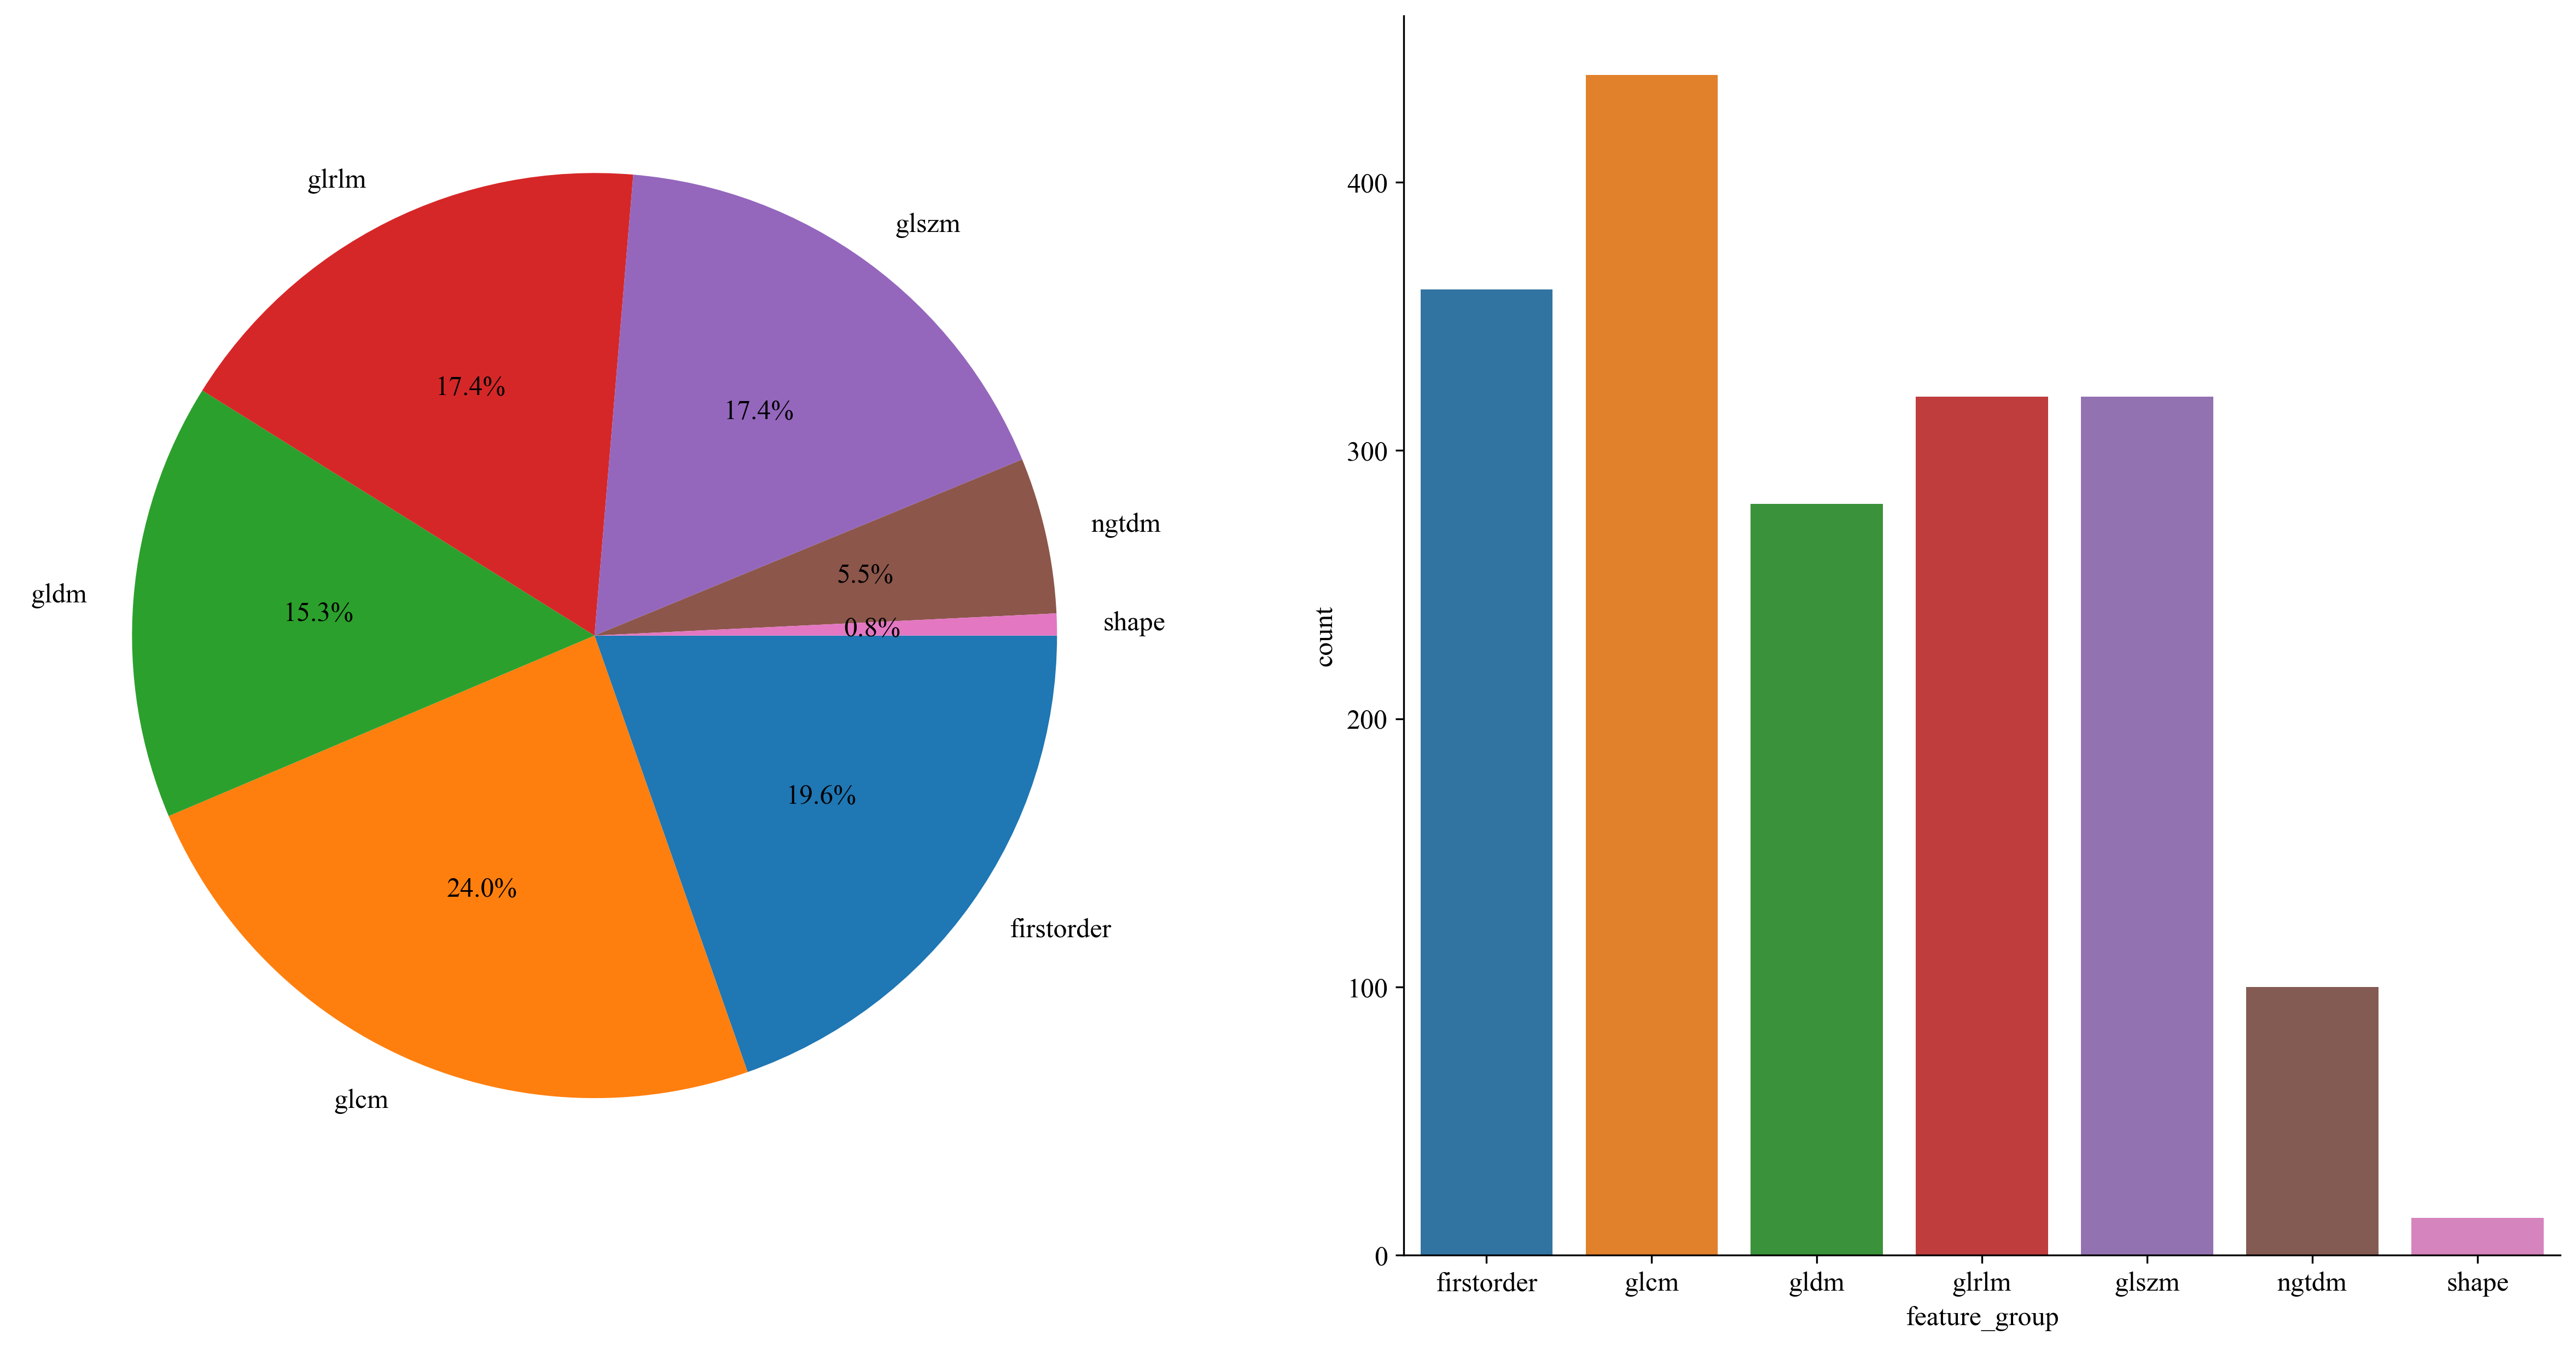

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sorted_counts = pd.DataFrame([c.split('_')[-3] for c in rad_data.columns if c !='ID']).value_counts()
sorted_counts = pd.DataFrame(sorted_counts, columns=['count']).reset_index()
sorted_counts = sorted_counts.sort_values(0)
sorted_counts.columns = ['feature_group', 'count']
display(sorted_counts)

plt.figure(figsize=(20, 10))
ax = plt.subplot(121)
plt.pie(sorted_counts['count'], labels=[i for i in sorted_counts['feature_group']], startangle=0,
        counterclock = False, autopct = '%.1f%%')
# plt.bar_label(bar.containers[0])
ax = plt.subplot(122)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
bar = sns.barplot(data=sorted_counts, x='feature_group', y='count', )
plt.savefig(f'img/{task_type}feature_ratio.svg', bbox_inches = 'tight')

## 标注数据

数据以csv格式进行存储，这里如果是其他格式，可以使用自定义函数读取出每个样本的结果。

要求label_data为一个`DataFrame`格式，包括ID列以及后续的labels列，可以是多列，支持Multi-Task。

In [8]:
group_info = 'group'
label_data = pd.read_csv(labelf)
label_data['ID'] = label_data['ID'].map(lambda x: f"{x}.nii.gz" if not (f"{x}".endswith('.nii.gz') or  f"{x}".endswith('.nii')) else x)
# g = pd.read_csv('ids.csv')
# label_data = pd.merge(label_data, g, on='ID', how='inner')
label_data = label_data[['ID', group_info] + labels]
label_data

ID  group  label
0    302.nii.gz  train      0
1    194.nii.gz  train      0
2    333.nii.gz  train      0
3    072.nii.gz  train      0
4    288.nii.gz  train      1
..          ...    ...    ...
395  312.nii.gz   test      1
396  242.nii.gz   test      0
397  098.nii.gz   test      1
398  420.nii.gz   test      1
399  244.nii.gz   test      1

[400 rows x 3 columns]

## 特征拼接 

将标注数据`label_data`与`rad_data`进行合并，得到训练数据。

**注意：** 
1. 需要删掉ID这一列
2. 如果发现数据少了，需要自行检查数据是否匹配。

In [9]:
# 删掉ID这一列。
from onekey_algo.custom.utils import print_join_info
print_join_info(rad_data, label_data)
combined_data = pd.merge(rad_data, label_data, on=['ID'], how='inner')
# combined_data[['ID'] + selected_features[0]].to_csv('features/sel_habitat.csv', index=False)
ids = combined_data['ID']
combined_data = combined_data.drop(['ID'], axis=1)
display(combined_data[labels].value_counts())
display(combined_data[group_info].value_counts())
combined_data

[2024-06-11 15:37:26 - __init__.py:  58]	WARNING	存在ID特征不完全匹配的问题！在左边不在右边的ID：{'337.nii.gz', '158.nii.gz', '255.nii.gz', '175.nii.gz', '071.nii.gz', '340.nii.gz', '427.nii.gz', '002.nii.gz', '123.nii.gz', '074.nii.gz', '160.nii.gz', '385.nii.gz', '441.nii.gz', '402.nii.gz', '204.nii.gz', '084.nii.gz', '209.nii.gz', '057.nii.gz', '416.nii.gz'}；在右边不在左边的ID：set()


label
1        305
0         95
dtype: int64

train    280
test     120
Name: group, dtype: int64

intra_exponential_firstorder_10Percentile_T2  \
0                                           0.525   
1                                           0.830   
2                                           0.169   
3                                           0.430   
4                                           0.431   
..                                            ...   
395                                         0.296   
396                                         0.277   
397                                         0.857   
398                                         0.663   
399                                         1.613   

     intra_exponential_firstorder_90Percentile_T2  \
0                                           0.971   
1                                           1.830   
2                                           0.347   
3                                           1.104   
4                                           0.717   
..                                            ...   
395                                         0.836   
396                                         0.536   
397                                         1.986   
398                                         3.472   
399                                         6.992   

     intra_exponential_firstorder_Energy_T2  \
0                                 4.479e+09   
1                                 1.200e+09   
2                                 1.383e+09   
3                                 7.910e+10   
4                                 3.834e+08   
..                                      ...   
395                               3.248e+09   
396                               7.516e+08   
397                               1.401e+10   
398                               8.127e+08   
399                               1.186e+09   

     intra_exponential_firstorder_Entropy_T2  \
0                                 -3.203e-16   
1                                  3.230e-02   
2                                 -3.203e-16   
3                                  1.888e-02   
4                                 -3.203e-16   
..                                       ...   
395                               -3.203e-16   
396                               -3.203e-16   
397                                1.218e-01   
398                                1.863e-01   
399                                9.523e-01   

     intra_exponential_firstorder_InterquartileRange_T2  \
0                                                0.237    
1                                                0.425    
2                                                0.093    
3                                                0.298    
4                                                0.143    
..                                                 ...    
395                                              0.293    
396                                              0.150    
397                                              0.516    
398                                              1.354    
399                                              2.841    

     intra_exponential_firstorder_Kurtosis_T2  \
0                                      14.093   
1                                      88.615   
2                                       7.264   
3                                     188.550   
4                                       6.329   
..                                        ...   
395                                    52.322   
396                                     3.839   
397                                  1184.255   
398                                     8.849   
399                                     3.290   

     intra_exponential_firstorder_Maximum_T2  \
0                                      2.612   
1                                     10.091   
2                                      0.714   
3                                     15.026   
4                                      1.103   
.. 

## 获取到数据的统计信息

1. count，统计样本个数。
2. mean、std, 对应特征的均值、方差
3. min, 25%, 50%, 75%, max，对应特征的最小值，25,50,75分位数，最大值。

In [10]:
combined_data.describe()

intra_exponential_firstorder_10Percentile_T2  \
count                                       400.000   
mean                                          0.730   
std                                           0.372   
min                                           0.058   
25%                                           0.494   
50%                                           0.686   
75%                                           0.927   
max                                           3.871   

       intra_exponential_firstorder_90Percentile_T2  \
count                                       400.000   
mean                                          2.430   
std                                           3.075   
min                                           0.148   
25%                                           1.223   
50%                                           1.792   
75%                                           2.734   
max                                          42.207   

       intra_exponential_firstorder_Energy_T2  \
count                               4.000e+02   
mean                                9.117e+09   
std                                 2.372e+10   
min                                 2.304e+07   
25%                                 1.075e+09   
50%                                 2.470e+09   
75%                                 7.230e+09   
max                                 3.179e+11   

       intra_exponential_firstorder_Entropy_T2  \
count                                4.000e+02   
mean                                 1.466e-01   
std                                  2.959e-01   
min                                 -3.203e-16   
25%                                 -3.203e-16   
50%                                  4.970e-02   
75%                                  1.446e-01   
max                                  3.083e+00   

       intra_exponential_firstorder_InterquartileRange_T2  \
count                                            400.000    
mean                                               0.807    
std                                                1.782    
min                                                0.030    
25%                                                0.312    
50%                                                0.498    
75%                                                0.815    
max                                               27.472    

       intra_exponential_firstorder_Kurtosis_T2  \
count                                   400.000   
mean                                    104.421   
std                                     262.402   
min                                       1.829   
25%                                      10.664   
50%                                      26.514   
75%                                      87.307   
max                                    3204.063   

       intra_exponential_firstorder_Maximum_T2  \
count                                  400.000   
mean                                    18.450   
std                                     29.175   
min                                      0.197   
25%                                      4.415   
50%                                      9.477   
75%                                     19.086   
max                                    264.151   

       intra_exponential_firstorder_Mean_T2  \
count                               400.000   
mean                                  1.489   
std                                   1.376   
min                                   0.108   
25%                                   0.877   
50%                                   1.233   
75%                                   1.776   
max                                  19.740   

       intra_exponential_firstorder_MeanAbsoluteDeviation_T2  \
count                                            400.000       
mean                                               0.644       
std                                          

## 正则化

`normalize_df` 为onekey中正则化的API，将数据变化到0均值1方差。正则化的方法为

$column = \frac{column - mean}{std}$

In [11]:
from onekey_algo.custom.components.comp1 import normalize_df
data = normalize_df(combined_data, not_norm=labels, group=group_info, use_train=True)
data = data.dropna(axis=1)
data.to_csv(f'features/{task_type}feature_norm.csv', index=False)
data.describe()

[2024-06-11 15:37:27 - comp1.py: 194]	INFO	正在使用训练集预定数据进行标准化。


intra_exponential_firstorder_10Percentile_T2  \
count                                       400.000   
mean                                         -0.054   
std                                           0.951   
min                                          -1.772   
25%                                          -0.657   
50%                                          -0.166   
75%                                           0.450   
max                                           7.984   

       intra_exponential_firstorder_90Percentile_T2  \
count                                       400.000   
mean                                         -0.054   
std                                           0.872   
min                                          -0.701   
25%                                          -0.396   
50%                                          -0.235   
75%                                           0.032   
max                                          11.223   

       intra_exponential_firstorder_Energy_T2  \
count                                 400.000   
mean                                    0.077   
std                                     1.383   
min                                    -0.453   
25%                                    -0.392   
50%                                    -0.310   
75%                                    -0.033   
max                                    18.081   

       intra_exponential_firstorder_Entropy_T2  \
count                                  400.000   
mean                                    -0.057   
std                                      0.900   
min                                     -0.503   
25%                                     -0.503   
50%                                     -0.352   
75%                                     -0.063   
max                                      8.876   

       intra_exponential_firstorder_InterquartileRange_T2  \
count                                            400.000    
mean                                              -0.046    
std                                                0.851    
min                                               -0.417    
25%                                               -0.283    
50%                                               -0.194    
75%                                               -0.042    
max                                               12.679    

       intra_exponential_firstorder_Kurtosis_T2  \
count                                   400.000   
mean                                      0.053   
std                                       1.294   
min                                      -0.453   
25%                                      -0.409   
50%                                      -0.331   
75%                                      -0.031   
max                                      15.338   

       intra_exponential_firstorder_Maximum_T2  \
count                                  400.000   
mean                                     0.099   
std                                      1.475   
min                                     -0.824   
25%                                     -0.610   
50%                                     -0.354   
75%                                      0.132   
max                                     12.523   

       intra_exponential_firstorder_Mean_T2  \
count                               400.000   
mean                                 -0.056   
std                                   0.877   
min                                  -0.936   
25%                                  -0.446   
50%                                  -0.219   
75%                                   0.127   
max                                  11.571   

       intra_exponential_firstorder_MeanAbsoluteDeviation_T2  \
count                                            400.000       
mean                                              -0.046       
std                                          

## 统计检验

通过ttest或者utest进行特征筛选。

**注意** ：此步骤不是论文的标配，所以用不用在自己的选择，可以通过修改pvalue的值进行调整，默认是0.05为显著。

In [12]:
import seaborn as sns
from onekey_algo.custom.components.stats import clinic_stats

sub_data = data[data[group_info] == 'train']
stats = clinic_stats(sub_data, stats_columns=list(data.columns[0:-2]), label_column=labels[0], 
                     continuous_columns=list(data.columns[0:-2]))
stats

feature_name  -label=ALL  \
0          intra_exponential_firstorder_10Percentile_T2  -0.00±1.00   
1          intra_exponential_firstorder_90Percentile_T2   0.00±1.00   
2                intra_exponential_firstorder_Energy_T2  -0.00±1.00   
3               intra_exponential_firstorder_Entropy_T2  -0.00±1.00   
4     intra_exponential_firstorder_InterquartileRang...  -0.00±1.00   
...                                                 ...         ...   
1829                intra_wavelet_LLL_ngtdm_Busyness_T2   0.00±1.00   
1830              intra_wavelet_LLL_ngtdm_Coarseness_T2  -0.00±1.00   
1831              intra_wavelet_LLL_ngtdm_Complexity_T2   0.00±1.00   
1832                intra_wavelet_LLL_ngtdm_Contrast_T2  -0.00±1.00   
1833                intra_wavelet_LLL_ngtdm_Strength_T2   0.00±1.00   

        -label=0    -label=1 pvalue  
0      0.17±0.97  -0.05±1.01  0.042  
1      0.18±1.23  -0.05±0.92  0.017  
2     -0.18±0.42   0.05±1.11  0.048  
3      0.18±1.15  -0.05±0.95  0.103  
4      0.12±1.20  -0.04±0.93  0.026  
...          ...         ...    ...  
1829  -0.22±0.69   0.07±1.07  0.071  
1830   0.32±1.72  -0.09±0.62  0.058  
1831   0.10±1.25  -0.03±0.91  0.904  
1832   0.27±2.03  -0.08±0.24  0.002  
1833   0.23±1.80  -0.07±0.57  0.114  

[1834 rows x 5 columns]

#### 输出特征分布的图

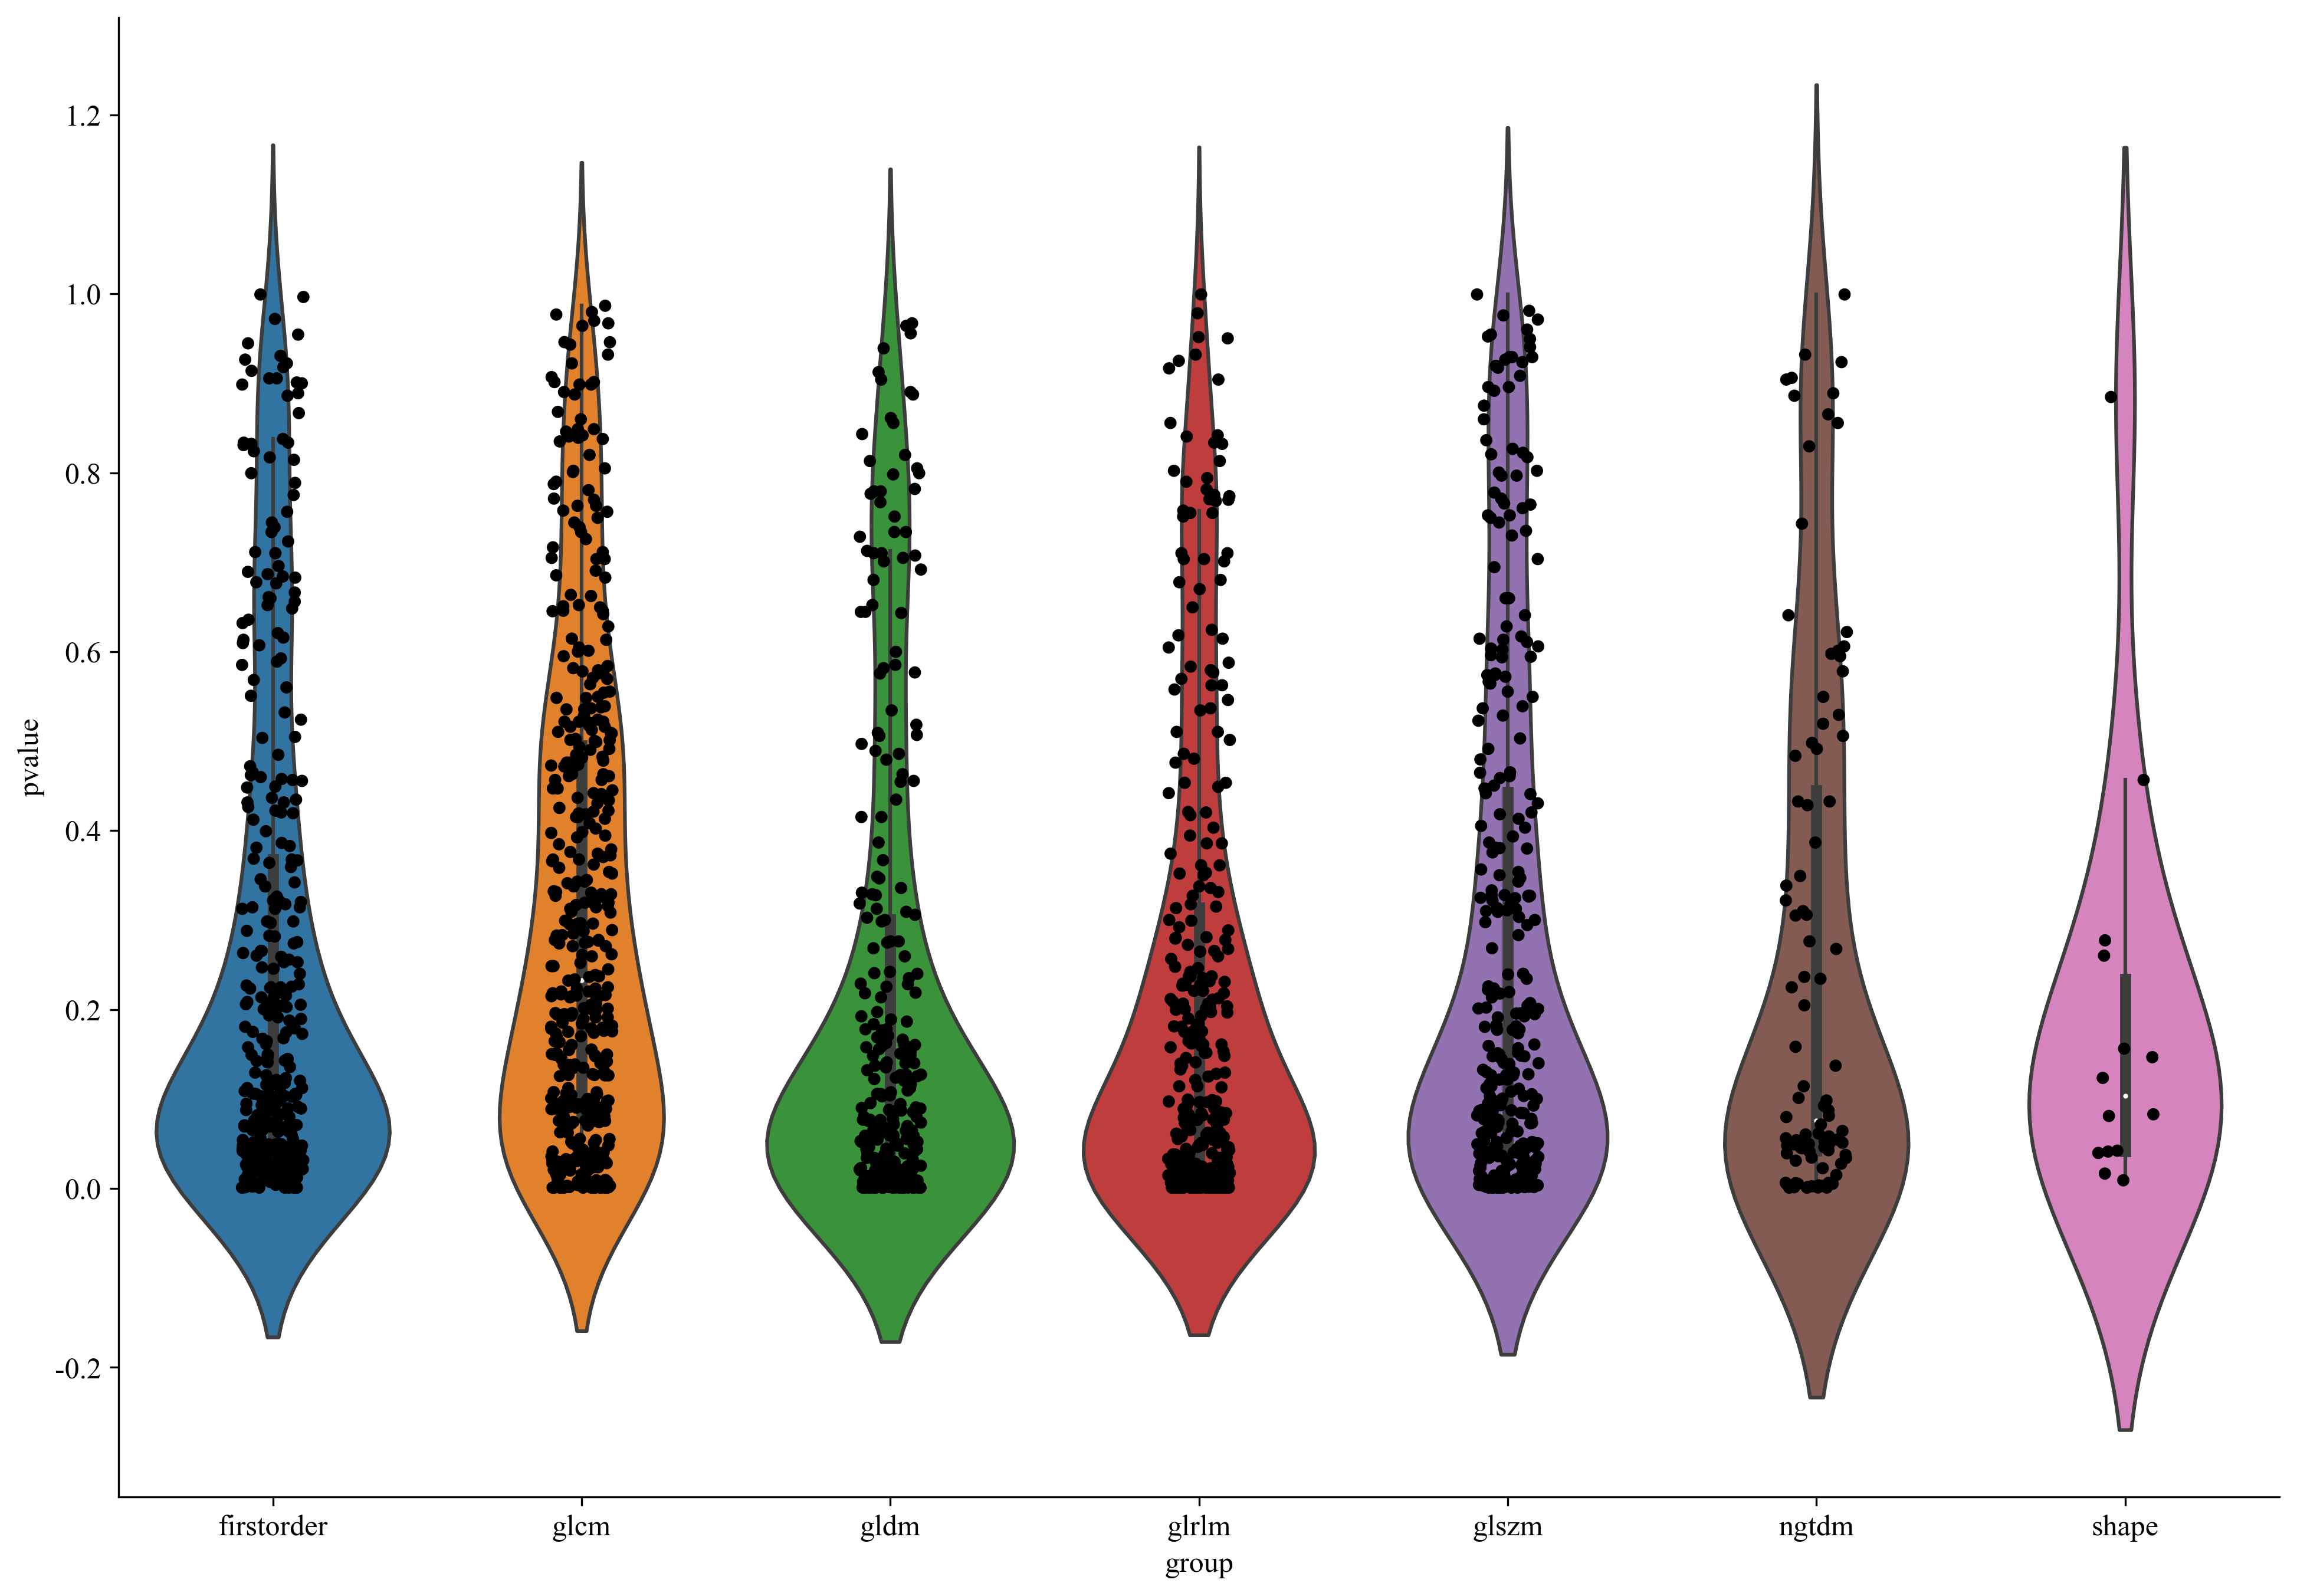

In [13]:
import matplotlib.pyplot as plt

def map2float(x):
    try:
        return float(str(x)[1:])
    except:
        return 1

stats[['pvalue']] = stats[['pvalue']].applymap(map2float)
stats[['group']] = stats[['feature_name']].applymap(lambda x: x.split('_')[-3])
stats = stats[['feature_name', 'pvalue', 'group']]
g = sns.catplot(x="group", y="pvalue", data=stats, kind="violin")
g.fig.set_size_inches(15,10)
sns.stripplot(x="group", y="pvalue", data=stats, ax=g.ax, color='black')
plt.savefig(f'img/{task_type}feature_stats.svg', bbox_inches = 'tight')

#### 调整pvalue进行筛选。

In [14]:
pvalue = 0.05
sel_feature = list(stats[stats['pvalue'] < pvalue]['feature_name']) + labels + [group_info]
sub_data = sub_data[sel_feature]
sub_data

intra_exponential_firstorder_10Percentile_T2  \
0                                          -0.579   
1                                           0.203   
2                                          -1.489   
8                                           0.766   
10                                         -0.238   
..                                            ...   
394                                        -0.910   
395                                        -1.163   
397                                         0.271   
398                                        -0.224   
399                                         2.207   

     intra_exponential_firstorder_90Percentile_T2  \
0                                          -0.468   
1                                          -0.224   
2                                          -0.644   
8                                          -0.195   
10                                         -0.043   
..                                            ...   
394                                        -0.560   
395                                        -0.506   
397                                        -0.180   
398                                         0.241   
399                                         1.239   

     intra_exponential_firstorder_Energy_T2  \
0                                    -0.193   
1                                    -0.385   
2                                    -0.374   
8                                    -0.405   
10                                   -0.346   
..                                      ...   
394                                  -0.332   
395                                  -0.265   
397                                   0.363   
398                                  -0.407   
399                                  -0.385   

     intra_exponential_firstorder_InterquartileRange_T2  \
0                                               -0.318    
1                                               -0.229    
2                                               -0.387    
8                                               -0.231    
10                                              -0.037    
..                                                 ...    
394                                             -0.364    
395                                             -0.292    
397                                             -0.185    
398                                              0.215    
399                                              0.924    

     intra_exponential_firstorder_Kurtosis_T2  \
0                                      -0.392   
1                                      -0.025   
2                                      -0.426   
8                                       0.096   
10                                     -0.410   
..                                        ...   
394                                    -0.442   
395                                    -0.204   
397                                     5.378   
398                                    -0.418   
399                                    -0.445   

     intra_exponential_firstorder_Mean_T2  \
0                                  -0.532   
1                                  -0.186   
2                                  -0.847   
8                                  -0.008   
10                                 -0.083   
..                                    ...   
394                                -0.677   
395                                -0.658   
397                                -0.057   
398                                 0.050   
399                                 1.627   

     intra_exponential_firstorder_Minimum_T2  \
0                                     -0.583   
1                                      0.976   
2                                     -1.196   
8                                      1.872   
10                                     0.085   
..                                     

### 相关系数

计算相关系数的方法有3种可供选择
1. pearson （皮尔逊相关系数）: standard correlation coefficient

2. kendall (肯德尔相关性系数) : Kendall Tau correlation coefficient

3. spearman (斯皮尔曼相关性系数): Spearman rank correlation

三种相关系数参考：https://blog.csdn.net/zmqsdu9001/article/details/82840332

In [15]:
# 相关系数视频
onekey_show('传统组学任务|相关系数')

[2024-06-11 15:37:39 - Manager.py: 118]	INFO	播放视频功能已经设置成：Disable！


In [16]:
pearson_corr = sub_data[[c for c in sub_data.columns if c not in labels]].corr('pearson')
# kendall_corr = data[[c for c in data.columns if c not in labels]].corr('kendall')
# spearman_corr = data[[c for c in data.columns if c not in labels]].corr('spearman')

### 相关系数可视化

通过修改变量名，可以可视化不同相关系数下的相关矩阵。

**注意**：当特征特别多的时候（大于100），尽量不要可视化，否则运行时间会特别长。

In [17]:
import seaborn as sns
from onekey_algo.custom.components.comp1 import draw_matrix

if data.shape[1] < 100:
    plt.figure(figsize=(50.0, 40.0))

    # 选择可视化的相关系数
    draw_matrix(pearson_corr, annot=True, cmap='YlGnBu', cbar=False)
    plt.savefig(f'img/{task_type}Rad_feature_corr.svg', bbox_inches = 'tight')

### 聚类分析

通过修改变量名，可以可视化不同相关系数下的相聚类分析矩阵。

注意：当特征特别多的时候（大于100），尽量不要可视化，否则运行时间会特别长。

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

if data.shape[1] < 100:
    pp = sns.clustermap(pearson_corr, linewidths=.5, figsize=(50.0, 40.0), cmap='YlGnBu')
    plt.setp(pp.ax_heatmap.get_yticklabels(), rotation=0)
    plt.savefig(f'img/{task_type}Rad_feature_cluster.svg', bbox_inches = 'tight')

### 特征筛选 -- 相关系数

根据相关系数，对于相关性比较高的特征（一般文献取corr>0.9），两者保留其一。

```python
def select_feature(corr, threshold: float = 0.9, keep: int = 1, topn=10, verbose=False):
    """
    * corr, 相关系数矩阵。
    * threshold，筛选的相关系数的阈值，大于阈值的两者保留其一（可以根据keep修改，可以是其二...）。默认阈值为0.9
    * keep，可以选择大于相关系数，保留几个，默认只保留一个。
    * topn, 每次去掉多少重复特征。
    * verbose，是否打印日志
    """
```

In [19]:
# 特征筛选视频
onekey_show('传统组学任务|特征筛选')

[2024-06-11 15:37:39 - Manager.py: 118]	INFO	播放视频功能已经设置成：Disable！


In [20]:
import math
from onekey_algo.custom.components.comp1 import select_feature, select_feature_mrmr

sel_feature = select_feature(pearson_corr, threshold=0.9, topn=128, verbose=False)
# sel_feature = select_feature_mrmr(sub_data[sel_feature + labels], num_features=32)
sel_feature += labels + [group_info]
sel_feature

['intra_exponential_firstorder_Minimum_T2',
 'intra_exponential_firstorder_Skewness_T2',
 'intra_exponential_glcm_Idn_T2',
 'intra_exponential_gldm_DependenceNonUniformityNormalized_T2',
 'intra_exponential_gldm_LargeDependenceHighGrayLevelEmphasis_T2',
 'intra_exponential_gldm_LargeDependenceLowGrayLevelEmphasis_T2',
 'intra_exponential_gldm_SmallDependenceLowGrayLevelEmphasis_T2',
 'intra_exponential_glrlm_RunEntropy_T2',
 'intra_exponential_glrlm_RunPercentage_T2',
 'intra_exponential_glrlm_ShortRunEmphasis_T2',
 'intra_exponential_glrlm_ShortRunLowGrayLevelEmphasis_T2',
 'intra_exponential_glszm_LargeAreaLowGrayLevelEmphasis_T2',
 'intra_exponential_glszm_ZonePercentage_T2',
 'intra_gradient_firstorder_10Percentile_T2',
 'intra_gradient_firstorder_Minimum_T2',
 'intra_gradient_firstorder_Skewness_T2',
 'intra_gradient_glcm_Idn_T2',
 'intra_gradient_gldm_SmallDependenceLowGrayLevelEmphasis_T2',
 'intra_gradient_glszm_LowGrayLevelZoneEmphasis_T2',
 'intra_gradient_glszm_SmallAreaEmph

### 过滤特征

通过`sel_feature`过滤出筛选出来的特征。

In [21]:
sel_data = data[sel_feature]
sel_data

intra_exponential_firstorder_Minimum_T2  \
3                                     -0.973   
4                                     -0.150   
5                                     -0.410   
6                                      0.003   
7                                     -0.701   
..                                       ...   
394                                   -0.419   
395                                   -1.001   
397                                    0.400   
398                                    0.537   
399                                    0.793   

     intra_exponential_firstorder_Skewness_T2  intra_exponential_glcm_Idn_T2  \
3                                       0.756                          0.399   
4                                      -0.721                          0.429   
5                                      -0.552                          0.429   
6                                       0.018                          0.136   
7                                      -0.698                          0.429   
..                                        ...                            ...   
394                                    -0.864                          0.429   
395                                    -0.080                          0.429   
397                                     4.658                          0.358   
398                                    -0.612                         -0.126   
399                                    -0.889                         -3.169   

     intra_exponential_gldm_DependenceNonUniformityNormalized_T2  \
3                                                2.364             
4                                               -1.049             
5                                               -0.250             
6                                               -1.015             
7                                               -0.418             
..                                                 ...             
394                                              0.129             
395                                              0.143             
397                                              0.985             
398                                             -0.700             
399                                             -1.204             

     intra_exponential_gldm_LargeDependenceHighGrayLevelEmphasis_T2  \
3                                                0.890                
4                                               -1.668                
5                                                0.134                
6                                               -0.631                
7                                               -0.019                
..                                                 ...                
394                                              0.199                
395                                              0.255                
397                                              0.526                
398                                             -0.267                
399                                              0.906                

     intra_exponential_gldm_LargeDependenceLowGrayLevelEmphasis_T2  \
3                                                1.485               
4                                               -2.203               
5                                                0.397               
6                                               -0.714               
7                                                0.177               
..                                                 ...               
394                                              0.492               
395                                              0.572               
397                                              0.915               
398                                             -0.205               
399                        

### 样本可视化

根据特征和label信息，将rad features降维到2维，看不同的label样本在二维空间的分布。

**注意**：由于特征空间维度极高，降维难免会有损失，所以二维的可视化仅供参考。

目前支持的:

| **降维方法** | **Method名称**                                                 |
| ------------ | ------------------------------------------------------------ |
| LLE      | Standard LLE, Modified LLE                                   |
| PCA      | t-SNE, NCA                                                      |
| SVD      | Truncated SVD                                              |
| Model Based      | Random projection, Isomap, MDS, Random Trees,Spectral       |

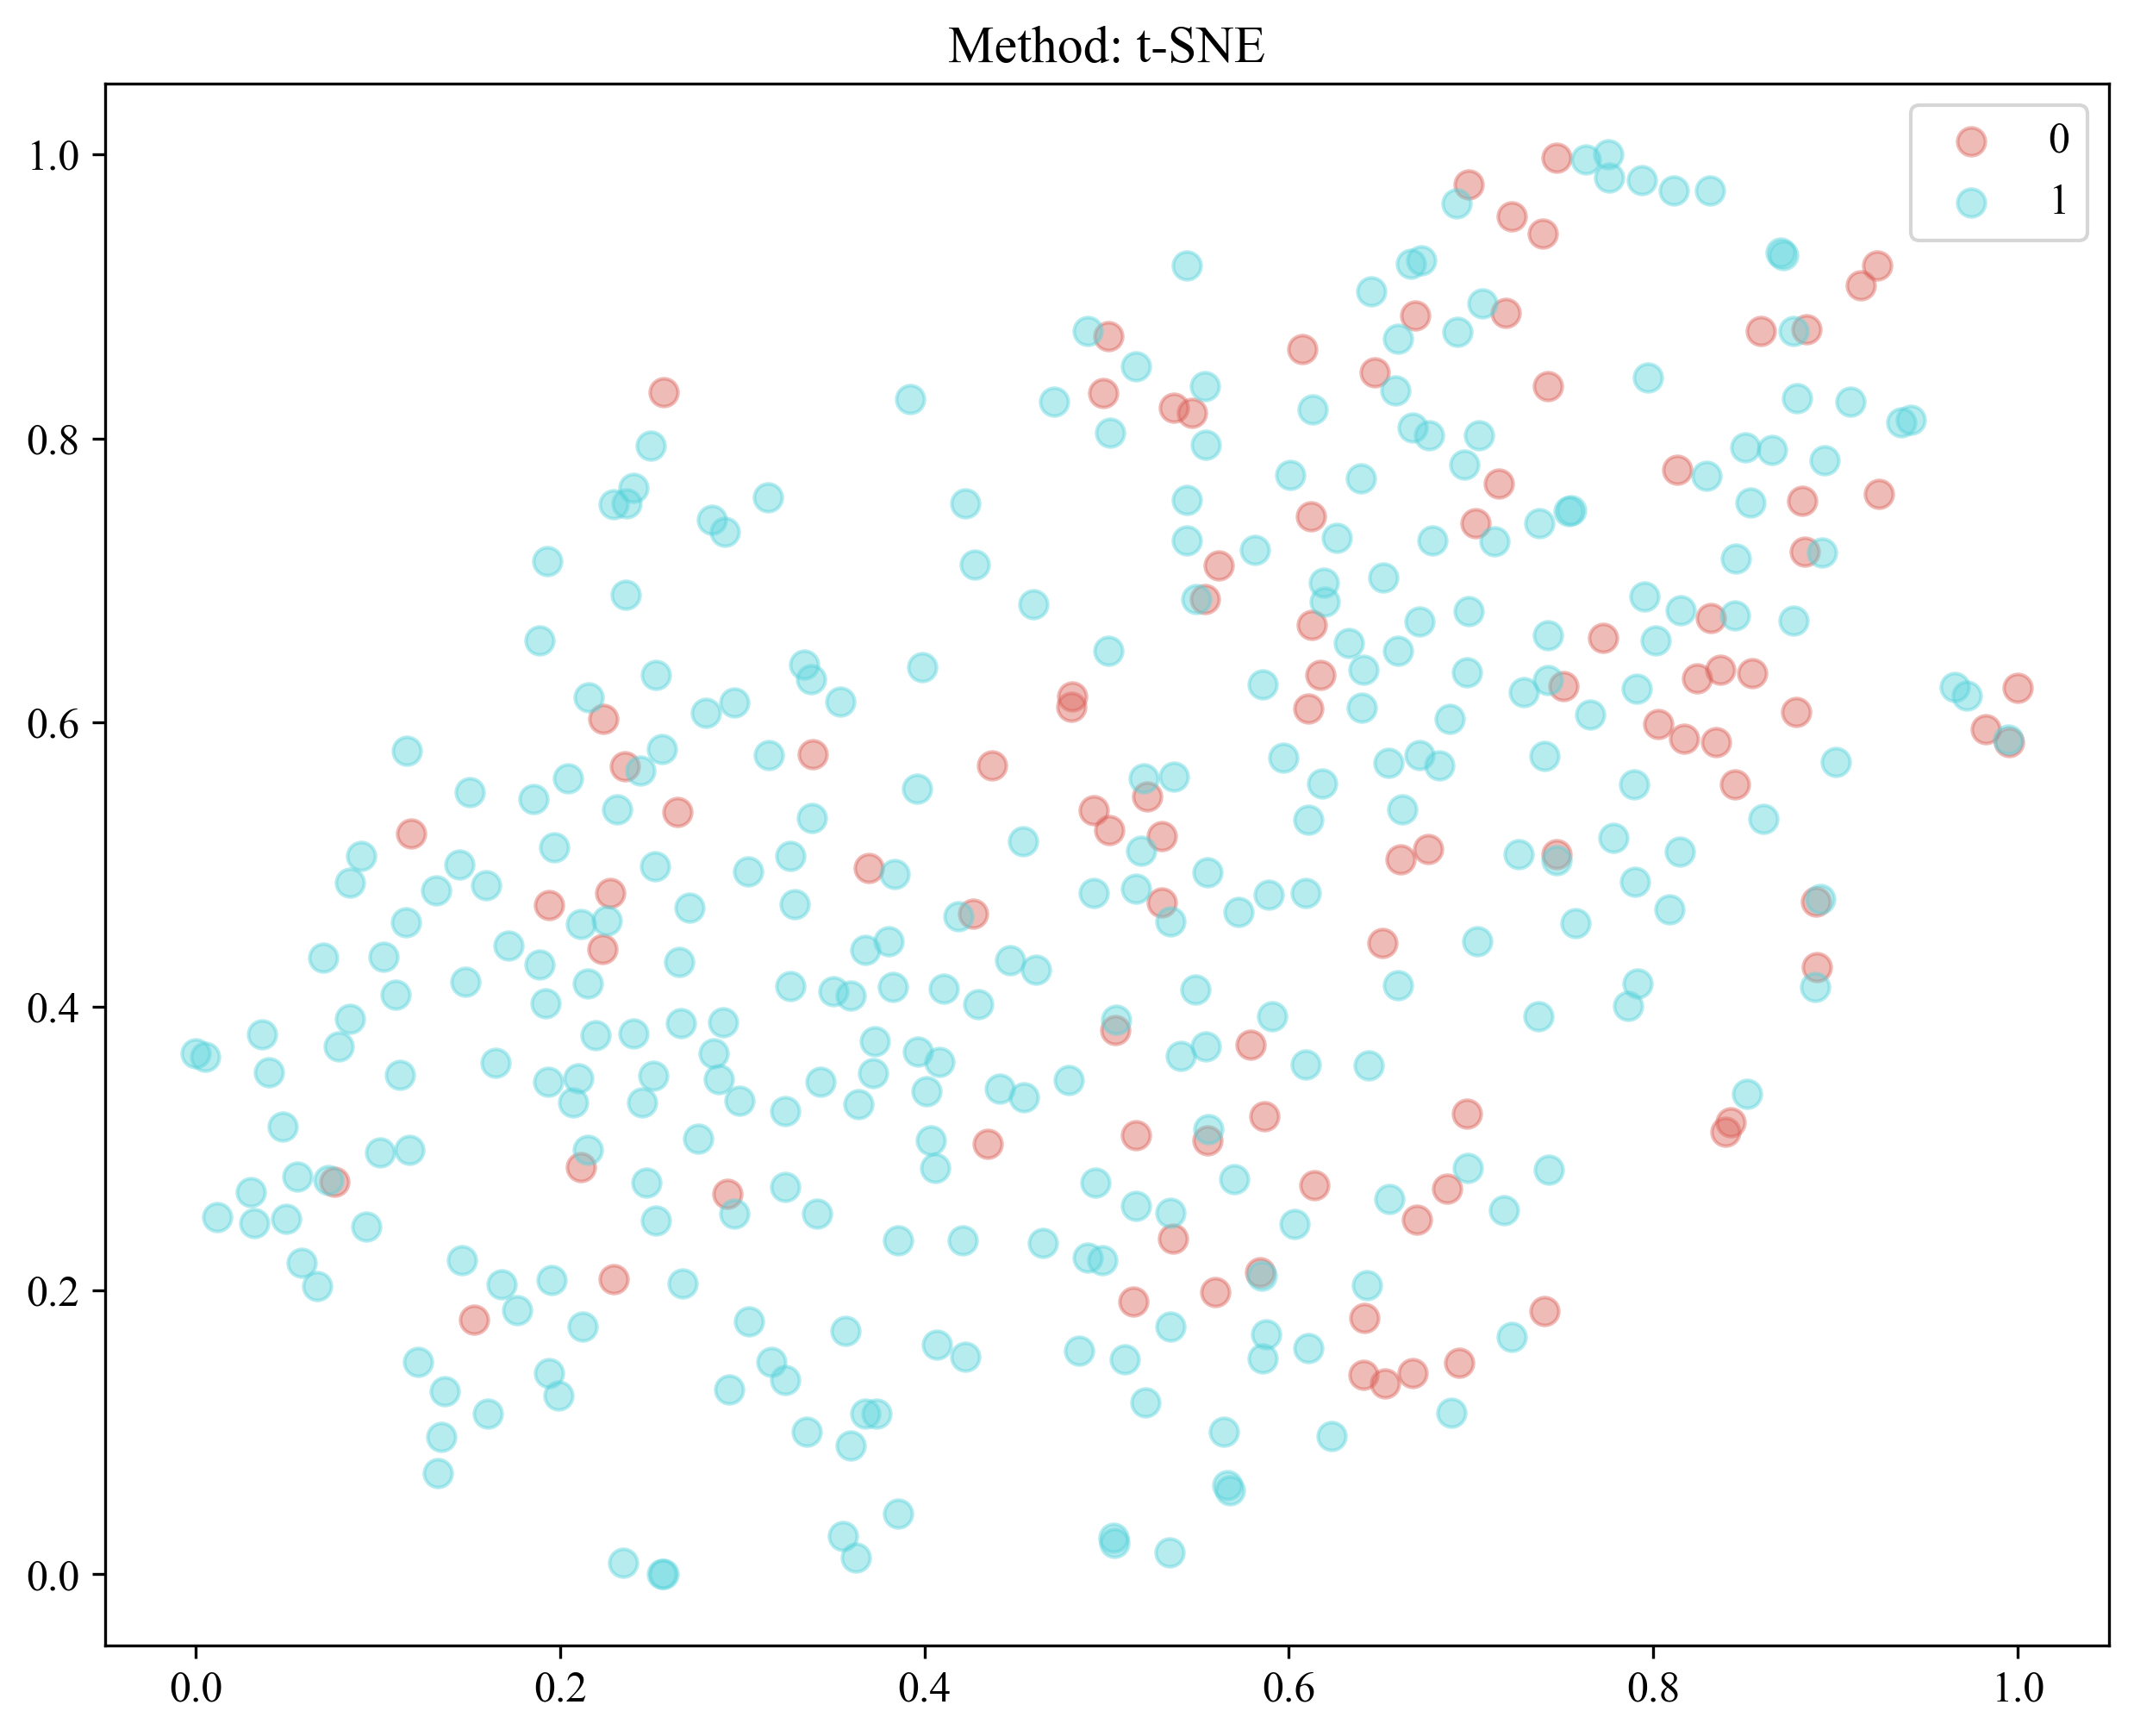

In [22]:
from onekey_algo.custom.components.comp1 import analysis_features
analysis_features(data[sel_feature[:-2]], data[labels[0]], methods='t-SNE')

## 构建数据

将样本的训练数据X与监督信息y分离出来，并且对训练数据进行划分，一般的划分原则为80%-20%

In [23]:
import numpy as np
import onekey_algo.custom.components as okcomp
from collections import OrderedDict
n_classes = 2
train_data = sel_data[(sel_data[group_info] == 'train')]
train_ids = ids[train_data.index]
train_data = train_data.reset_index()
train_data = train_data.drop('index', axis=1)
y_data = train_data[labels]
X_data = train_data.drop(labels + [group_info], axis=1)

subsets = [s for s in get_param_in_cwd('subsets') if s != 'train']
val_datasets = OrderedDict()
for subset in subsets:
    val_data = sel_data[sel_data[group_info] == subset]
    val_ids = ids[val_data.index]
    val_data = val_data.reset_index()
    val_data = val_data.drop('index', axis=1)
    y_val_data = val_data[labels]
    X_val_data = val_data.drop(labels + [group_info], axis=1)
    val_datasets[subset] = [X_val_data, y_val_data, val_ids]

y_all_data = sel_data[labels]
X_all_data = sel_data.drop(labels + [group_info], axis=1)

column_names = X_data.columns
print(f"训练集样本数：{X_data.shape}，", '，'.join([f"{subset}样本数：{d_[0].shape}" for subset, d_ in val_datasets.items()]))

训练集样本数：(280, 149)， test样本数：(120, 149)


### Lasso

初始化Lasso模型，alpha为惩罚系数。具体的参数文档可以参考：[文档](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html?highlight=lasso#sklearn.linear_model.Lasso)

### 交叉验证

不同Lambda下的，特征的的权重大小。
```python
def lasso_cv_coefs(X_data, y_data, points=50, column_names: List[str] = None, **kwargs):
    """

    Args:
        X_data: 训练数据
        y_data: 监督数据
        points: 打印多少个点。默认50
        column_names: 列名，默认为None，当选择的数据很多的时候，建议不要添加此参数
        **kwargs: 其他用于打印控制的参数。

    """
 ```

Points: 50, CV: 2


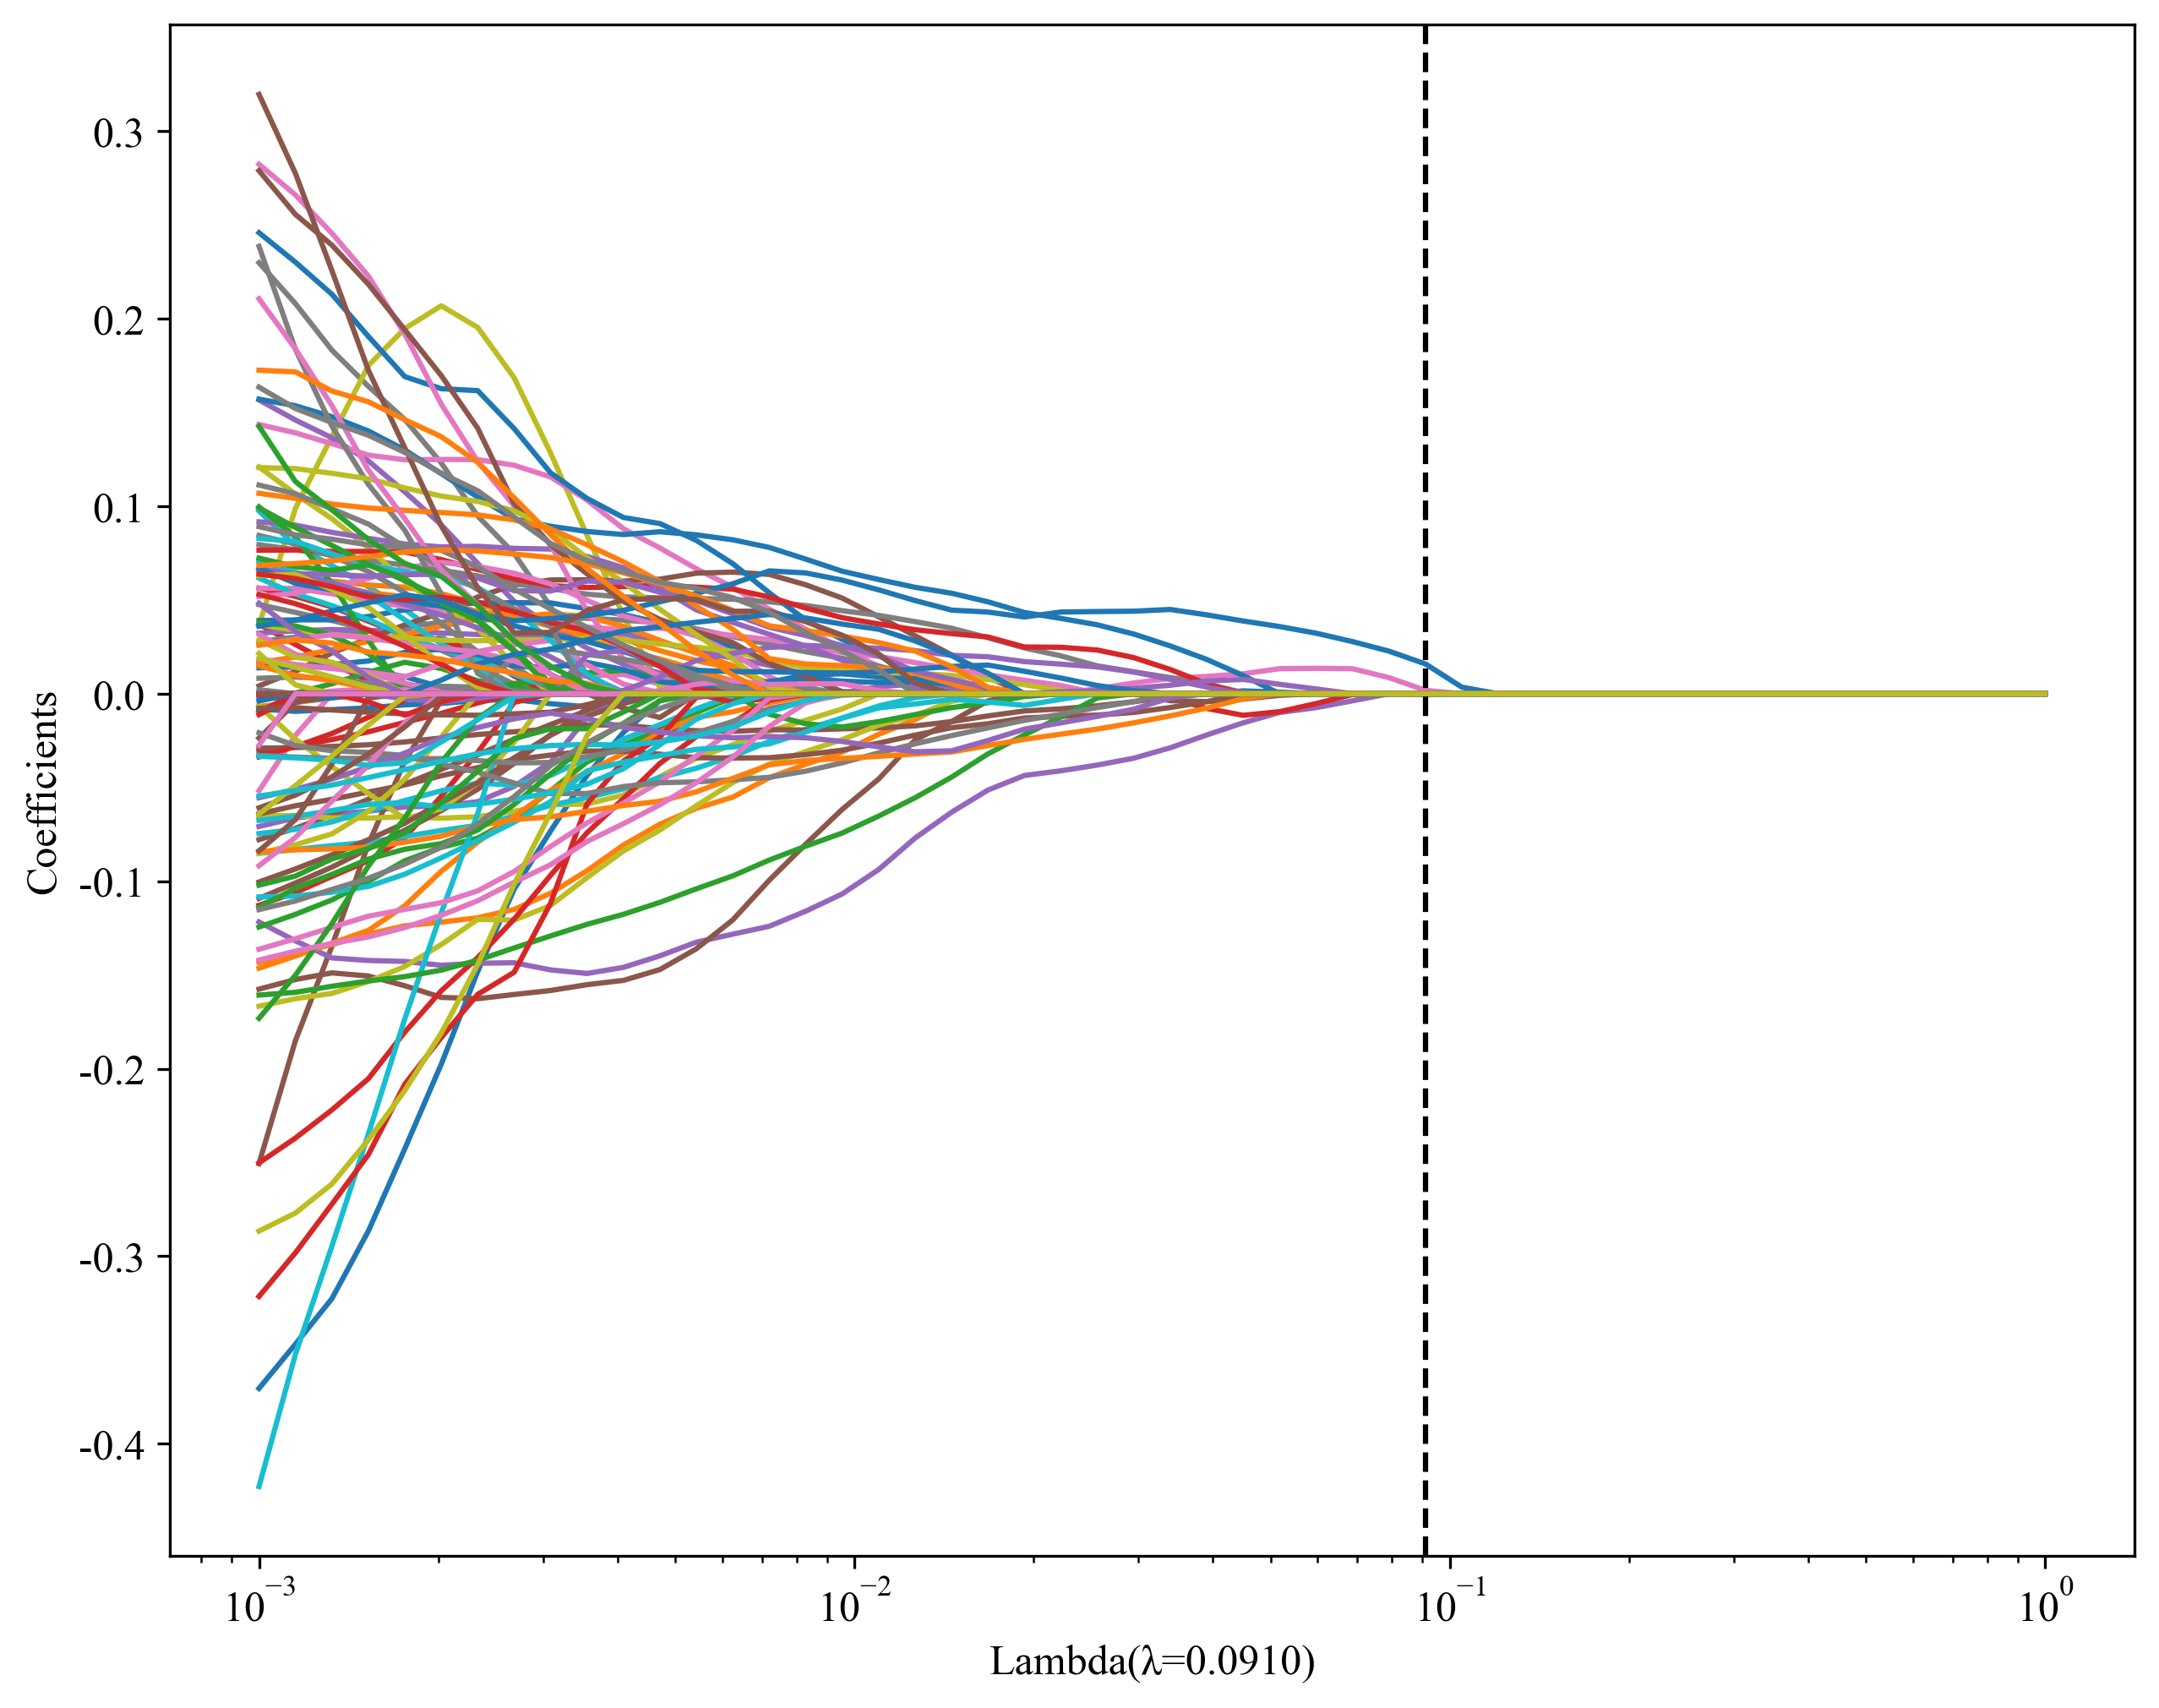

In [24]:
alpha = okcomp.comp1.lasso_cv_coefs(X_data, y_data, column_names=None, cv=2)
plt.savefig(f'img/{task_type}feature_lasso.svg', bbox_inches = 'tight')

### 模型效能

```python
def lasso_cv_efficiency(X_data, y_data, points=50, **kwargs):
    """

    Args:
        Xdata: 训练数据
        ydata: 测试数据
        points: 打印的数据密度
        **kwargs: 其他的图像样式
            # 数据点标记, fmt="o"
            # 数据点大小, ms=3
            # 数据点颜色, mfc="r"
            # 数据点边缘颜色, mec="r"
            # 误差棒颜色, ecolor="b"
            # 误差棒线宽, elinewidth=2
            # 误差棒边界线长度, capsize=2
            # 误差棒边界厚度, capthick=1
    Returns:
    """
 ```

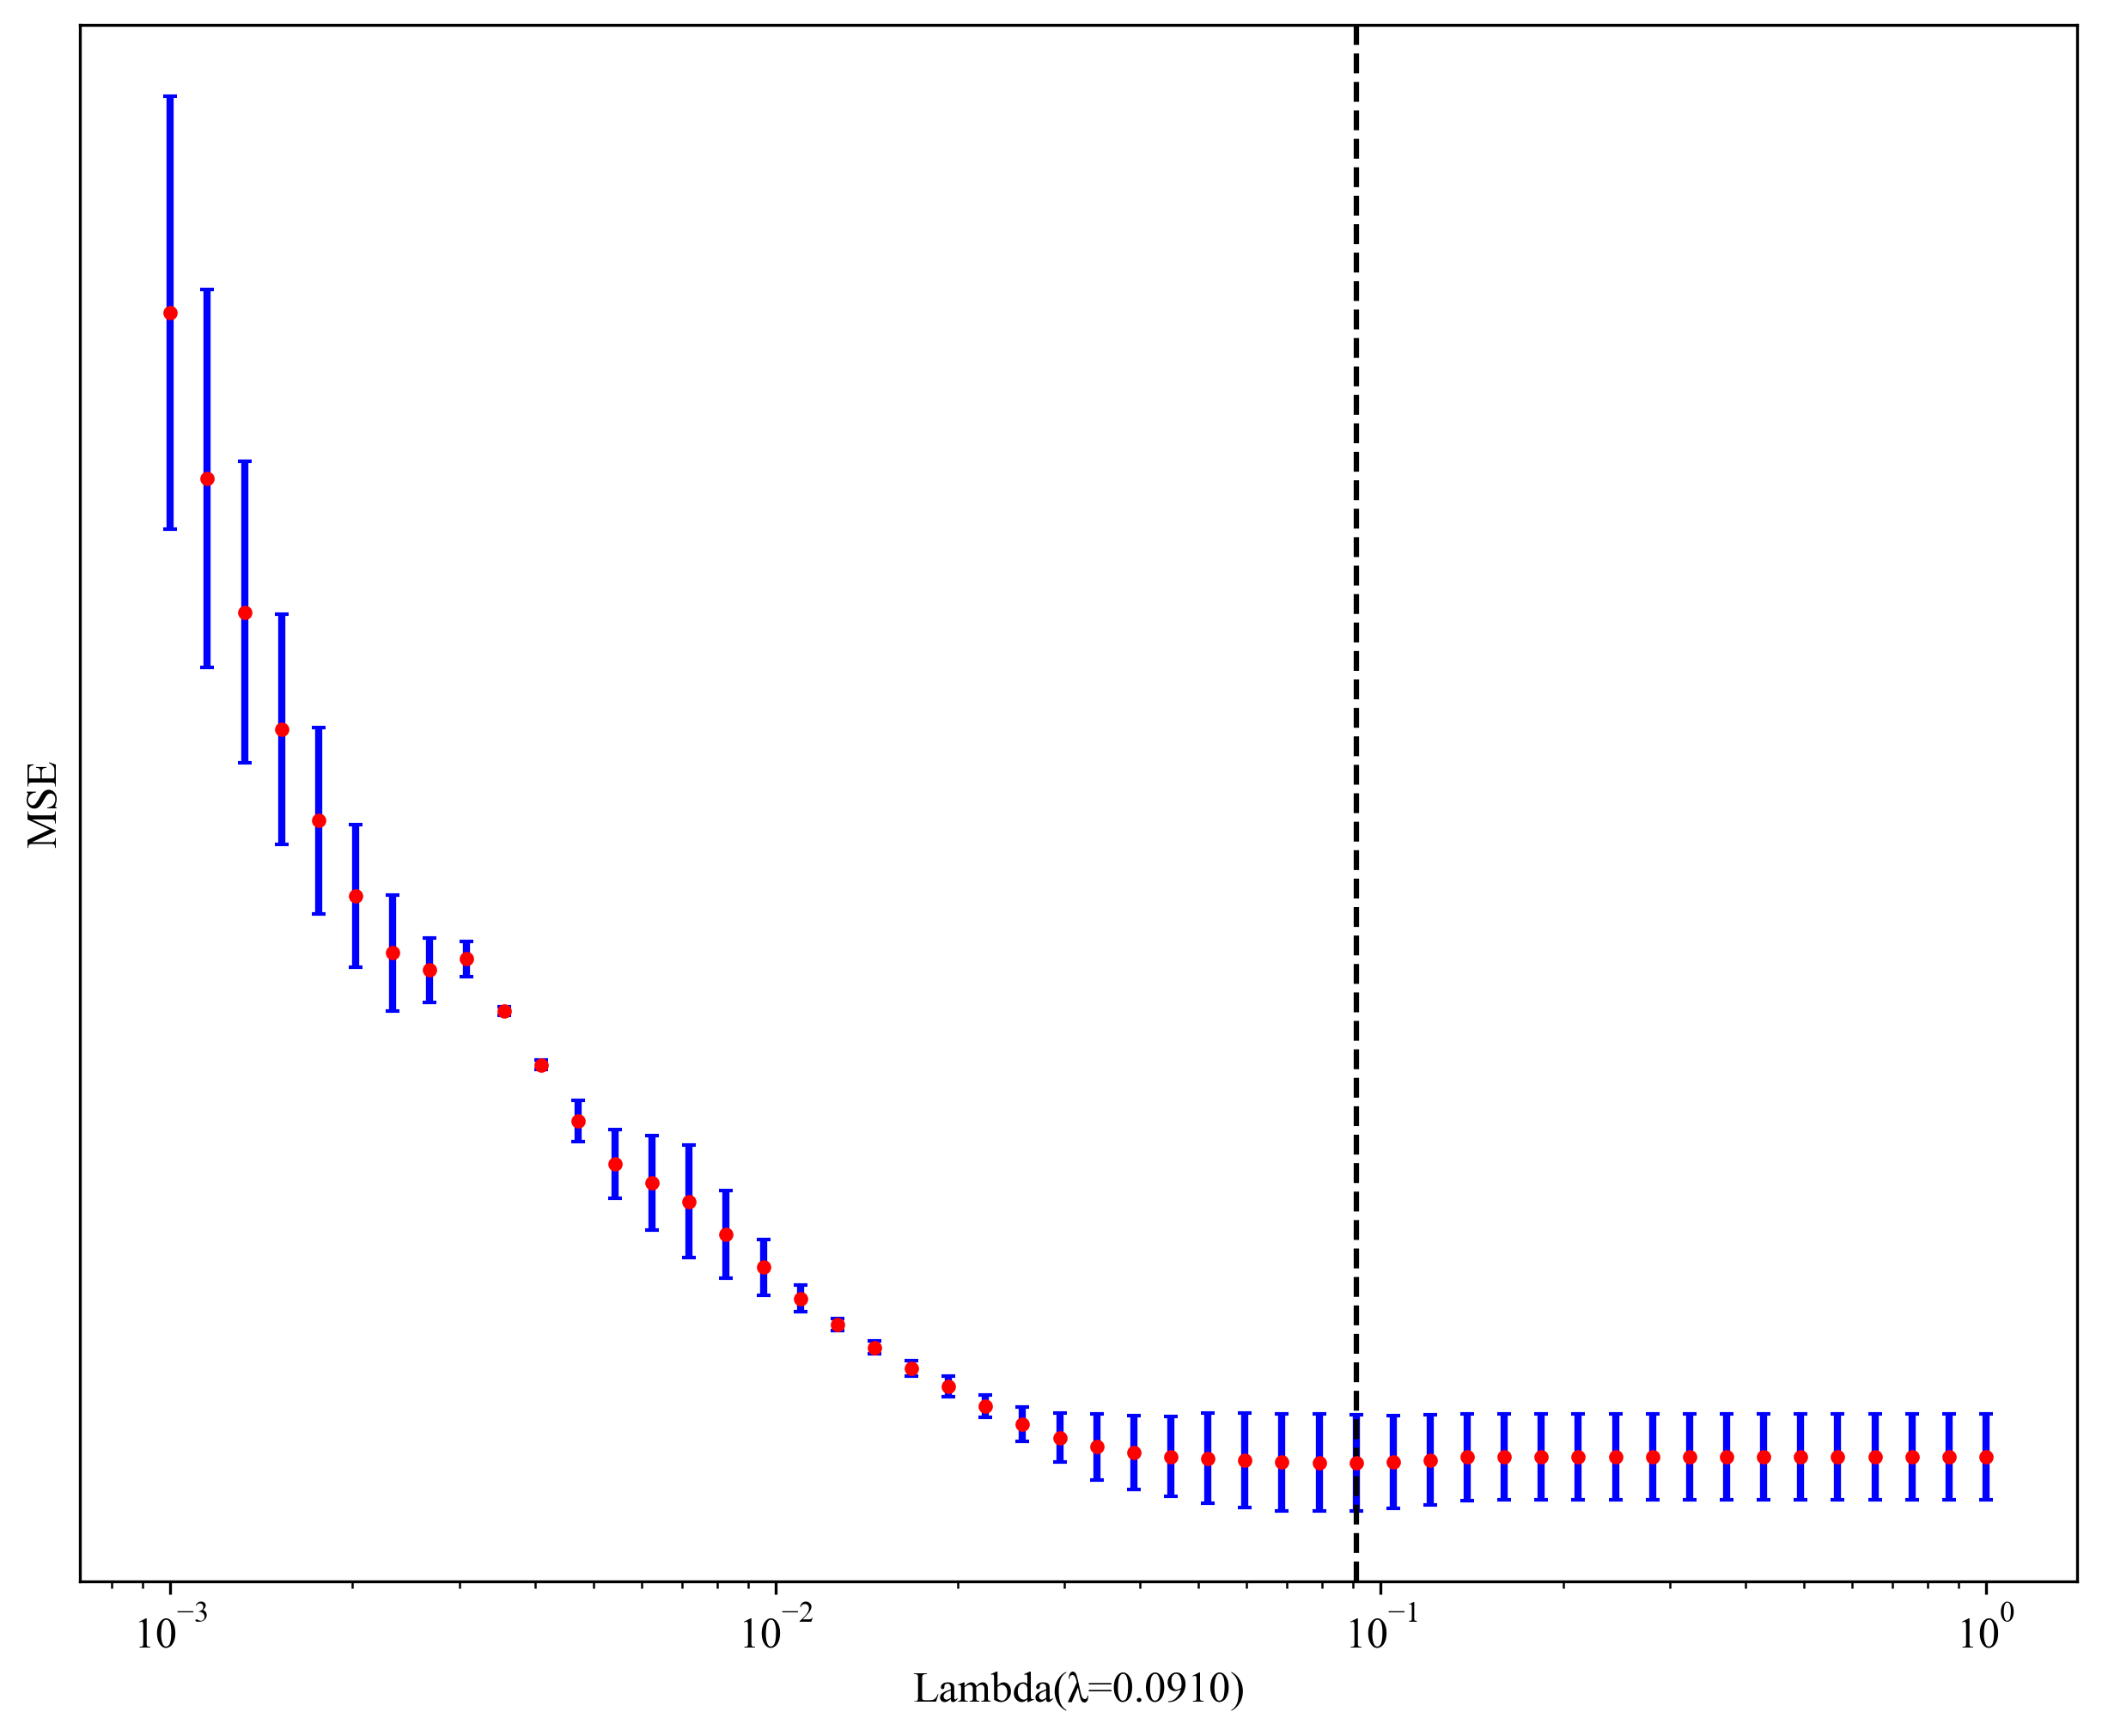

In [25]:
okcomp.comp1.lasso_cv_efficiency(X_data, y_data, points=50, cv=2, y_major_locator=1)
plt.savefig(f'img/{task_type}feature_mse.svg', bbox_inches = 'tight')

### 惩罚系数

使用交叉验证的惩罚系数作为模型训练的基础。

In [26]:
from sklearn import linear_model

models = []
for label in labels:
    clf = linear_model.Lasso(alpha=alpha)
    clf.fit(X_data, y_data[label])
    models.append(clf)

### 特征筛选

筛选出其中coef > 0的特征。并且打印出相应的公式。

In [27]:
COEF_THRESHOLD = 1e-6 # 筛选的特征阈值
scores = []
selected_features = []
for label, model in zip(labels, models):
    feat_coef = [(feat_name, coef) for feat_name, coef in zip(column_names, model.coef_) 
                 if COEF_THRESHOLD is None or abs(coef) > COEF_THRESHOLD]
    selected_features.append([feat for feat, _ in feat_coef])
    formula = ' '.join([f"{coef:+.6f} * {feat_name}" for feat_name, coef in feat_coef])
    score = f"{label} = {model.intercept_} {'+' if formula[0] != '-' else ''} {formula}"
    scores.append(score)
    
print(scores[0])

label = 0.7714285714285714 + +0.001816 * intra_gradient_glcm_Idn_T2 +0.015926 * intra_wavelet_LHL_glcm_Idn_T2


### 特征权重

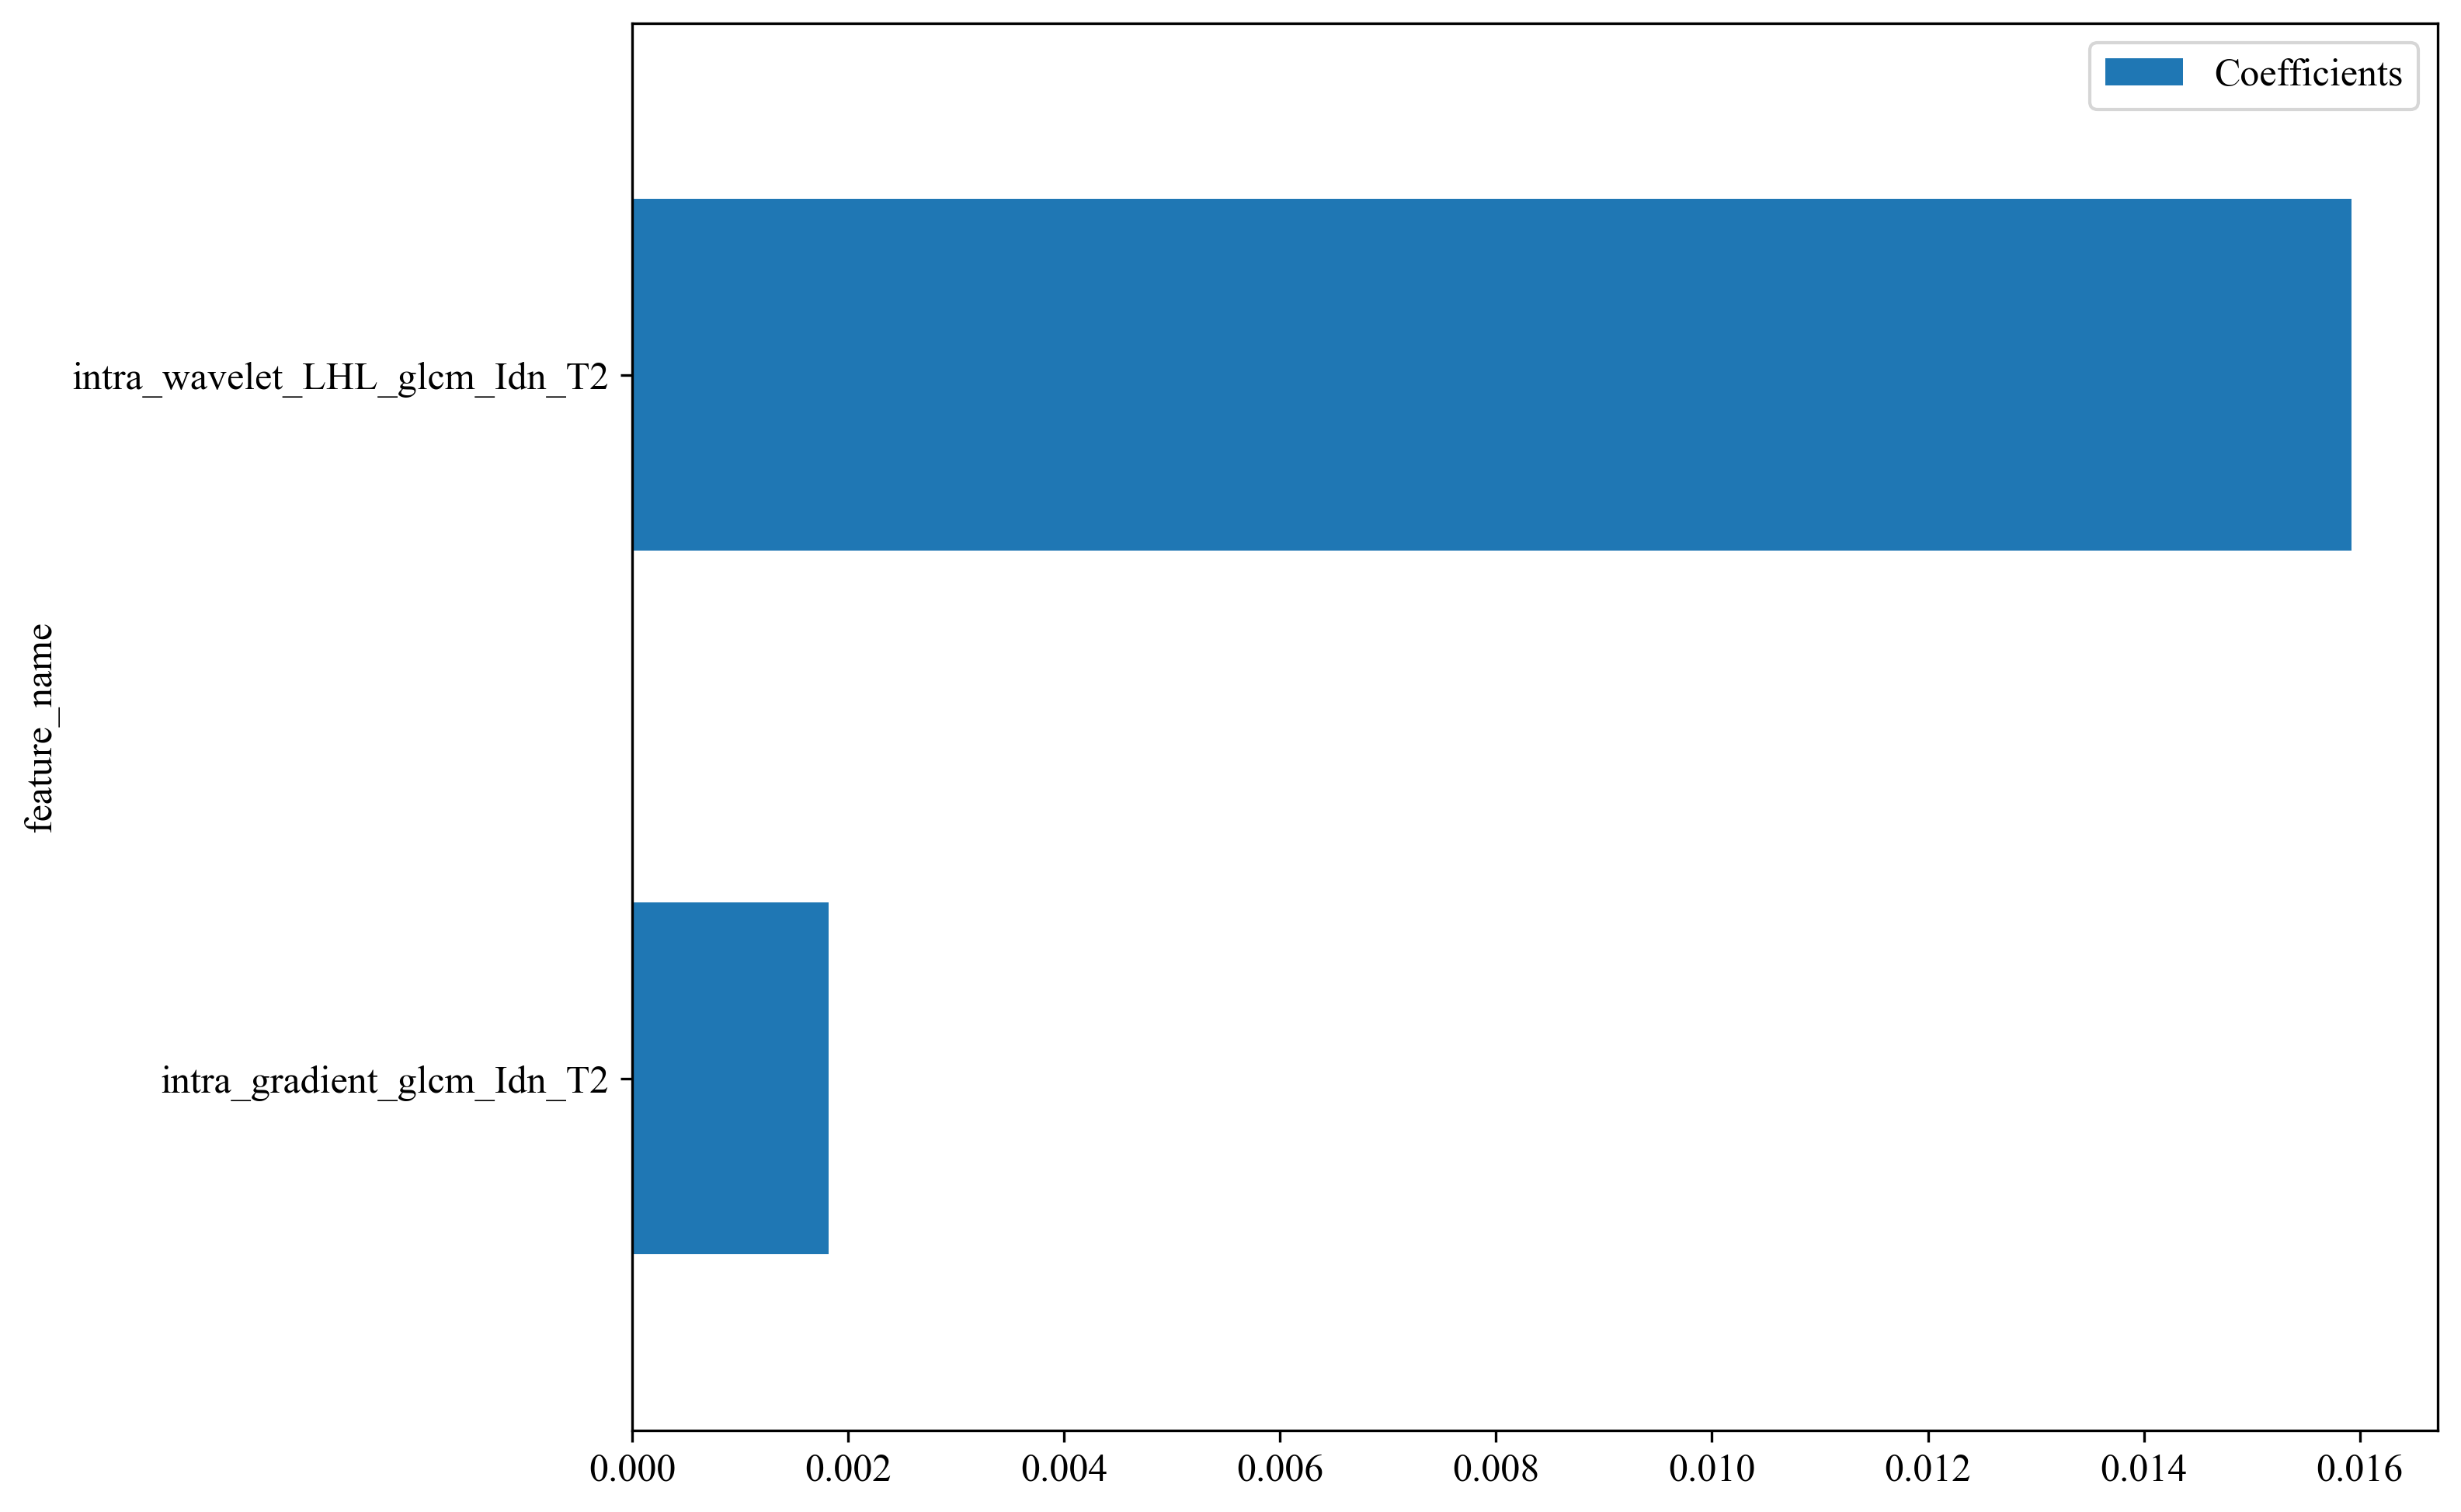

In [28]:
feat_coef = sorted(feat_coef, key=lambda x: x[1])
feat_coef_df = pd.DataFrame(feat_coef, columns=['feature_name', 'Coefficients'])
feat_coef_df.plot(x='feature_name', y='Coefficients', kind='barh')

plt.savefig(f'img/{task_type}feature_weights.svg', bbox_inches = 'tight')

### 进一步筛选特征

使用Lasso筛选出来的Coefficients比较高的特征作为训练数据。

In [29]:
X_data = X_data[selected_features[0]]
for subset in val_datasets:
    val_datasets[subset][0] = val_datasets[subset][0][selected_features[0]]
X_data.columns

Index(['intra_gradient_glcm_Idn_T2', 'intra_wavelet_LHL_glcm_Idn_T2'], dtype='object')

In [30]:
pd.concat([ids, combined_data[selected_features[0]]], axis=1).to_csv(f'features/{task_type}rad_sel_features.csv', index=False)

## 模型筛选

根据筛选出来的数据，做模型的初步选择。当前主要使用到的是Onekey中的

1. SVM，支持向量机，引用参考。
2. KNN，K紧邻，引用参考。
3. Decision Tree，决策树，引用参考。
4. Random Forests, 随机森林，引用参考。
5. XGBoost, bosting方法。引用参考。
6. LightGBM, bosting方法，引用参考。

In [31]:
import joblib
from onekey_algo.custom.components.comp1 import plot_feature_importance
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

model_names = get_param_in_cwd('ml_models')
models = okcomp.comp1.create_clf_model(model_names)
# models['LR'] = LogisticRegression(penalty='none', max_iter=100)
models['RandomForest'] = RandomForestClassifier(n_estimators=40, max_depth=4, min_samples_split=2, random_state=0)
models['XGBoost'] = XGBClassifier(n_estimators=15, objective='binary:logistic', max_depth=2, min_child_weight=1.2,
                                  use_label_encoder=False, eval_metric='error')
models['LightGBM'] = LGBMClassifier(n_estimators=24,  max_depth=2, min_child_weight=0.5,)
models['ExtraTrees'] = ExtraTreesClassifier(n_estimators=46, max_depth=4, min_samples_split=2, random_state=0)
    
model_names = list(models.keys())

### 交叉验证

`n_trails`指定随机次数，每次采用的是80%训练，随机20%进行测试，找到最好的模型，以及对应的最好的数据划分。


```python
def get_bst_split(X_data: pd.DataFrame, y_data: pd.DataFrame,
            models: dict, test_size=0.2, metric_fn=accuracy_score, n_trails=10,
            cv: bool = False, shuffle: bool = False, metric_cut_off: float = None, random_state=None):
    """
    寻找数据集中最好的数据划分。
    Args:
        X_data: 训练数据
        y_data: 监督数据
        models: 模型名称，Dict类型、
        test_size: 测试集比例，只有当cv=False时生效
        metric_fn: 评价模型好坏的函数，默认准确率，可选roc_auc_score。
        n_trails: 尝试多少次寻找最佳数据集划分。
        cv: 是否是交叉验证，默认是False，当为True时，n_trails为交叉验证的n_fold
        shuffle: 是否进行随机打乱
        metric_cut_off: 当metric_fn的值达到多少时进行截断。
        random_state: 随机种子

    Returns: {'max_idx': max_idx, "max_model": max_model, "max_metric": max_metric, "results": results}

    """
```

**注意：这里采用了【挑数据】，如果想要严谨，请修改`n_trails=1`。**

[2024-06-11 15:37:43 - comp1.py: 485]	WARNING	当cv=True的时候，采用的是交叉验证的模式，此时test_size的参数是不生效的，我们将忽略这个test_size设置。如果需要手动指定测试集比例，请修改cv=False。


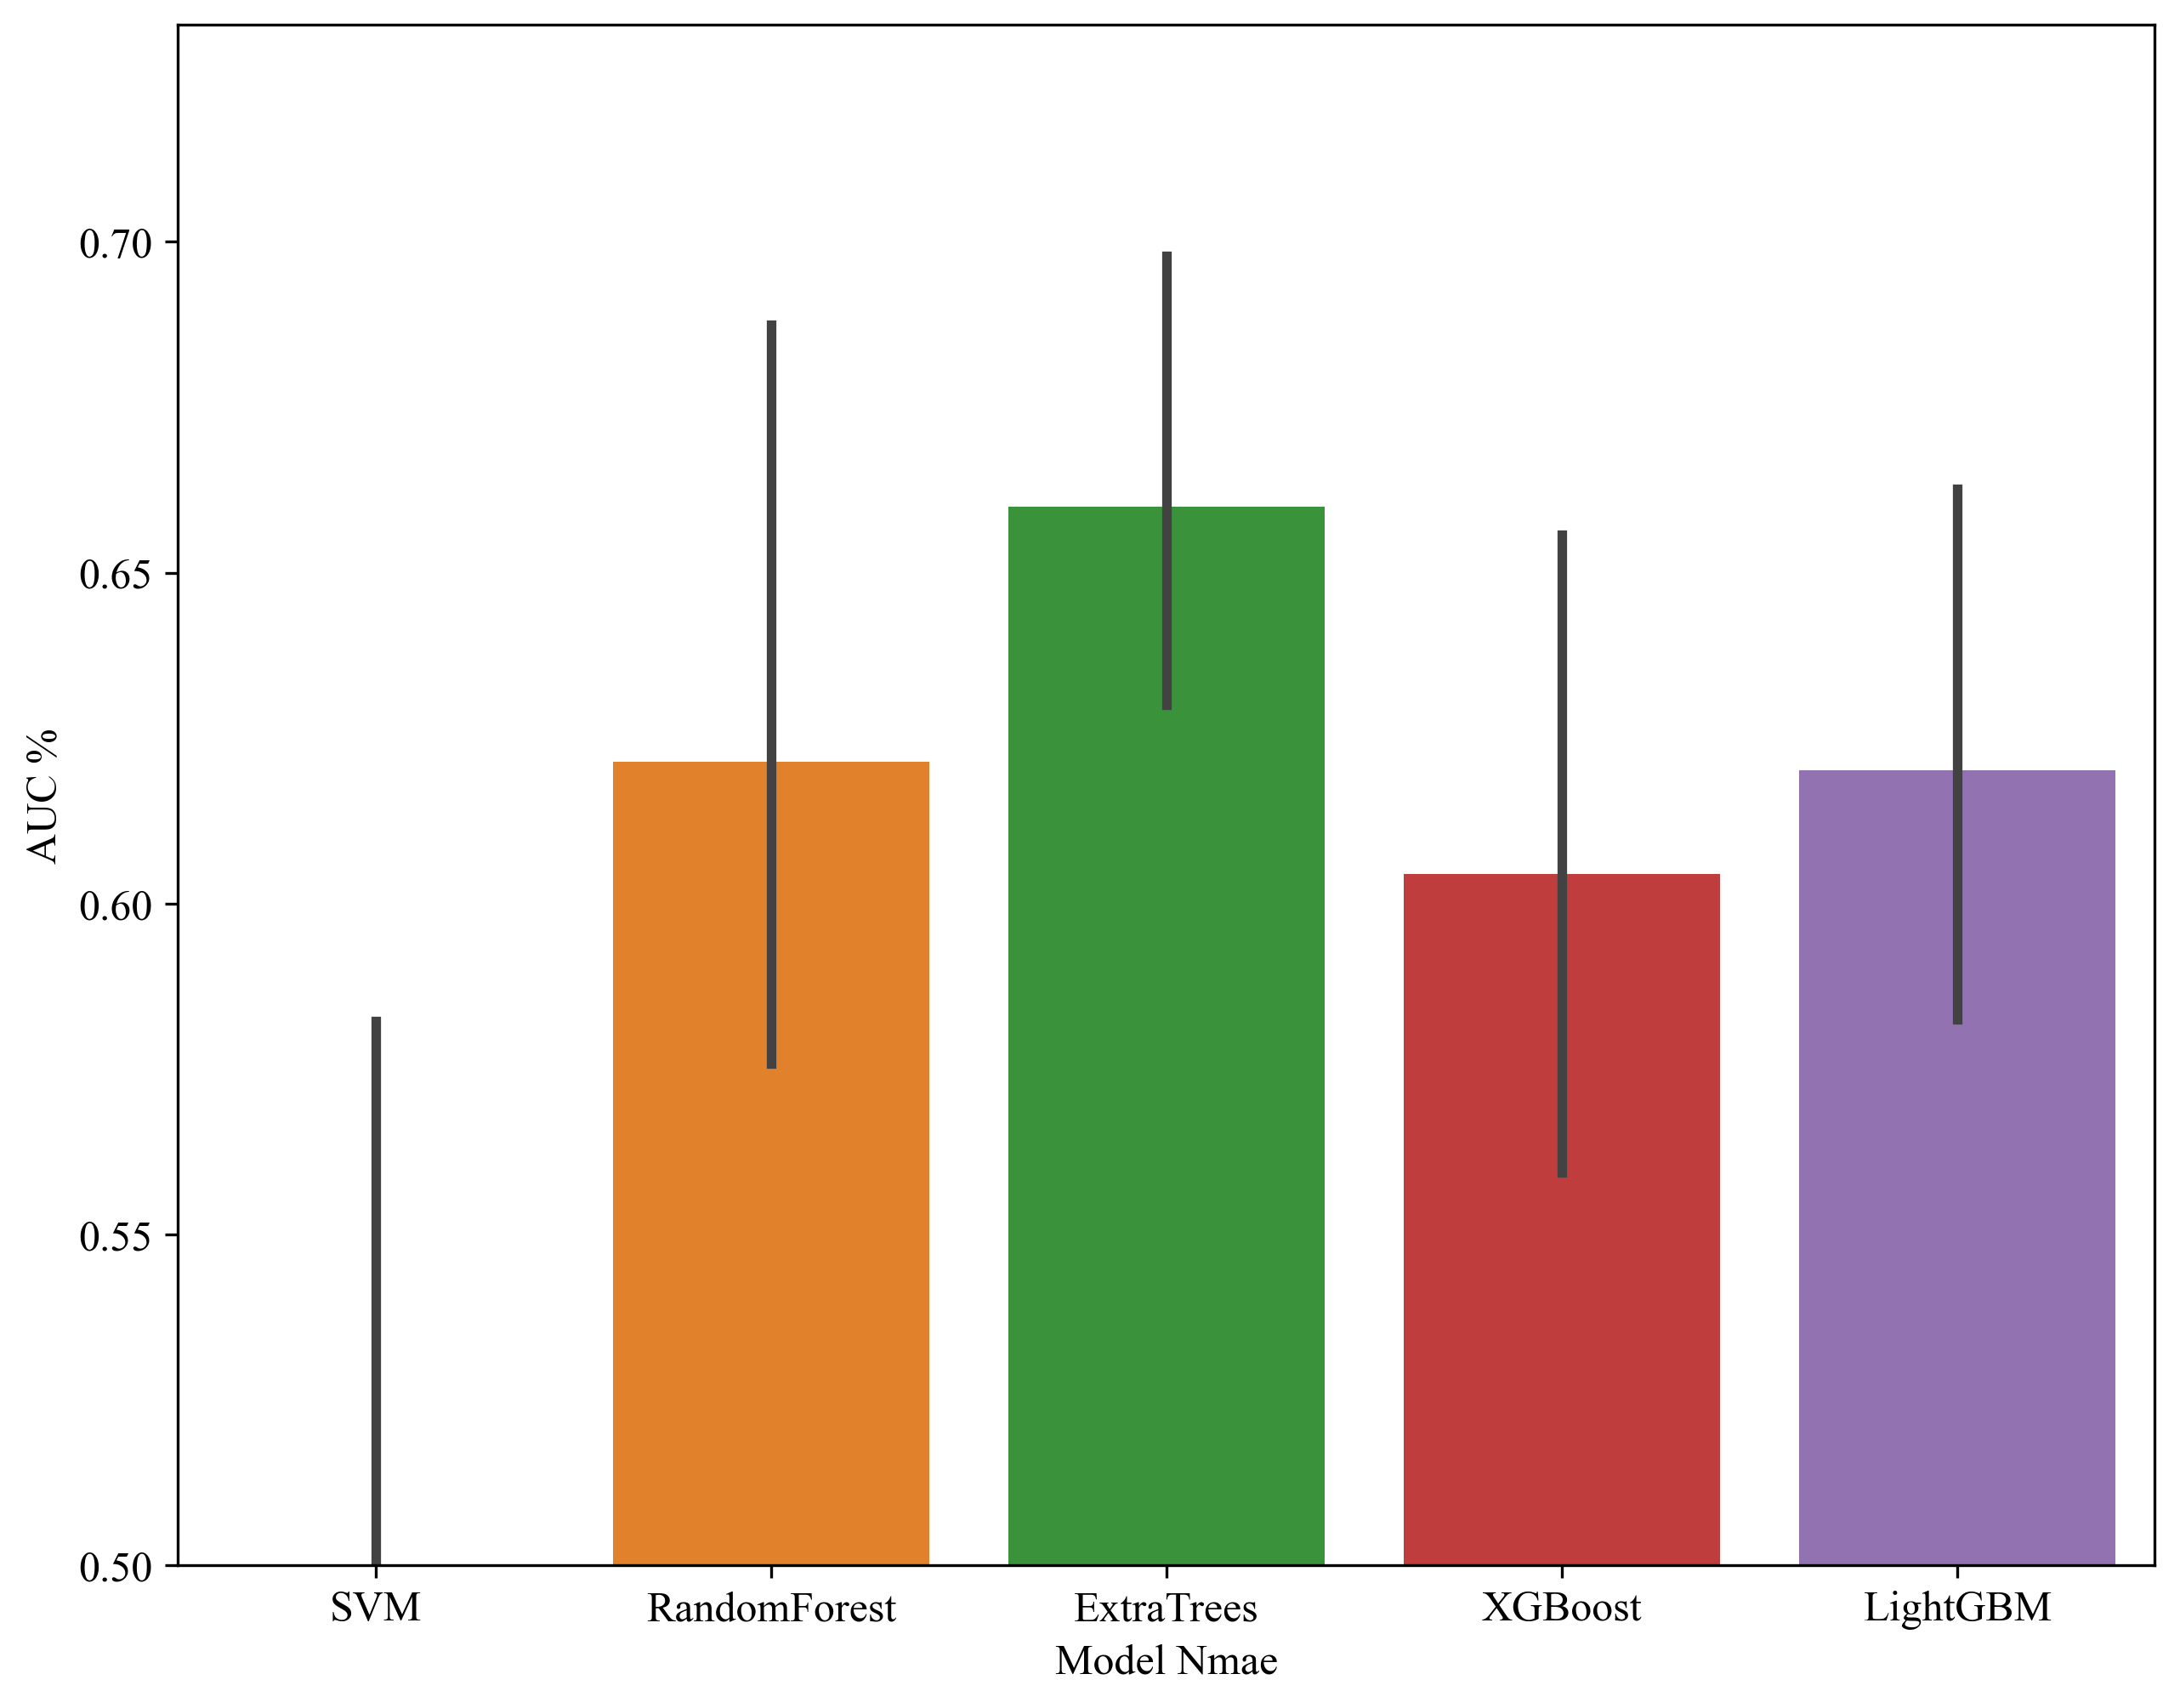

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score

# 随机使用n_trails次数据划分，找到最好的一次划分方法，并且保存在results中。
results = okcomp.comp1.get_bst_split(X_data, y_data, models, test_size=0.2, metric_fn=roc_auc_score, n_trails=5, cv=True, random_state=0)
# _, (X_train_sel, X_test_sel, y_train_sel, y_test_sel) = results['results'][results['max_idx']]
trails, _ = zip(*results['results'])
cv_results = pd.DataFrame(trails, columns=model_names)
# 可视化每个模型在不同的数据划分中的效果。
sns.barplot(data=cv_results)
plt.ylabel('AUC %')
plt.xlabel('Model Nmae')
# plt.xticks(rotation=90)
plt.ylim(0.5,)
plt.savefig(f'img/{task_type}model_cv.svg', bbox_inches = 'tight')

## 模型筛选

使用最好的数据划分，进行后续的模型研究。

**注意**: 一般情况下论文使用的是随机划分的数据，但也有些论文使用【刻意】筛选的数据划分。

In [41]:
import joblib
from onekey_algo.custom.components.comp1 import plot_feature_importance, smote_resample
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

targets = []
os.makedirs('models', exist_ok=True)
for l in labels:
    new_models = okcomp.comp1.create_clf_model(model_names)
#     new_models['LR'] = LogisticRegression(penalty='l2', max_iter=1000, C=0.1, l1_ratio=0.1)
    new_models['SVM'] = SVC(probability=True, kernel='rbf', max_iter=80, random_state=0)
    new_models['LightGBM'] = LGBMClassifier(n_estimators=5, max_depth=3, random_state=0)
    new_models['RandomForest'] = RandomForestClassifier(n_estimators=100, max_depth=2,
                                                        min_samples_split=2, random_state=0)
    new_models['ExtraTrees'] = ExtraTreesClassifier(n_estimators=18, max_depth=5, min_samples_split=2, random_state=0)
    new_models['XGBoost'] = XGBClassifier(n_estimators=16, objective='binary:logistic', max_depth=1, min_child_weight=.2,
                                              use_label_encoder=False, eval_metric='error')
    model_names = list(new_models.keys())
    new_models = list(new_models.values())
    for mn, m in zip(model_names, new_models):        
        X_train_sel, y_train_sel = X_data, y_data
        X_train_sel, y_train_sel = smote_resample(X_train_sel, y_train_sel)
        m.fit(X_train_sel, y_train_sel[l])
        # 保存训练的模型
#         joblib.dump(m, f'models/{task_type}_{mn}_{l}.pkl') 
        # 输出模型特征重要性，只针对高级树模型有用
#         plot_feature_importance(m, selected_features[0], save_dir='img', prefix=f"{task_type}_")
    targets.append(new_models)

In [46]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from onekey_algo.custom.components.delong import calc_95_CI
from onekey_algo.custom.components.metrics import analysis_pred_binary

metric = []
pred_sel_idx = []
X_train_sel, y_train_sel = X_data, y_data
predictions = [[(model.predict(X_train_sel), 
                 [(model.predict(X_val_sel), y_val_sel) for X_val_sel, y_val_sel, _ in val_datasets.values()])  
                for model in target] for label, target in zip(labels, targets)]
pred_scores = [[(model.predict_proba(X_train_sel), 
                 [(model.predict_proba(X_val_sel), y_val_sel) for X_val_sel, y_val_sel, _ in val_datasets.values()]) 
                for model in target] for label, target in zip(labels, targets)]

# predictions[0].append(dl_preds)
# pred_scores[0].append(dl_pred_scores)
# model_names.extend(['WG', 'WOG'])
for label, prediction, scores in zip(labels, predictions, pred_scores):
    for mname, (train_pred, val_preds), (train_score, val_scores) in zip(model_names, prediction, scores):
        # 计算训练集指数
        acc, auc, ci, tpr, tnr, ppv, npv, precision, recall, f1, thres = analysis_pred_binary(y_train_sel[label], 
                                                                                              train_score[:, 1])
        ci = f"{ci[0]:.3f} - {ci[1]:.3f}"
        metric.append((mname, acc, auc, ci, tpr, tnr, ppv, npv, precision, recall, f1, thres, f"train"))
        for subset, (val_score, y_val_sel) in zip(val_datasets.keys(), val_scores):
            acc, auc, ci, tpr, tnr, ppv, npv, precision, recall, f1, thres = analysis_pred_binary(y_val_sel[label], 
                                                                                                  val_score[:, 1])
            ci = f"{ci[0]:.3f} - {ci[1]:.3f}"
            metric.append((mname, acc, auc, ci, tpr, tnr, ppv, npv, precision, recall, f1, thres, f"{subset}"))
metric = pd.DataFrame(metric, index=None, columns=['model_name', 'Accuracy', 'AUC', '95% CI',
                                                   'Sensitivity', 'Specificity', 'PPV', 'NPV', 'Precision', 'Recall', 'F1',
                                                   'Threshold', 'Cohort'])
metric

[2024-06-11 16:24:29 - metrics.py: 287]	INFO	use_youden index: False
[2024-06-11 16:24:29 - metrics.py: 287]	INFO	use_youden index: False
[2024-06-11 16:24:29 - metrics.py: 287]	INFO	use_youden index: False
[2024-06-11 16:24:29 - metrics.py: 287]	INFO	use_youden index: False
[2024-06-11 16:24:29 - metrics.py: 287]	INFO	use_youden index: False
[2024-06-11 16:24:29 - metrics.py: 287]	INFO	use_youden index: False
[2024-06-11 16:24:29 - metrics.py: 287]	INFO	use_youden index: False
[2024-06-11 16:24:29 - metrics.py: 287]	INFO	use_youden index: False
[2024-06-11 16:24:29 - metrics.py: 287]	INFO	use_youden index: False
[2024-06-11 16:24:29 - metrics.py: 287]	INFO	use_youden index: False


model_name  Accuracy    AUC         95% CI  Sensitivity  Specificity  \
0           SVM     0.736  0.615  0.531 - 0.698        0.856        0.328   
1           SVM     0.733  0.613  0.479 - 0.746        0.933        0.161   
2  RandomForest     0.629  0.732  0.662 - 0.801        0.606        0.703   
3  RandomForest     0.717  0.726  0.620 - 0.832        0.753        0.613   
4    ExtraTrees     0.732  0.761  0.695 - 0.827        0.759        0.641   
5    ExtraTrees     0.742  0.732  0.630 - 0.834        0.843        0.452   
6       XGBoost     0.625  0.720  0.652 - 0.787        0.602        0.703   
7       XGBoost     0.717  0.716  0.612 - 0.820        0.753        0.613   
8      LightGBM     0.668  0.728  0.662 - 0.795        0.671        0.656   
9      LightGBM     0.692  0.660  0.543 - 0.776        0.753        0.516   

     PPV    NPV  Precision  Recall     F1  Threshold Cohort  
0  0.811  0.404      0.811   0.856  0.833      0.531  train  
1  0.761  0.455      0.761   0.933  0.838      0.548   test  
2  0.873  0.346      0.873   0.606  0.716      0.463  train  
3  0.848  0.463      0.848   0.753  0.798      0.482   test  
4  0.877  0.441      0.877   0.759  0.814      0.495  train  
5  0.815  0.500      0.815   0.843  0.829      0.534   test  
6  0.872  0.344      0.872   0.602  0.712      0.586  train  
7  0.848  0.463      0.848   0.753  0.798      0.564   test  
8  0.868  0.372      0.868   0.671  0.757      0.536  train  
9  0.817  0.421      0.817   0.753  0.784      0.502   test

### 绘制曲线

绘制的不同模型的准确率柱状图和折线图曲线。

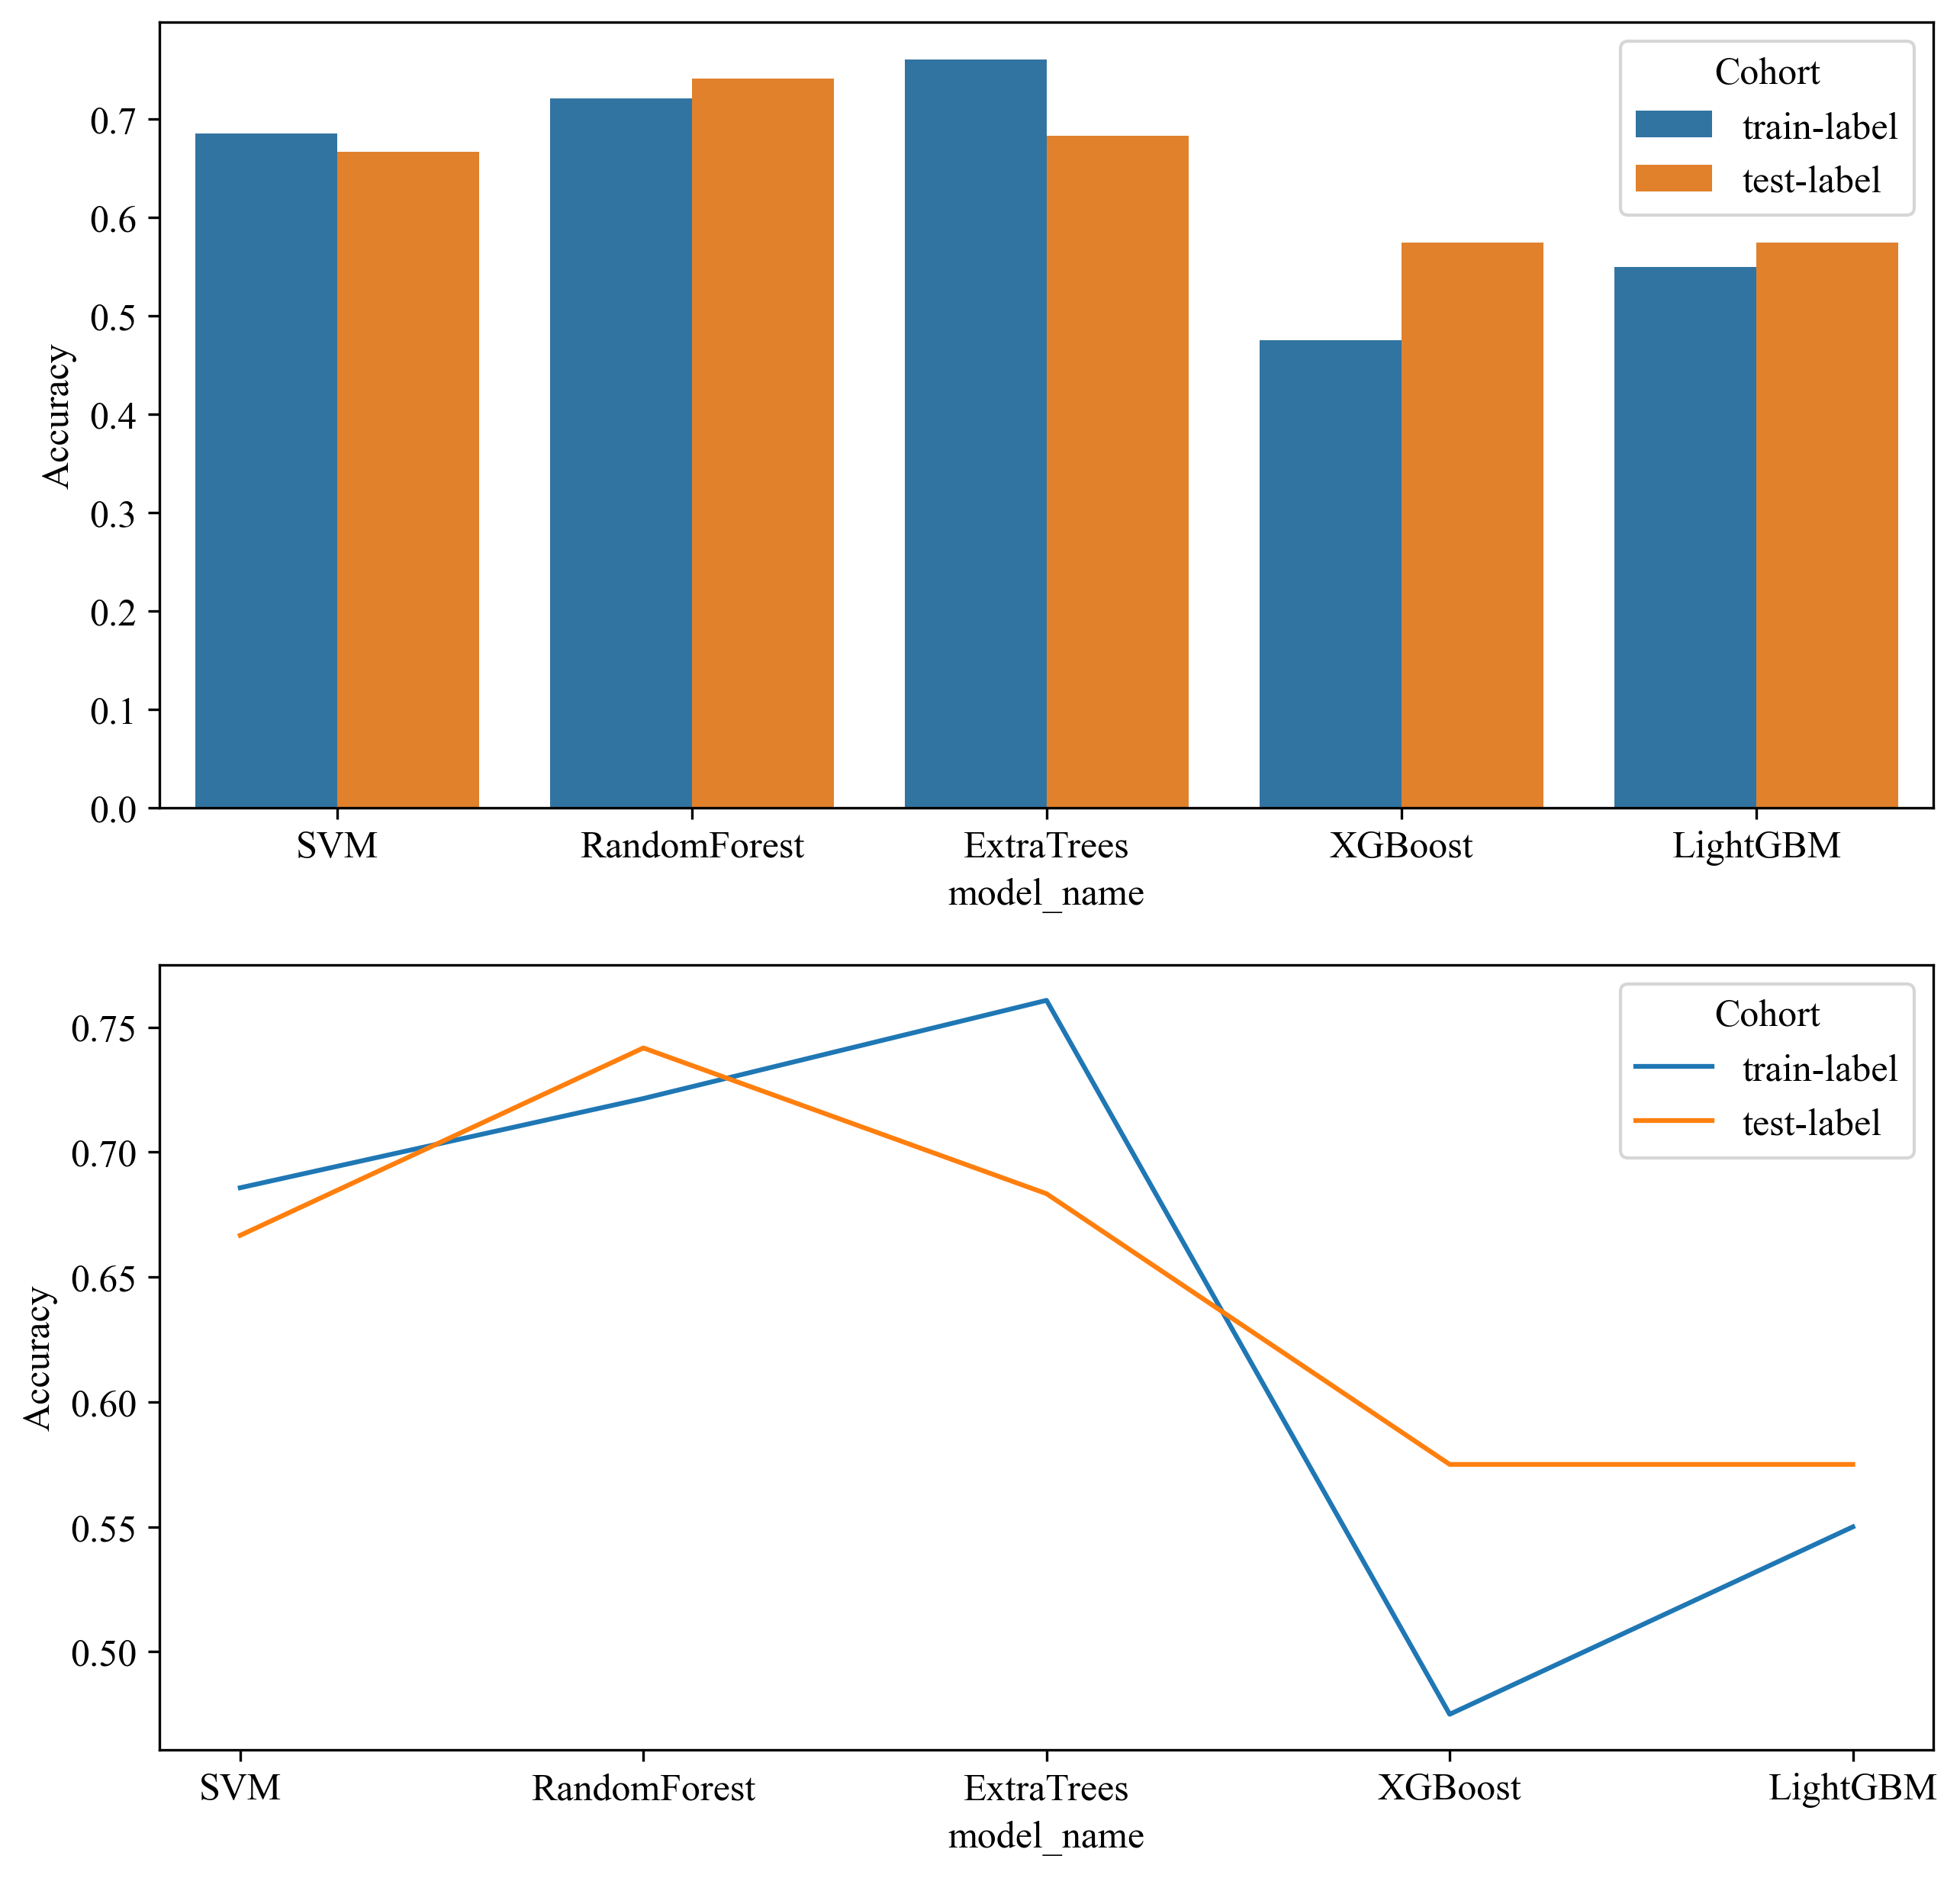

In [43]:
import seaborn as sns

plt.figure(figsize=(10, 10))
plt.subplot(211)
sns.barplot(x='model_name', y='Accuracy', data=metric, hue='Cohort')
plt.subplot(212)
sns.lineplot(x='model_name', y='Accuracy', data=metric, hue='Cohort')
plt.savefig(f'img/{task_type}model_acc.svg', bbox_inches = 'tight')

### 绘制ROC曲线
确定最好的模型，并且绘制曲线。

```python
def draw_roc(y_test, y_score, title='ROC', labels=None):
```

`sel_model = ['SVM', 'KNN']`参数为想要绘制的模型对应的参数。

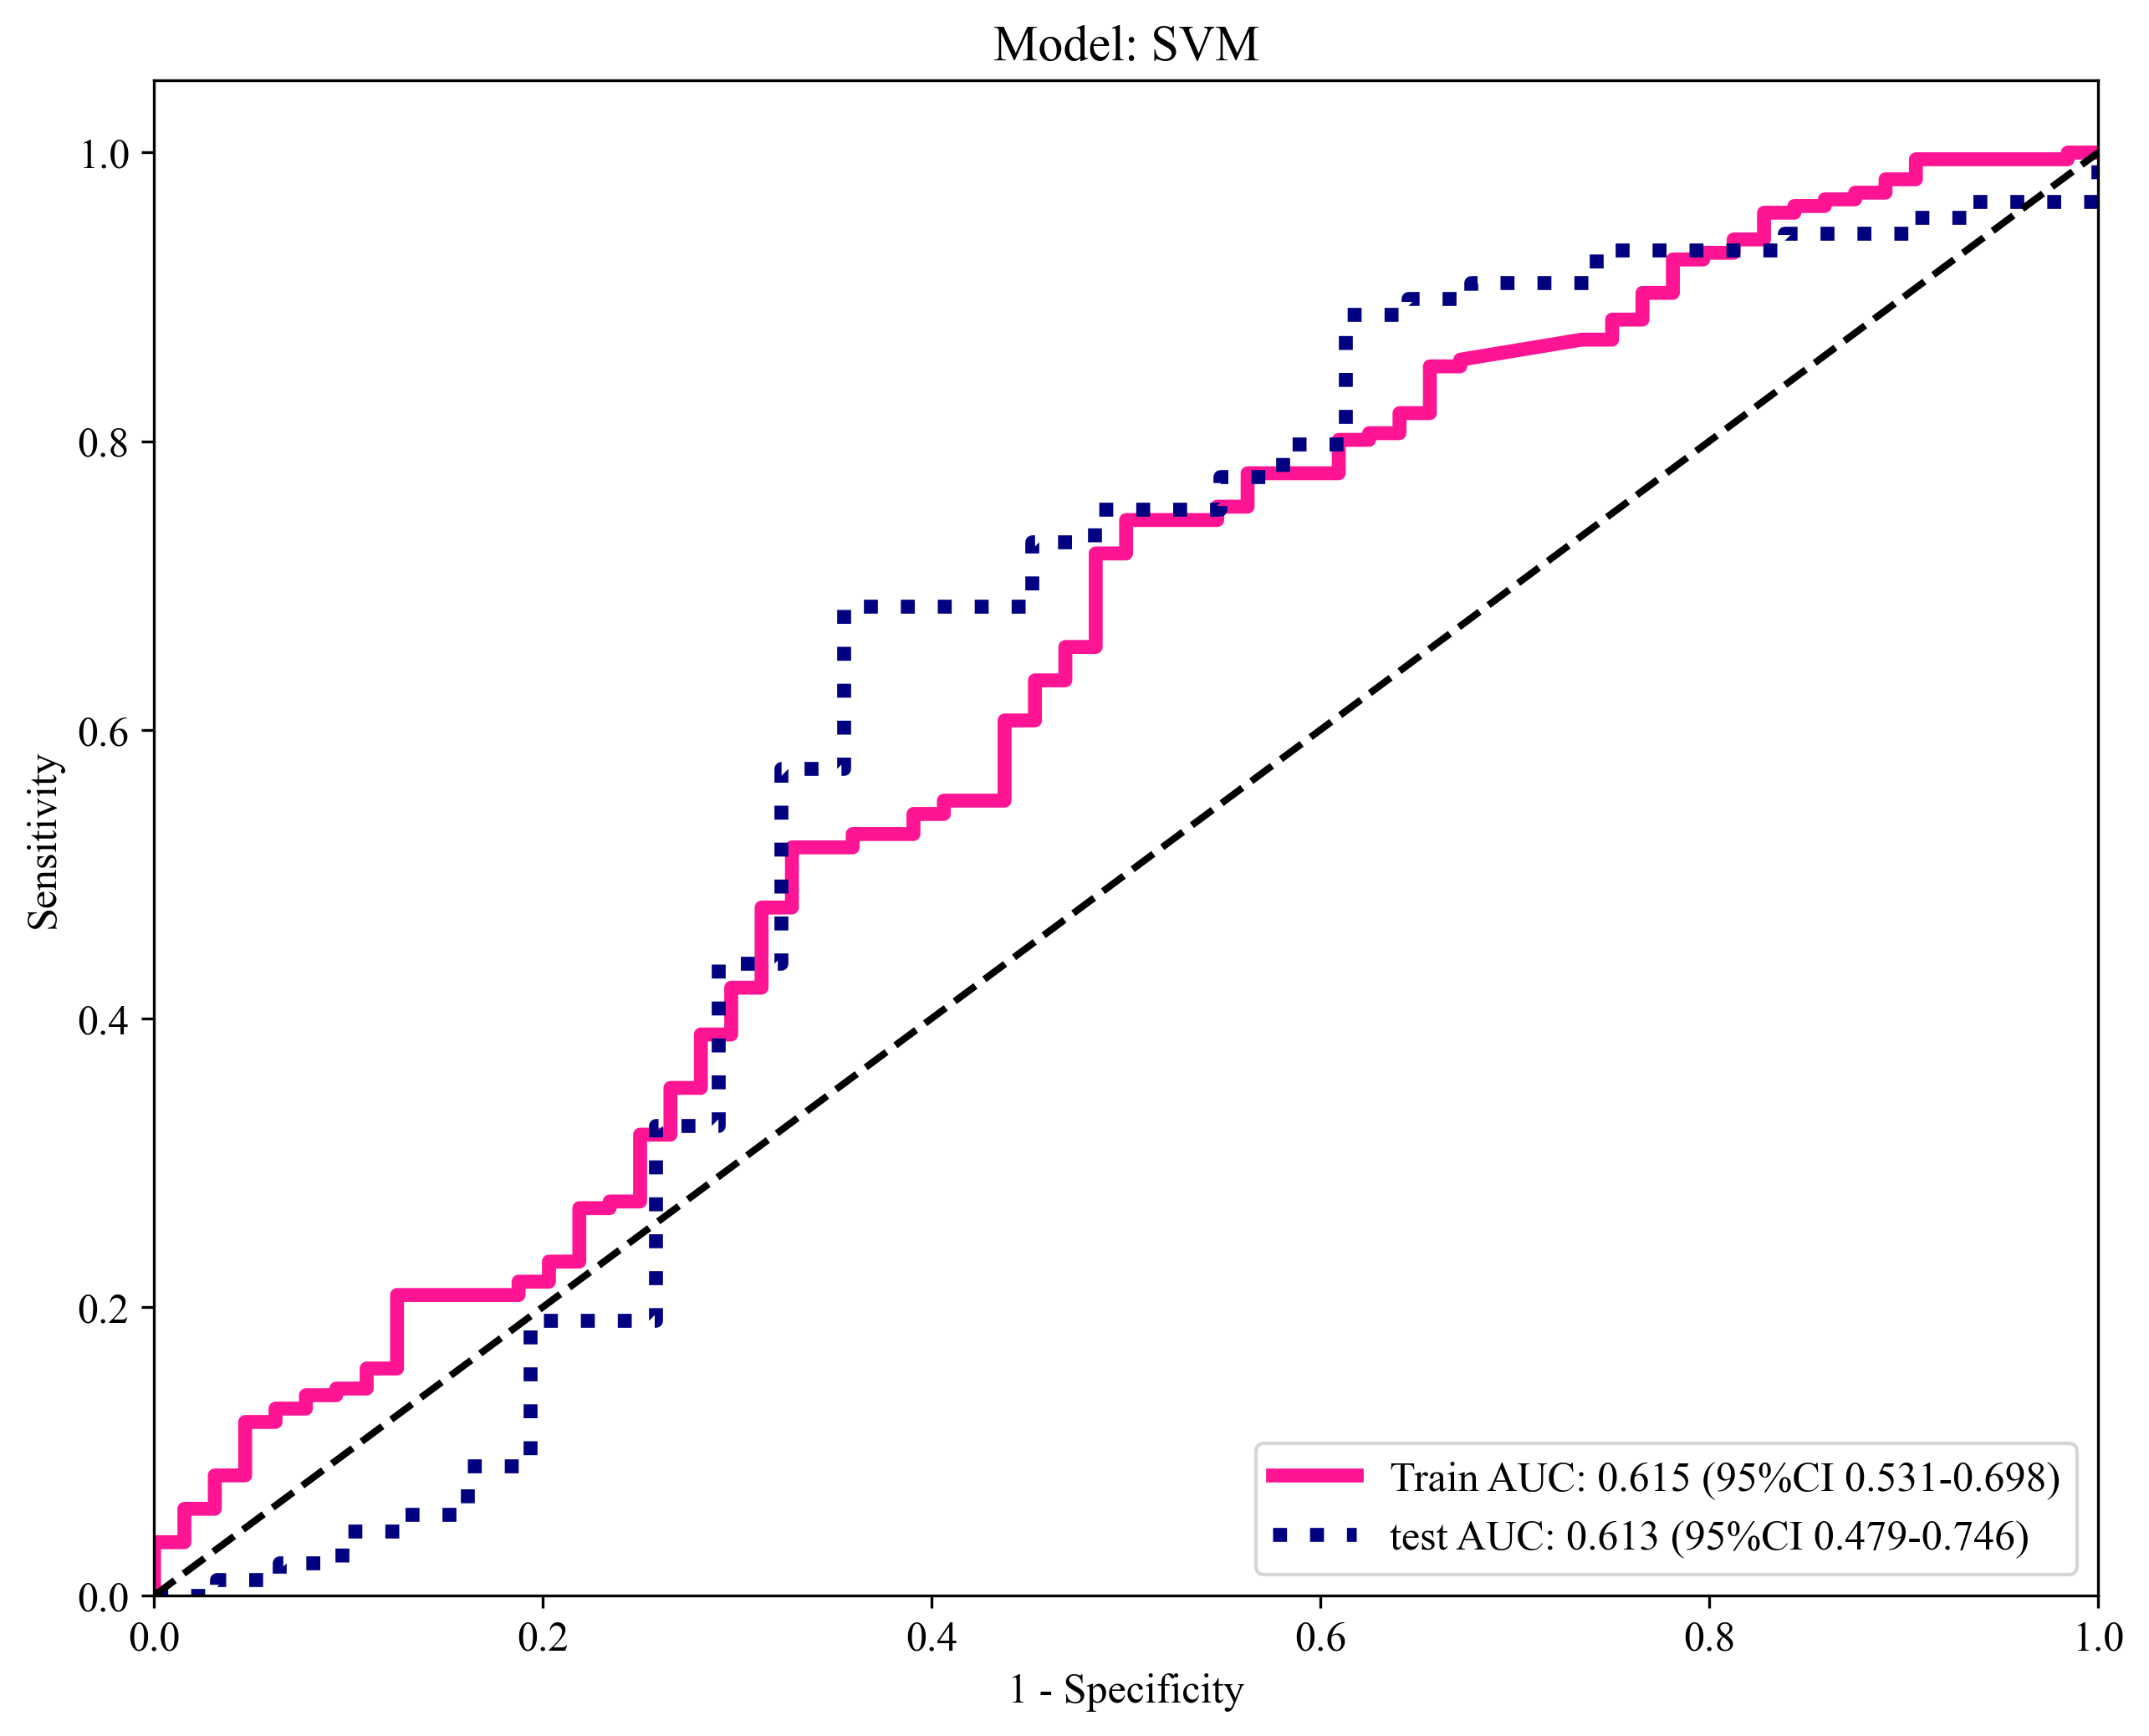

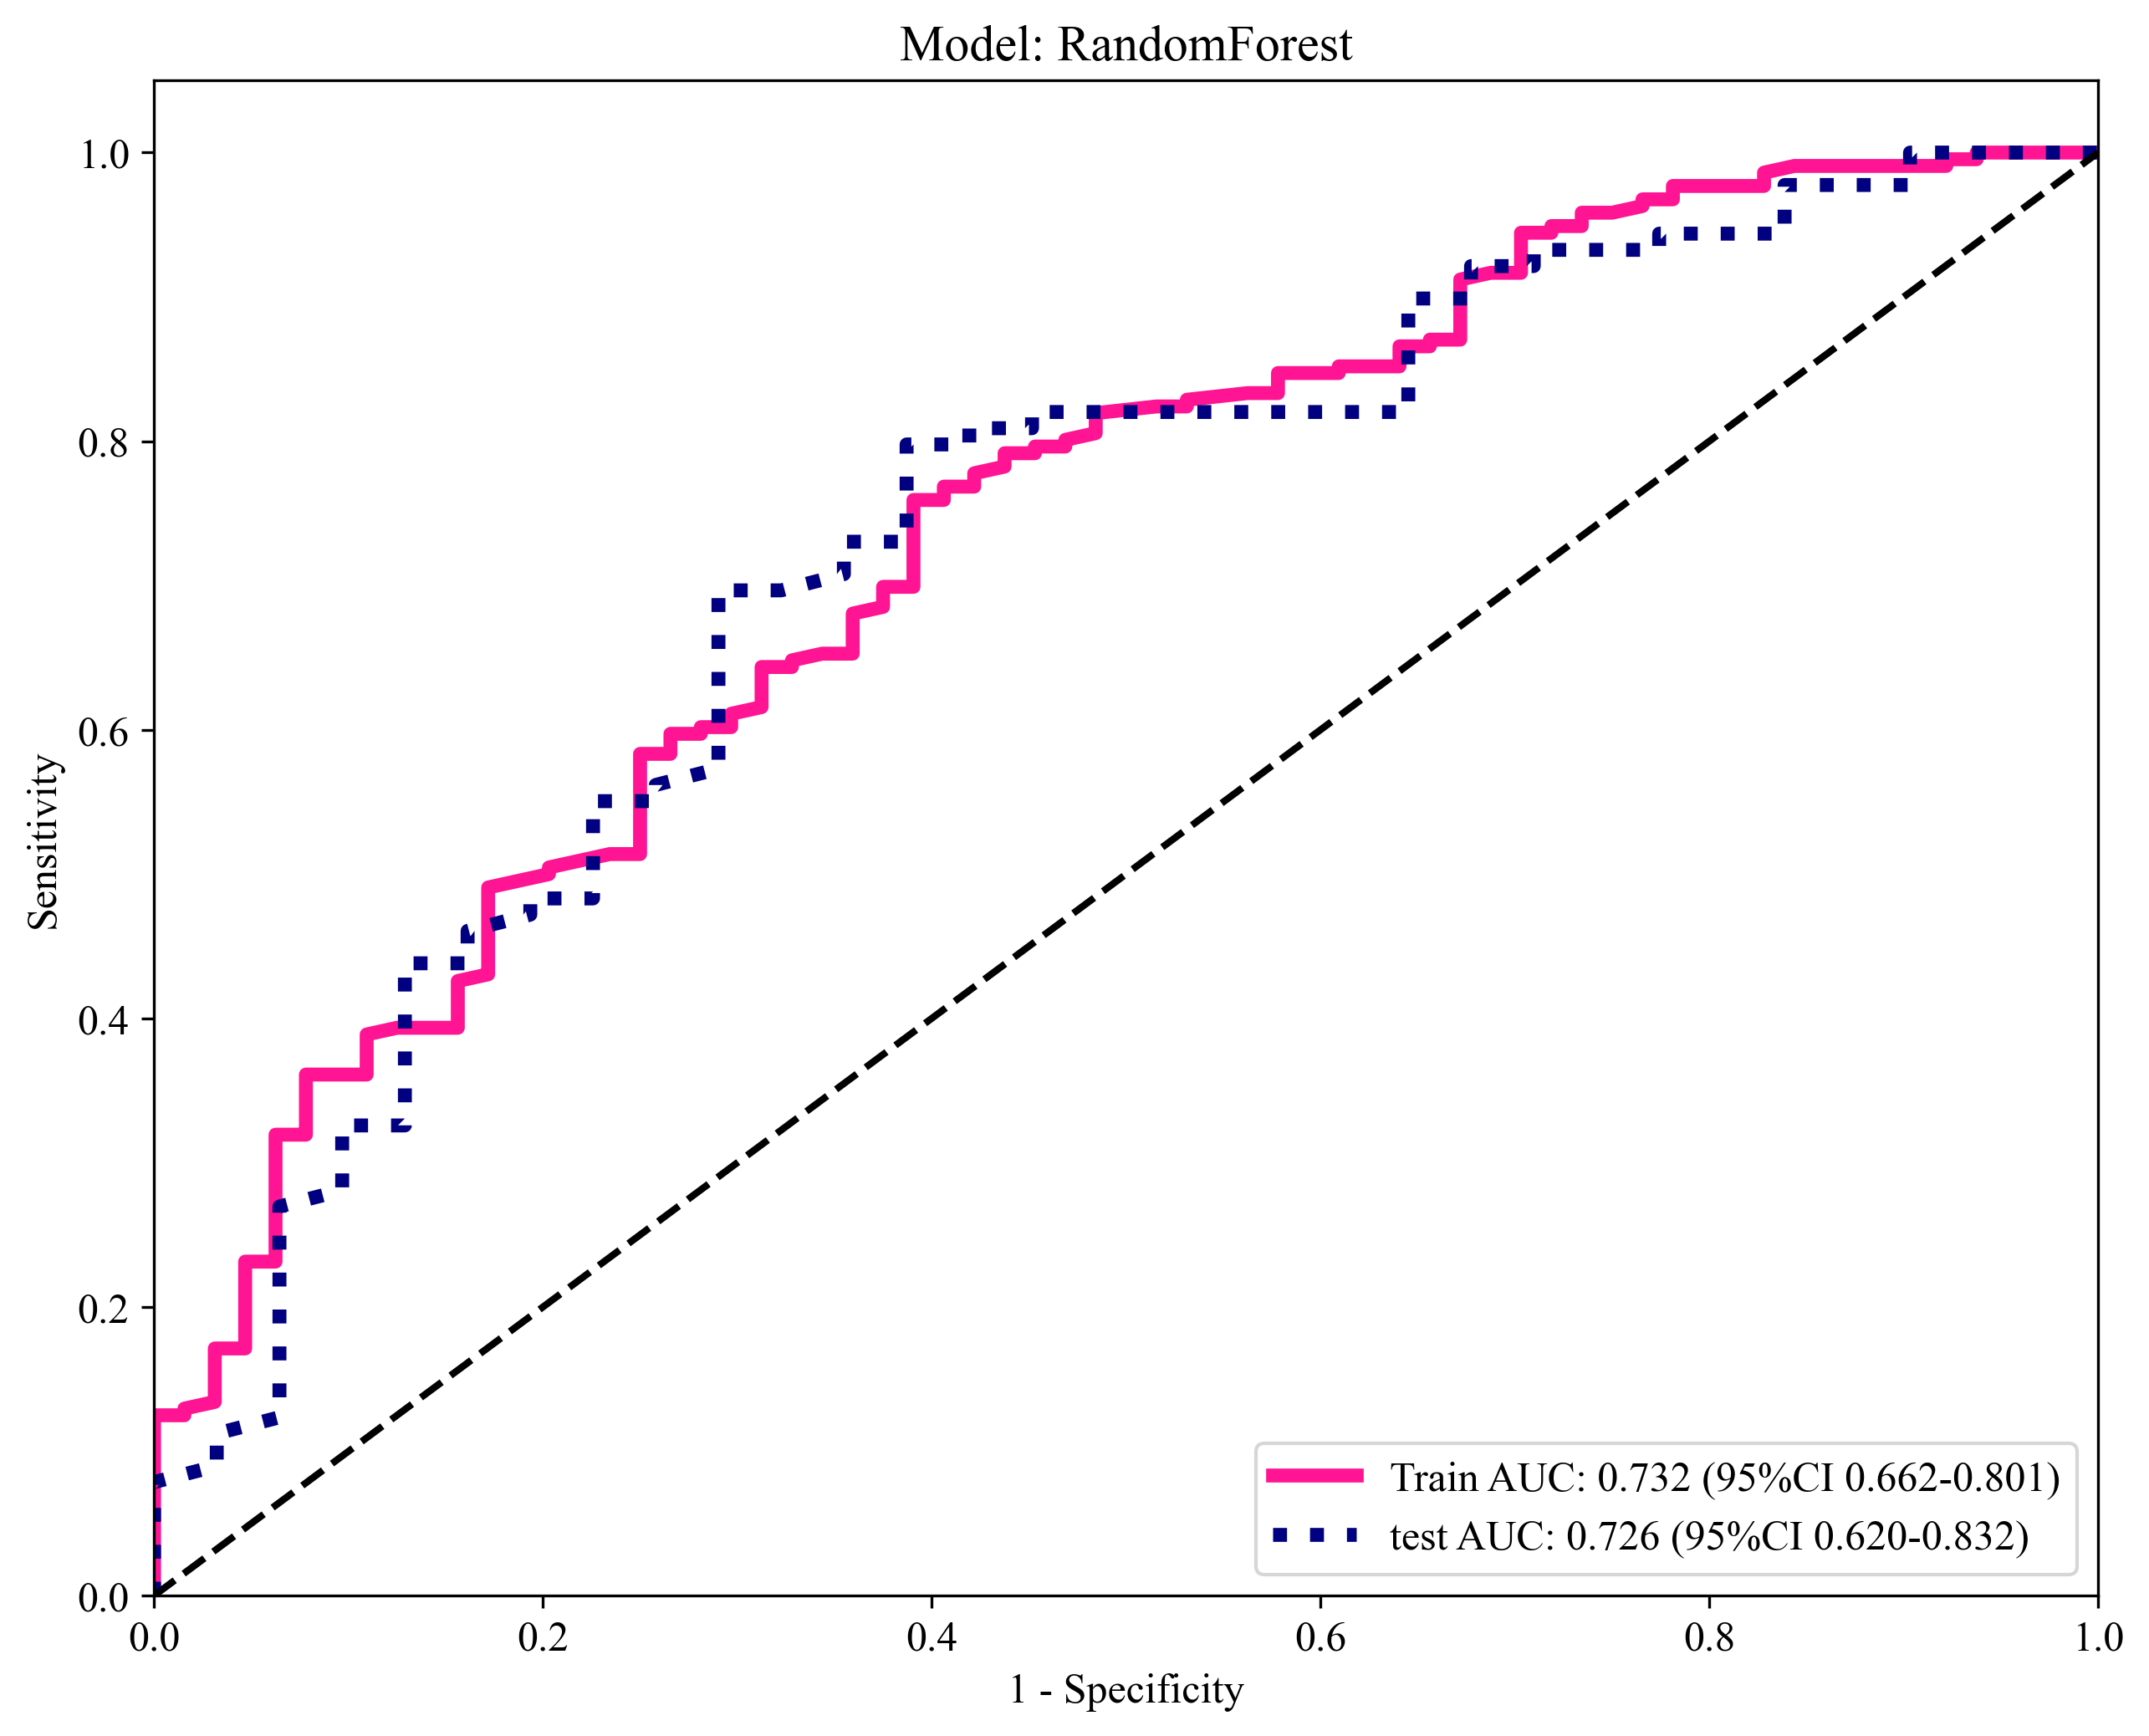

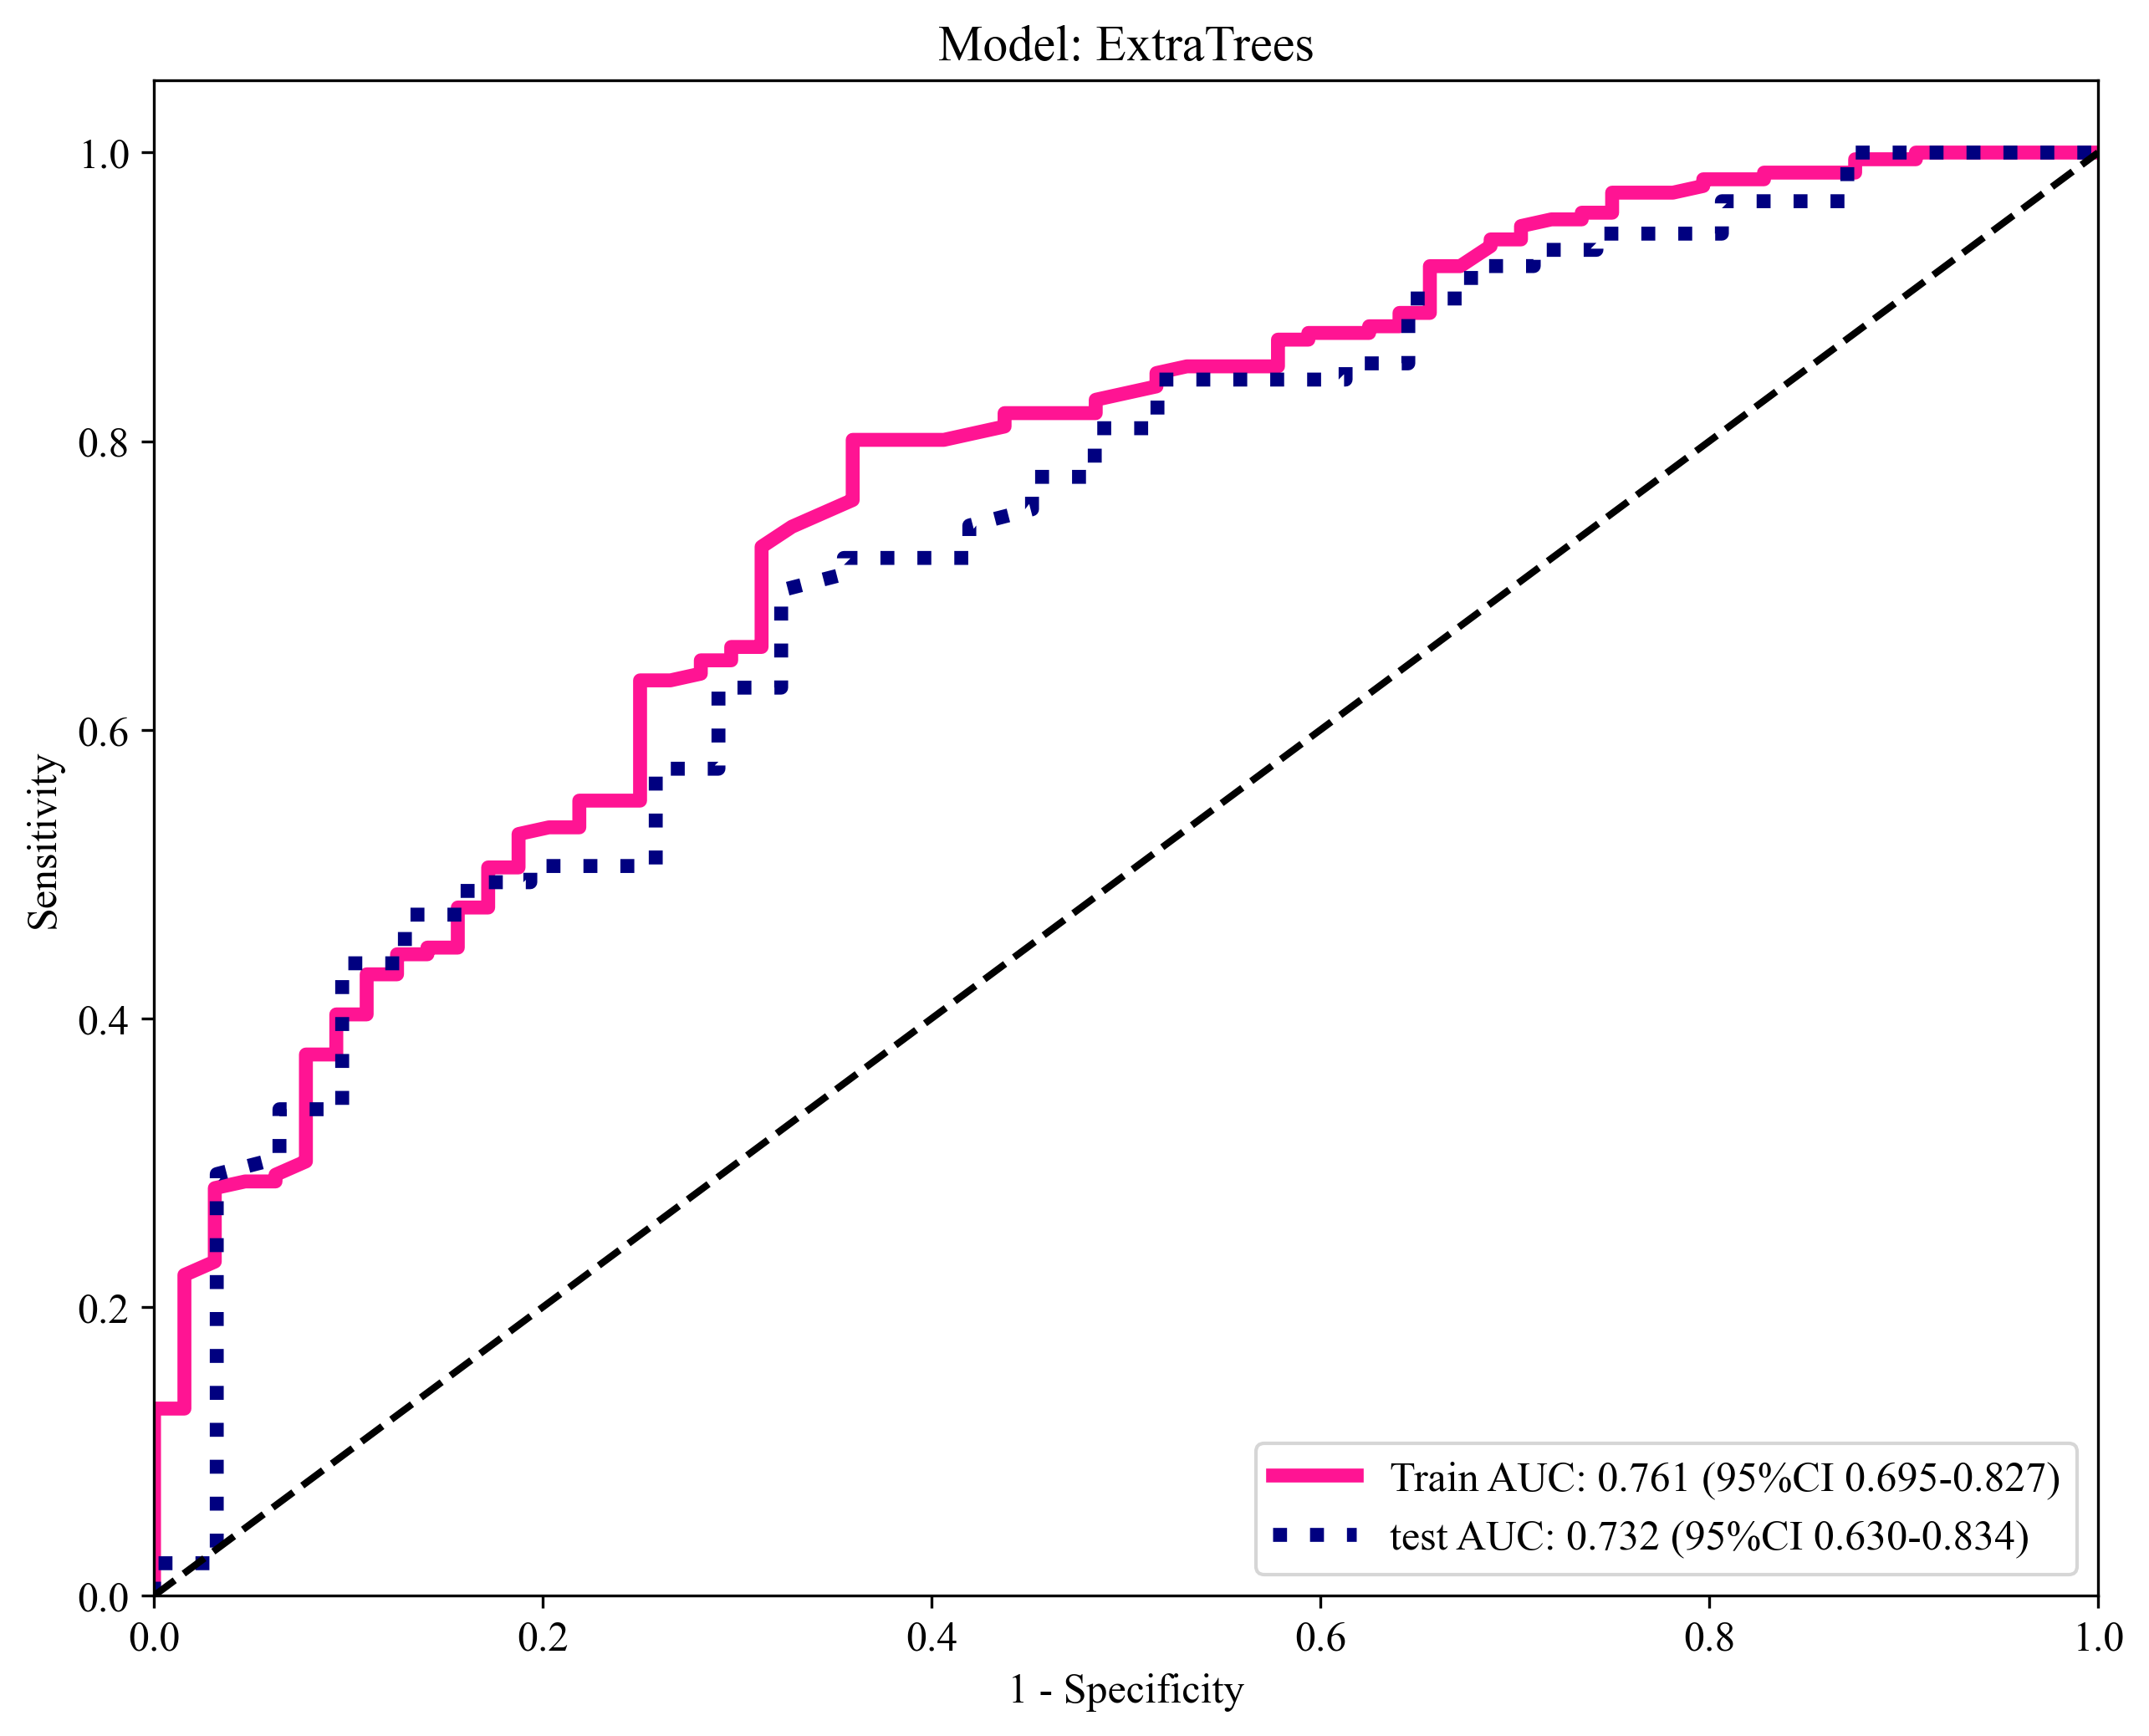

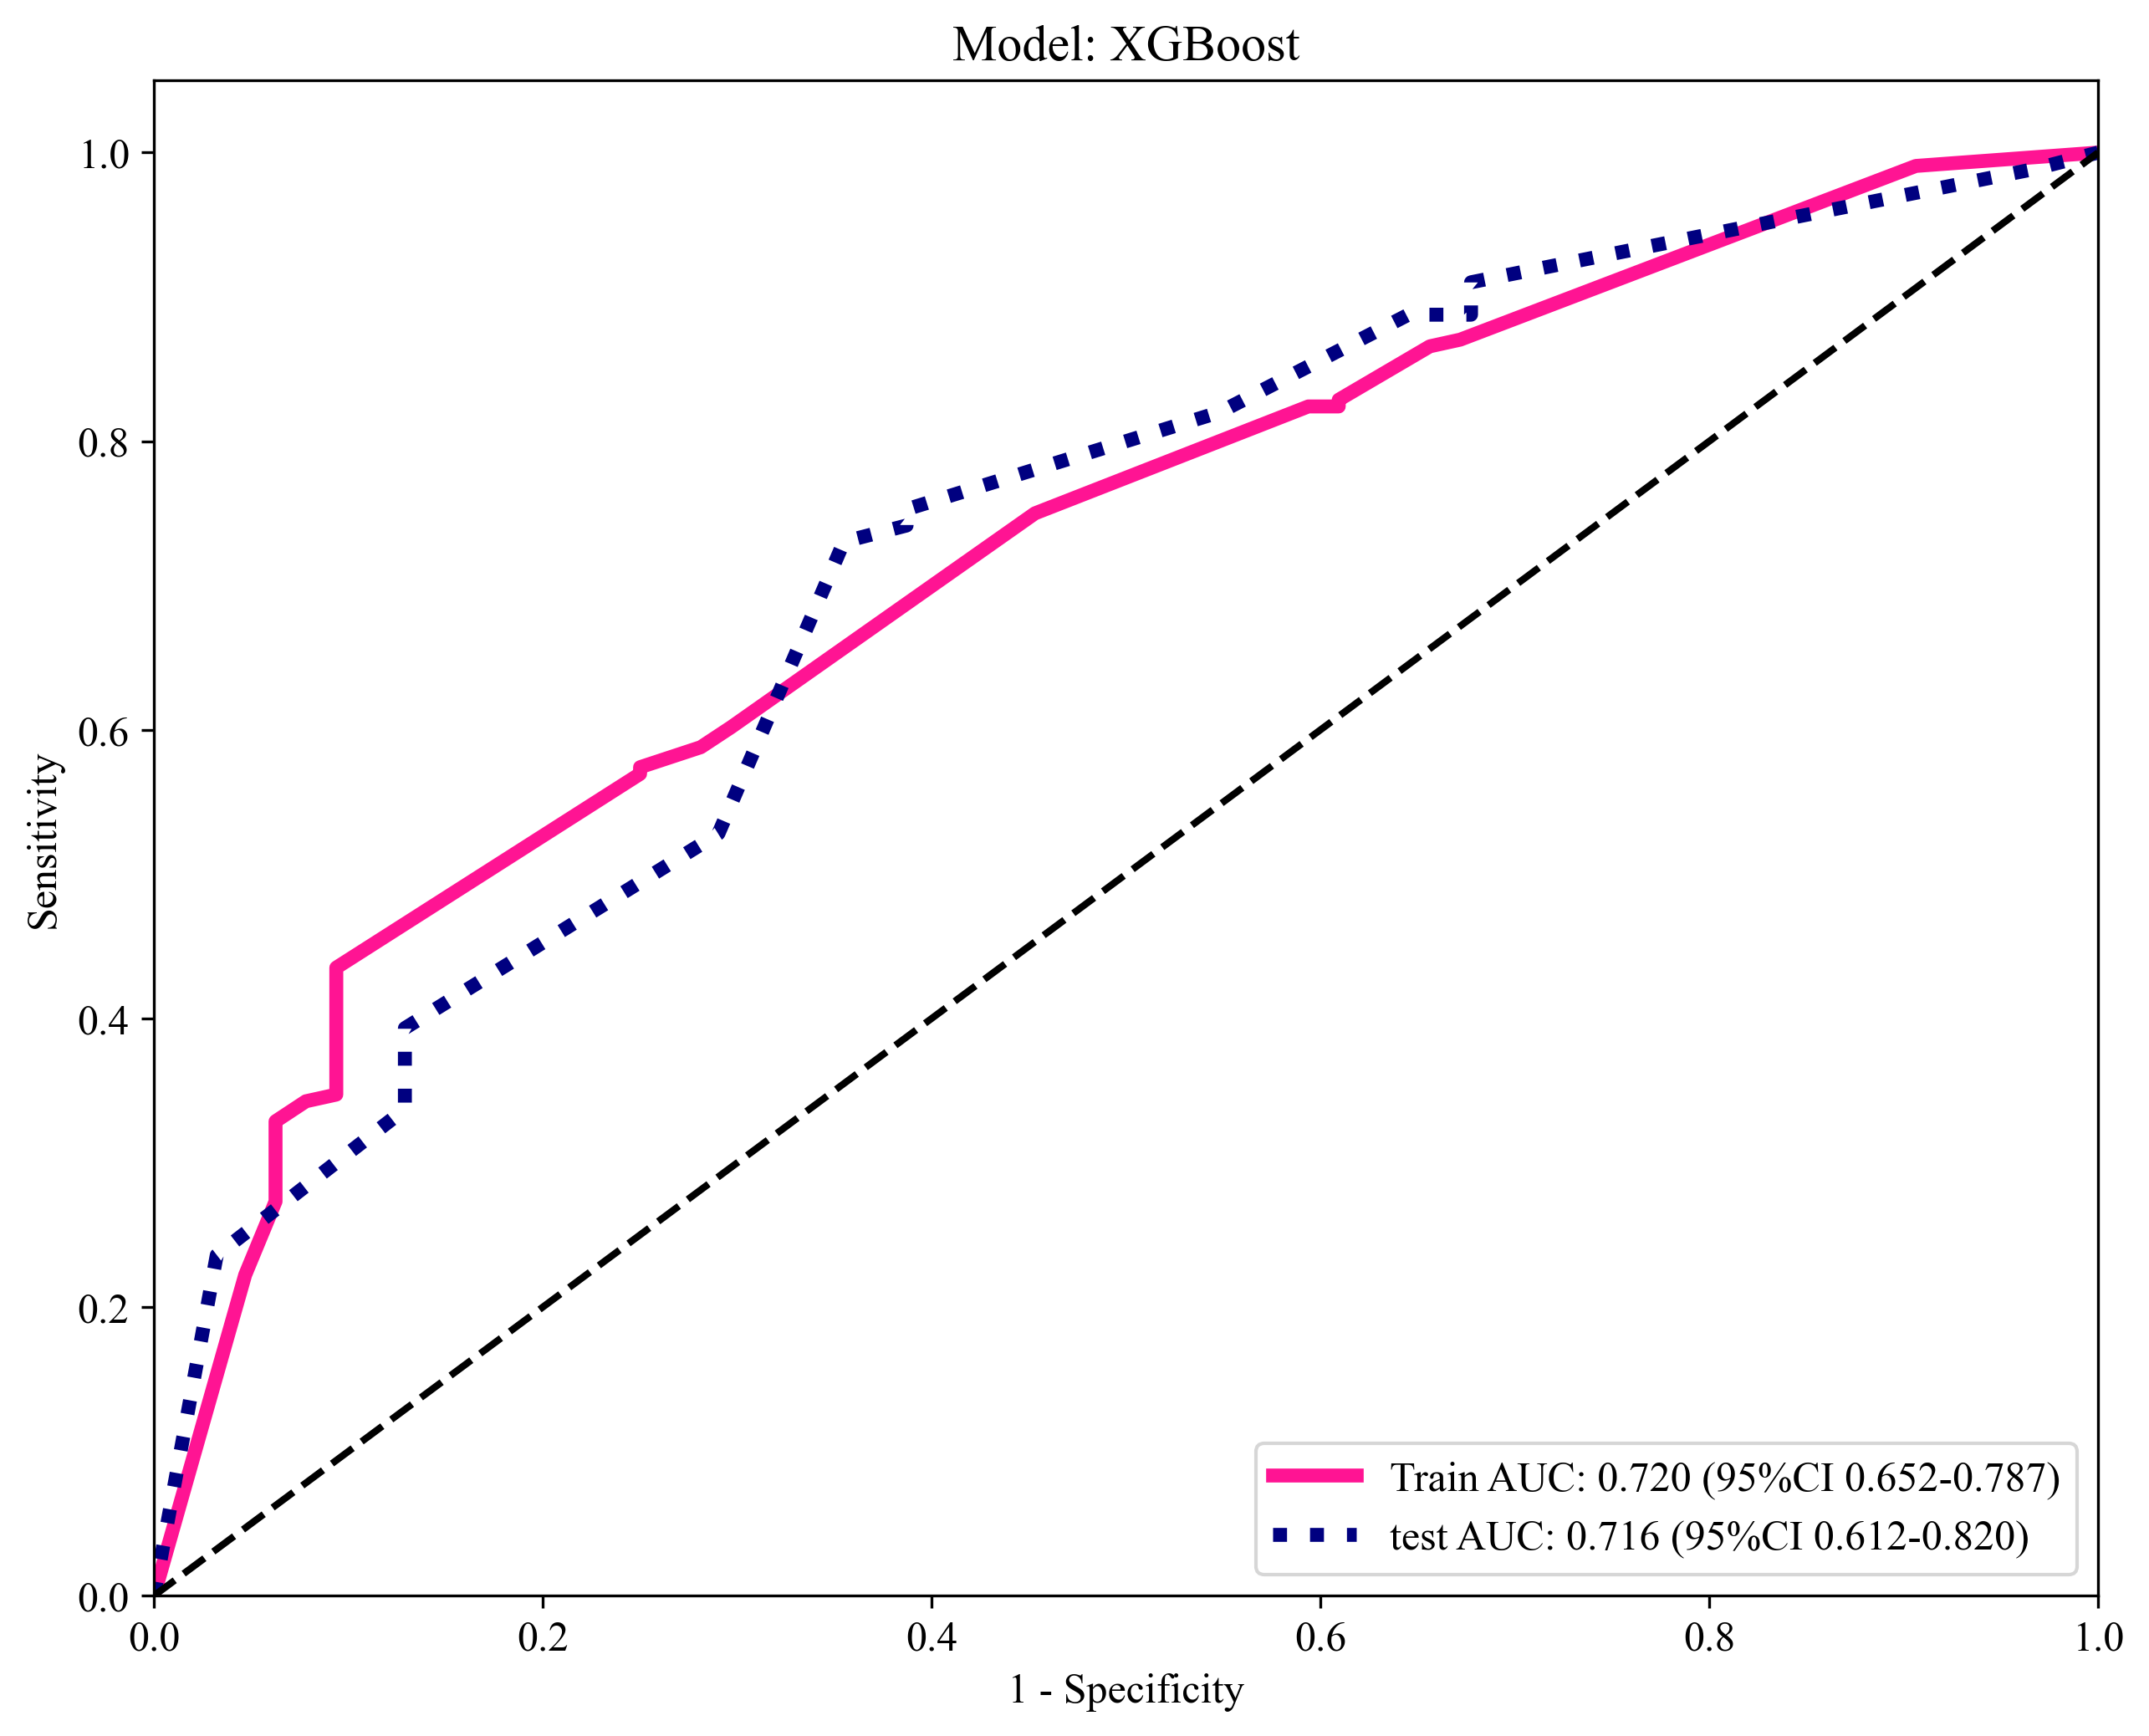

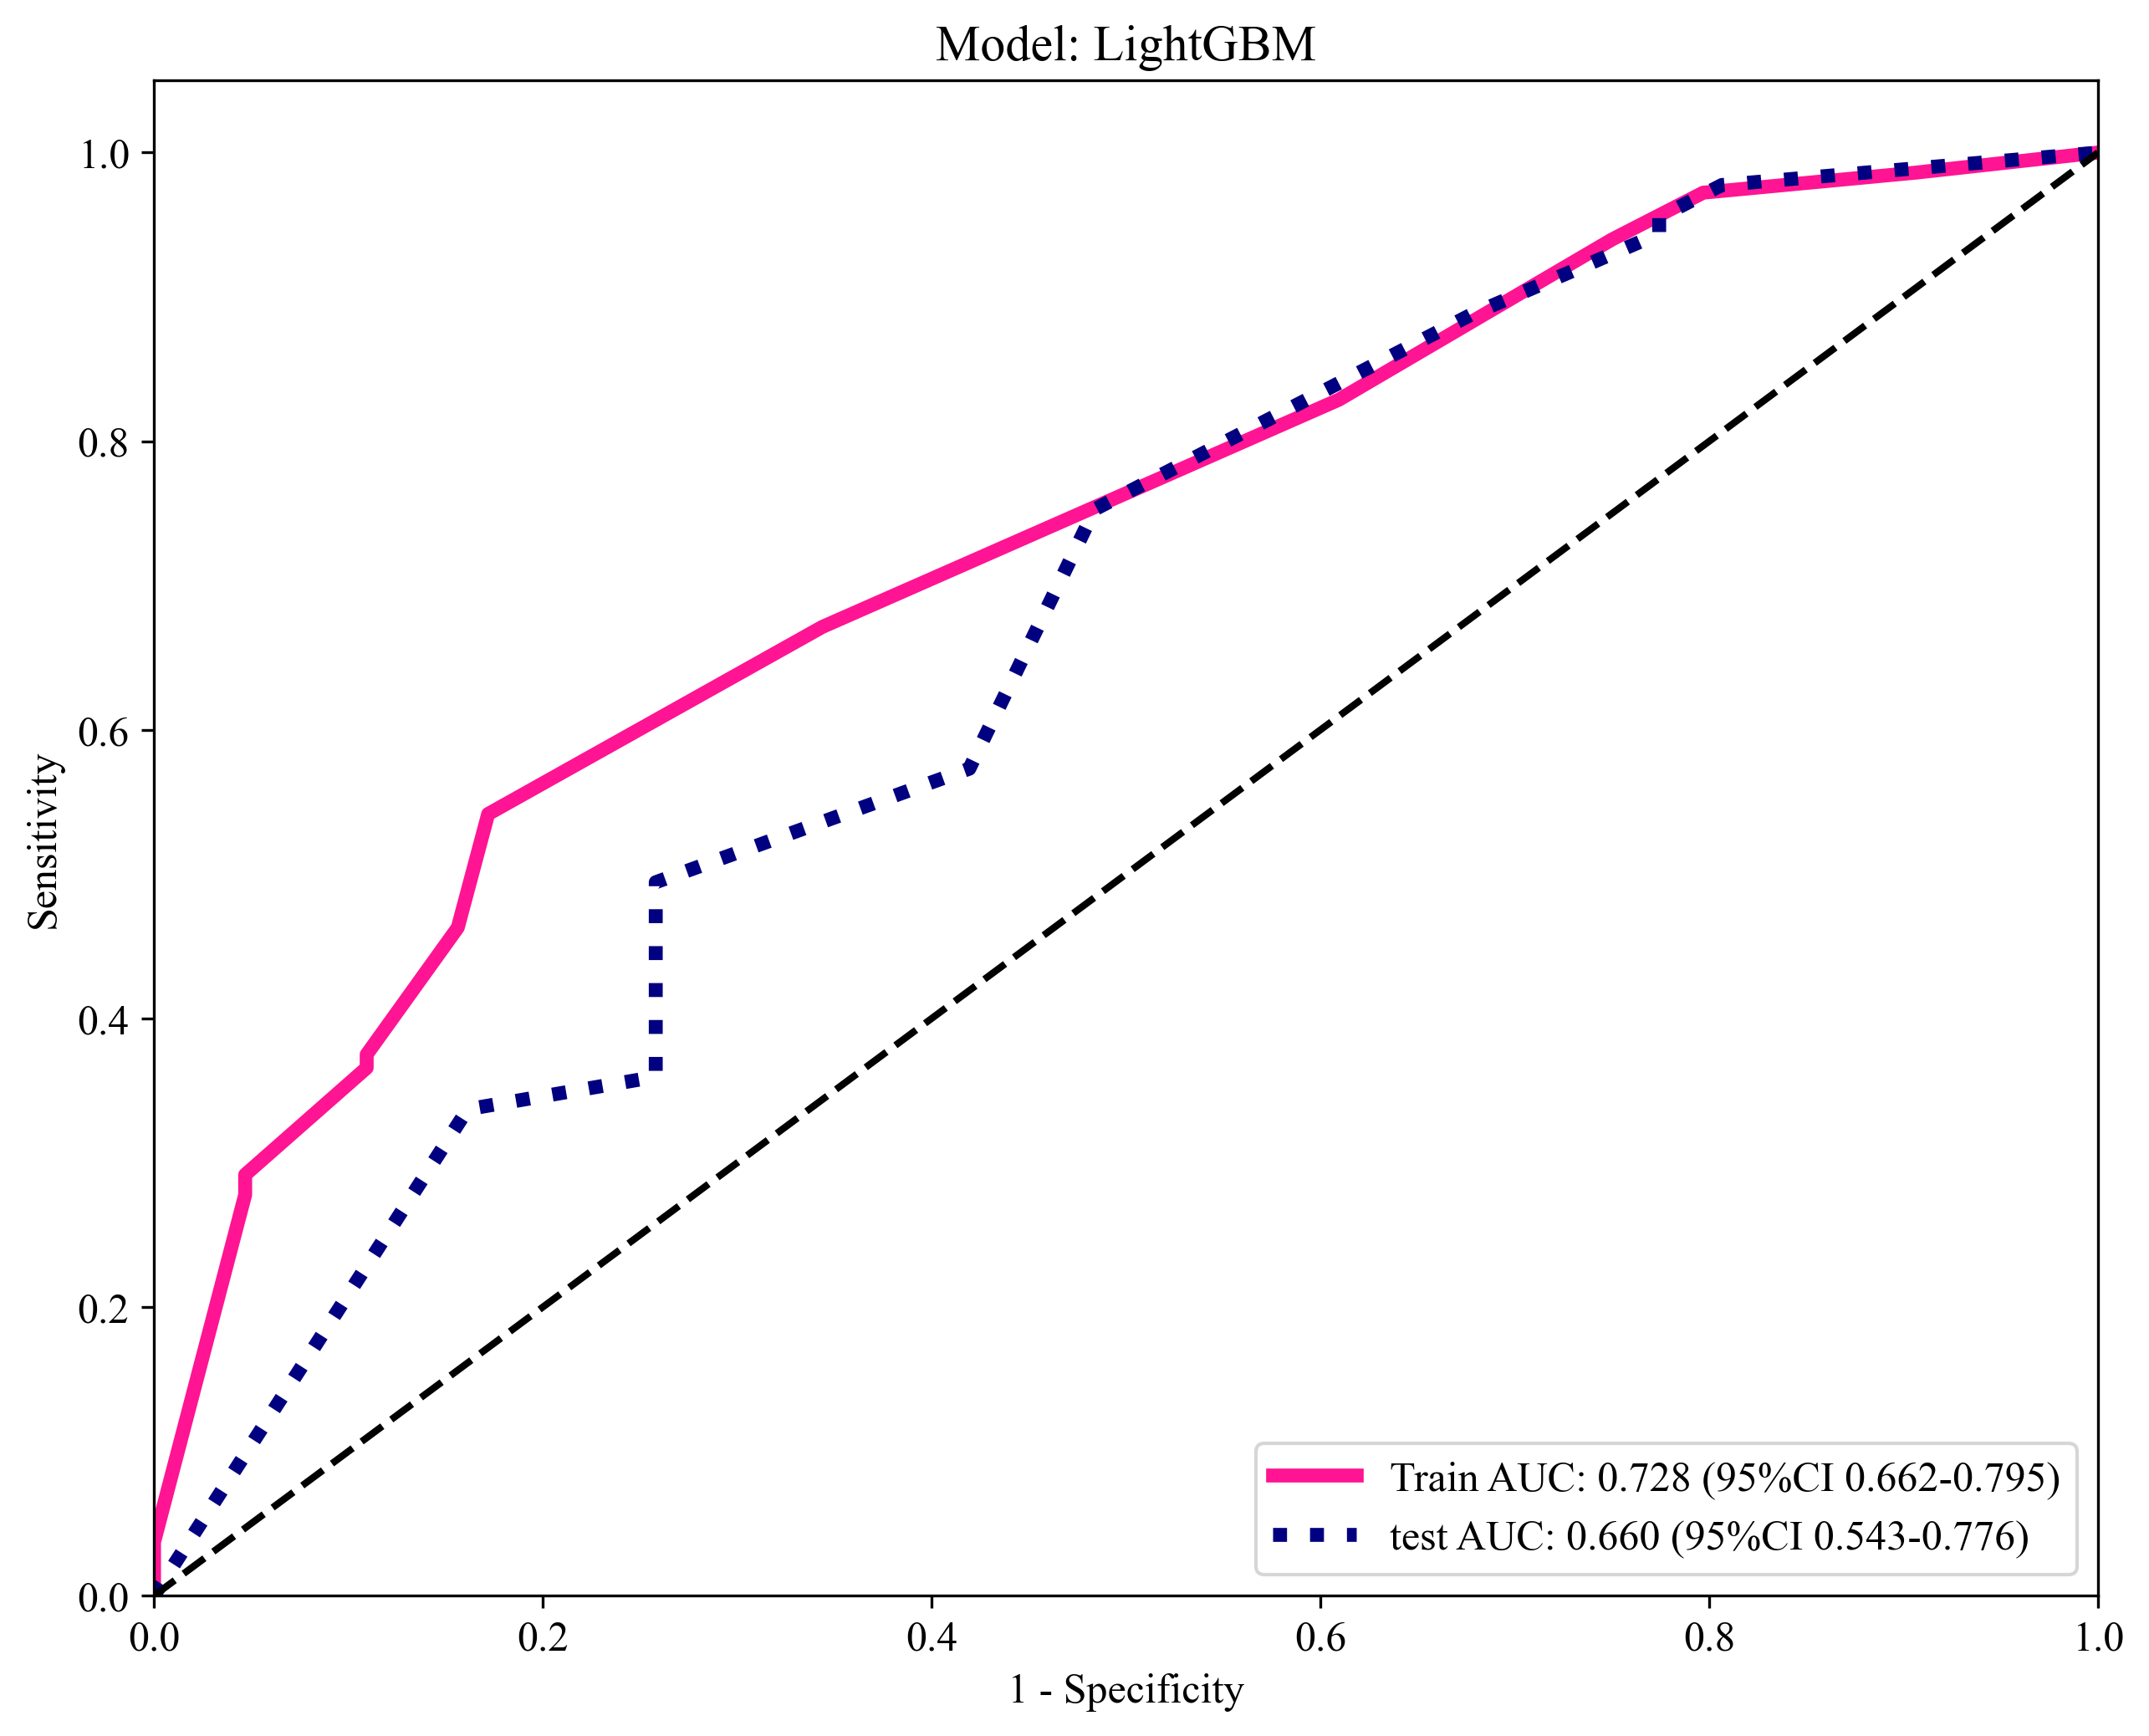

In [44]:
sel_model = model_names

for sm in sel_model:
    if sm in model_names:
        sel_model_idx = model_names.index(sm)
    
        # Plot all ROC curves
#         plt.figure(figsize=(10, 10))
        for pred_score, label in zip(pred_scores, labels):
            ys = [np.array(y_train_sel[label])] + [np.array(y_val_sel[label]) for _, y_val_sel, _ in val_datasets.values()]
            ps = [pred_score[sel_model_idx][0]] + [p_[0] for p_ in pred_score[sel_model_idx][1]]
            okcomp.comp1.draw_roc(ys, ps, 
                                  labels=['Train'] + list(val_datasets.keys()), title=f"Model: {sm}")
            plt.savefig(f'img/{task_type}model_{sm}_roc.svg', bbox_inches = 'tight')
            plt.show()

#### 汇总所有模型

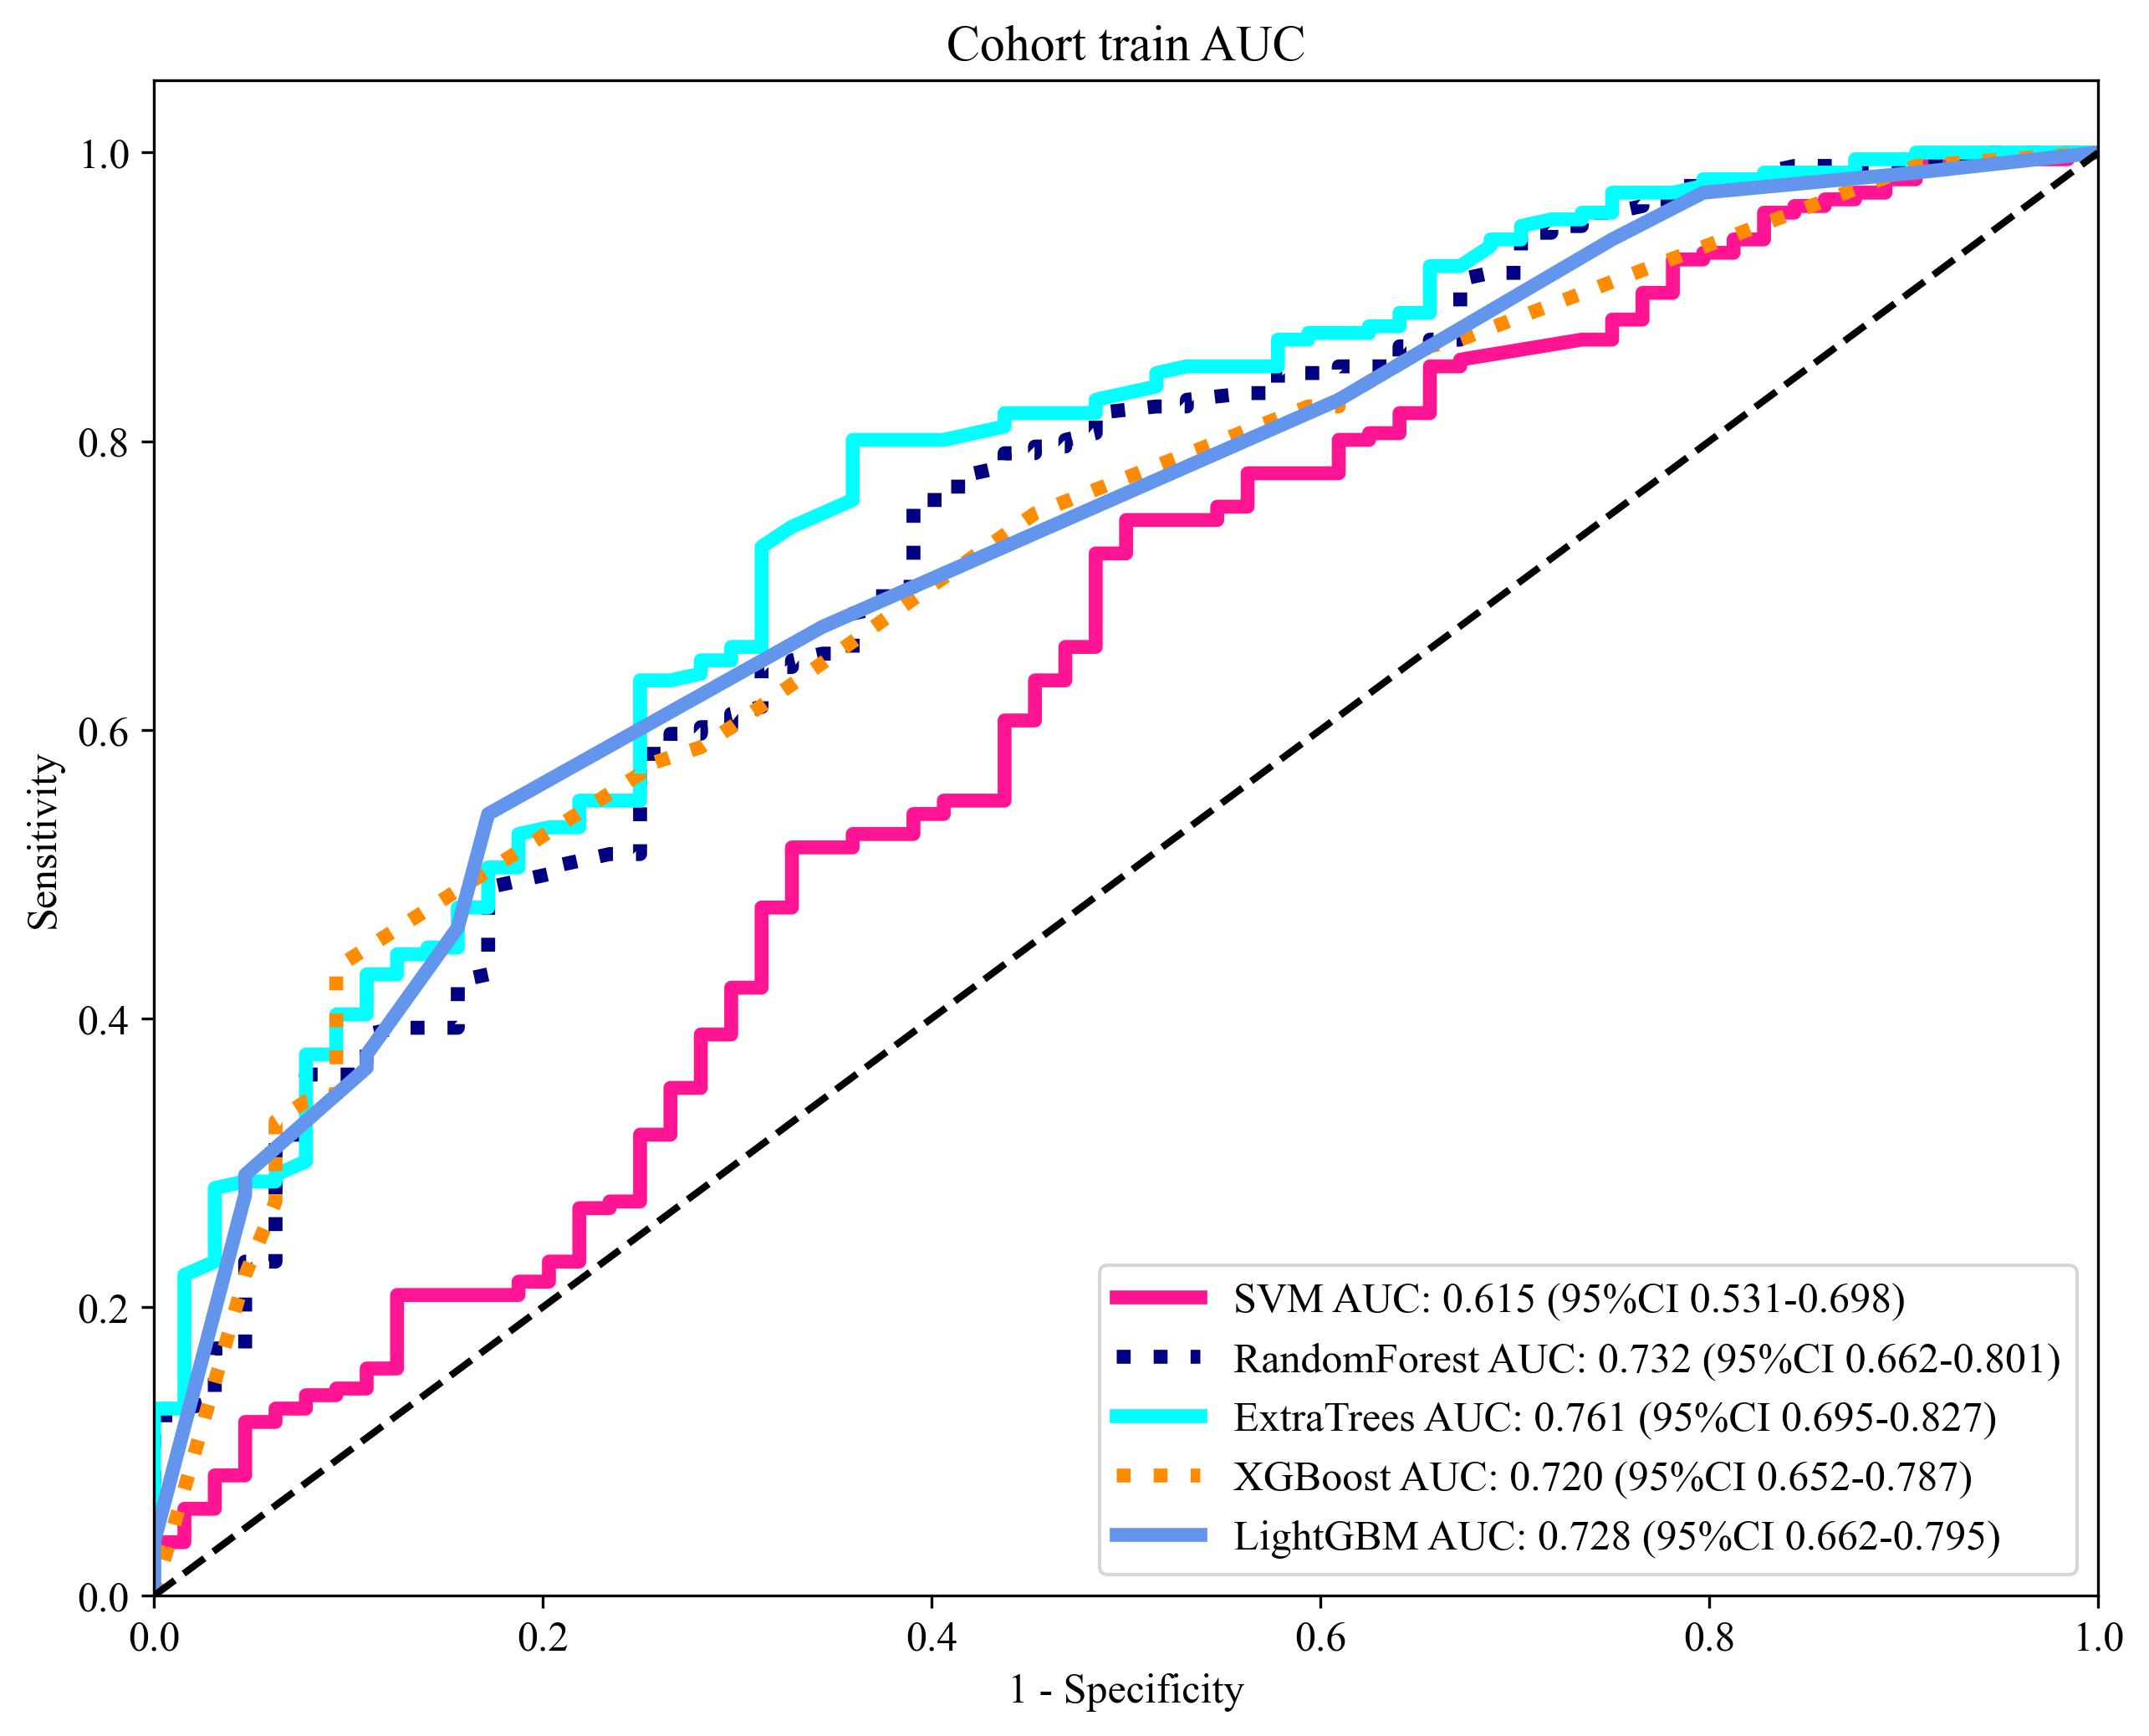

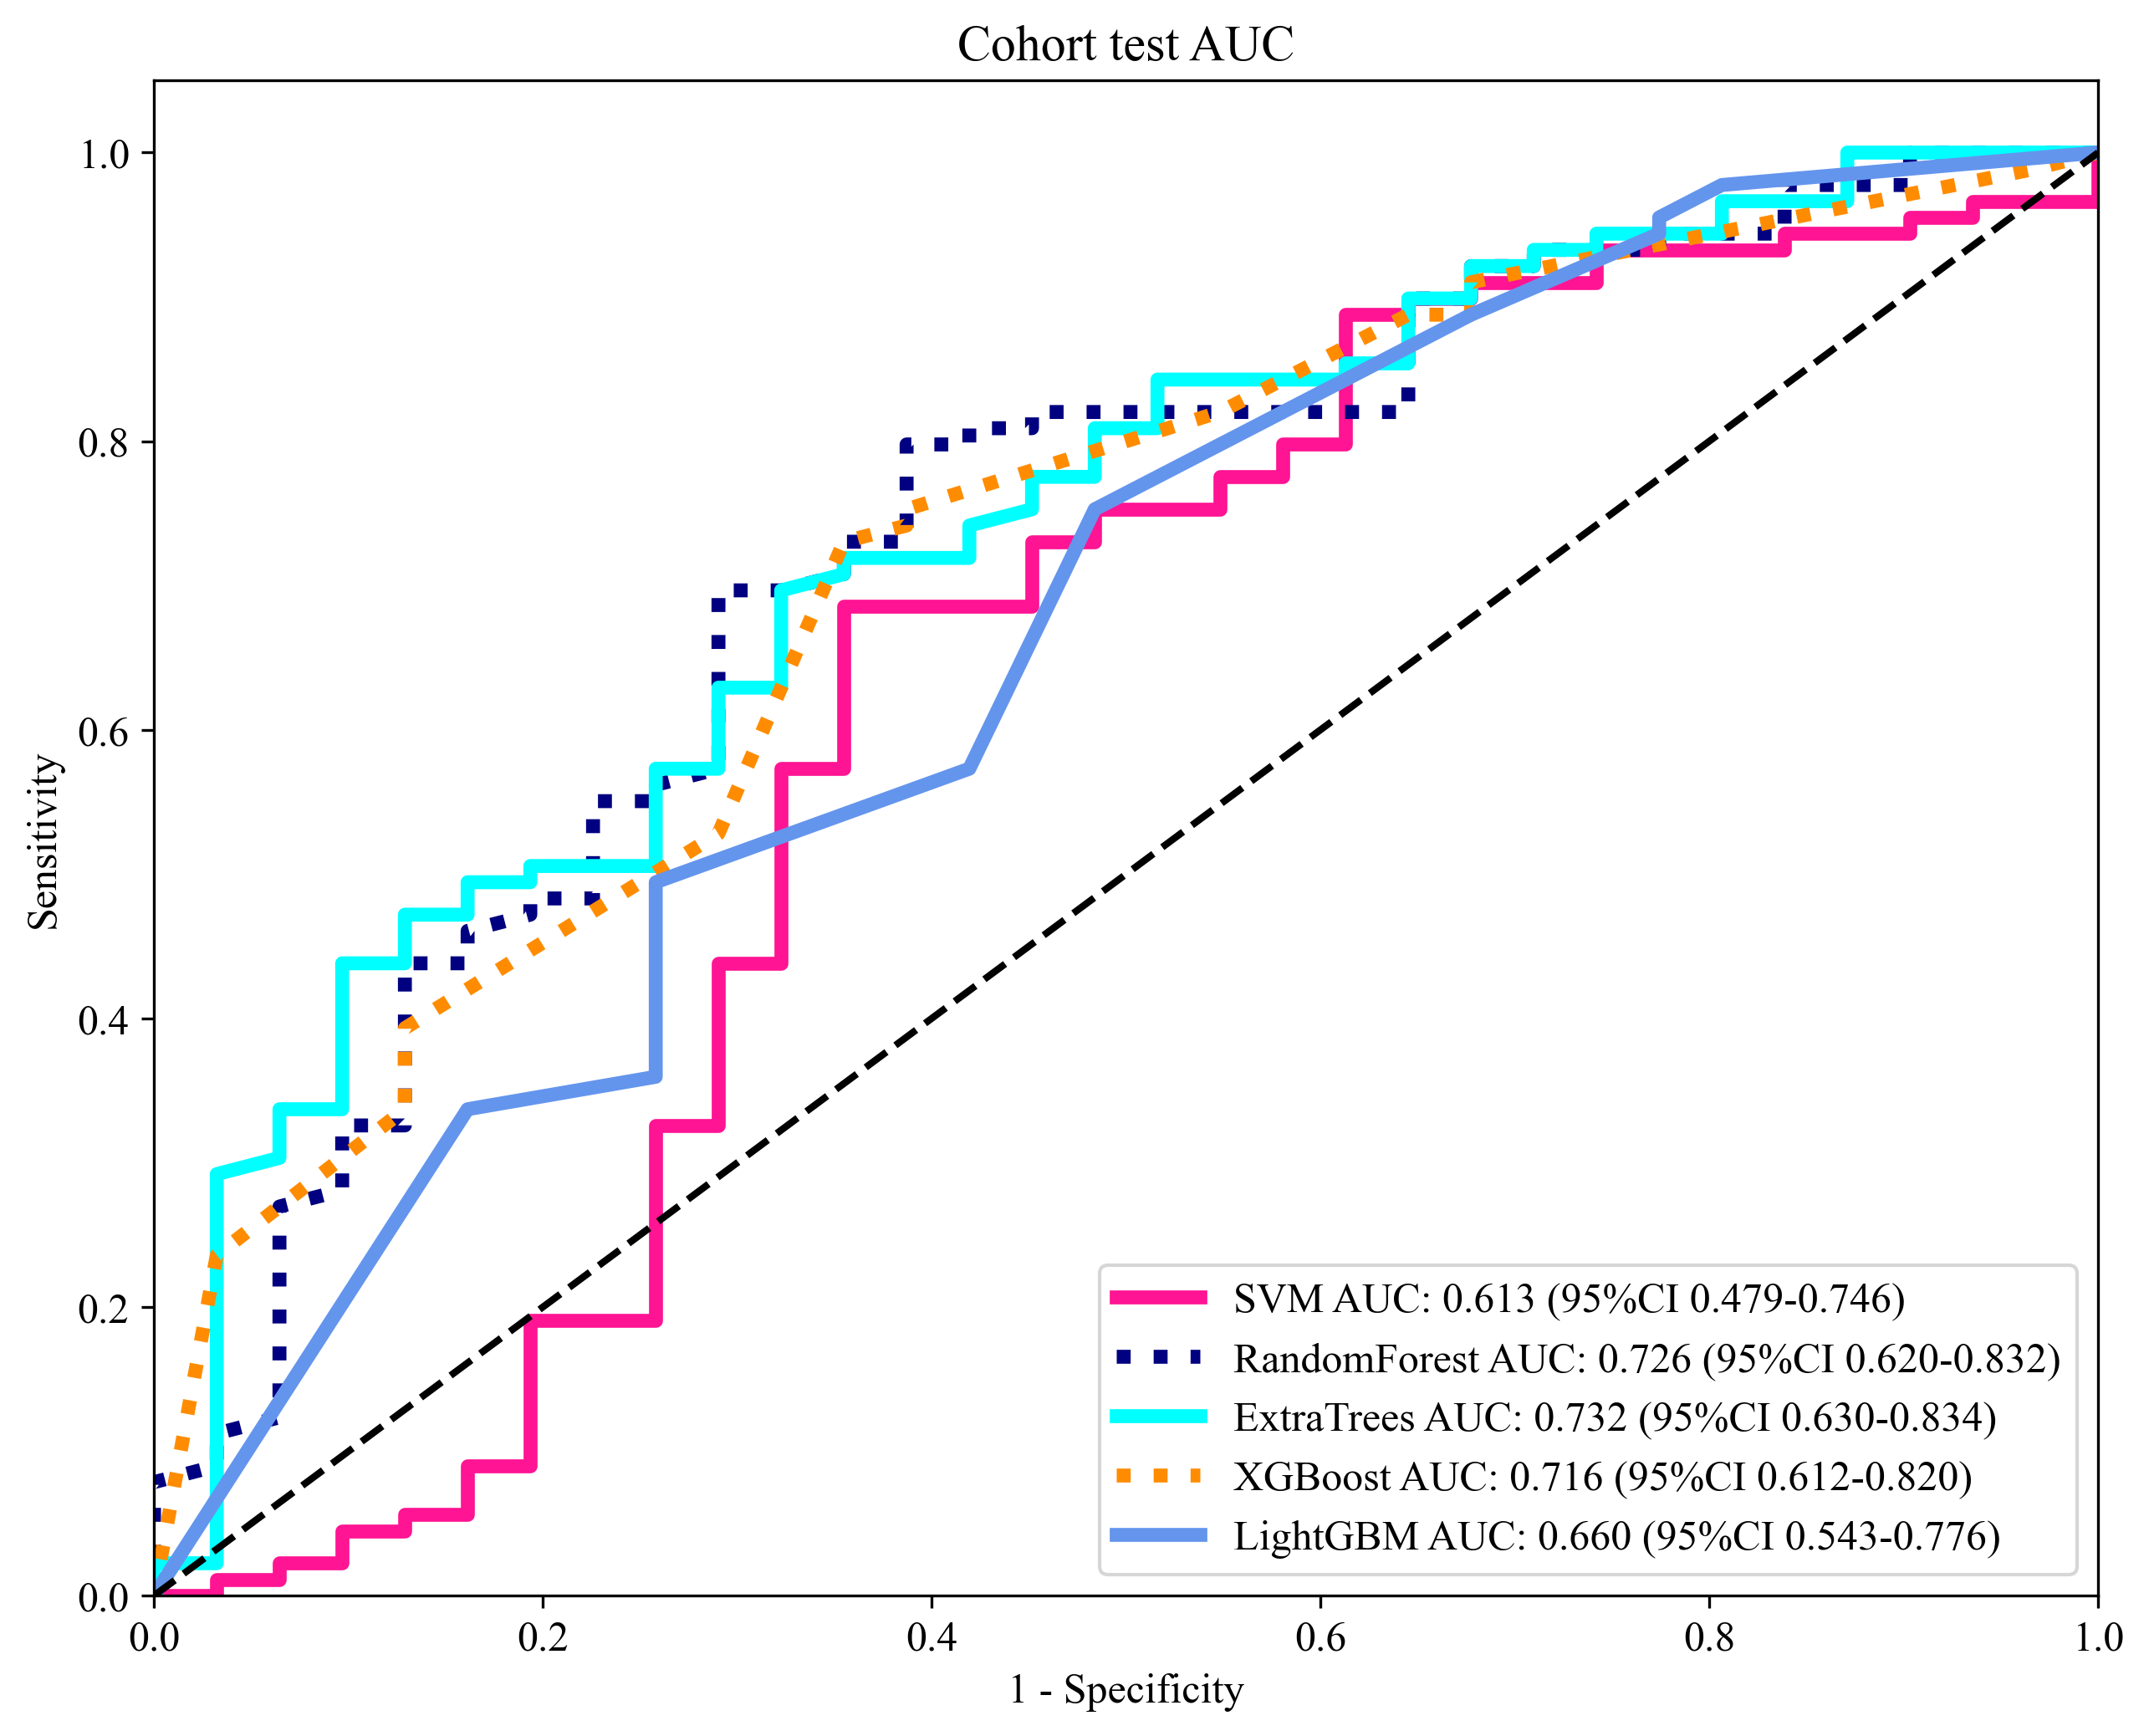

In [45]:
sel_model = model_names

for pred_score, label in zip(pred_scores, labels):
    pred_val_scores = []
    for sm in sel_model:
        if sm in model_names:
            sel_model_idx = model_names.index(sm)
            pred_val_scores.append((pred_score[sel_model_idx][0], y_train_sel))
    p_, l_ = zip(*pred_val_scores)
    okcomp.comp1.draw_roc(l_, p_, labels=sel_model, title=f"Cohort train AUC")
    plt.savefig(f'img/{task_type}model_train_roc.svg', bbox_inches = 'tight')
    plt.show()
    for sel_subset_idx, subset in enumerate(val_datasets.keys()):
        pred_val_scores = []
        for sm in sel_model:
            if sm in model_names:
                sel_model_idx = model_names.index(sm)
                pred_val_scores.append(pred_score[sel_model_idx][1][sel_subset_idx])
        p_, l_ = zip(*pred_val_scores)
        okcomp.comp1.draw_roc(l_, p_, labels=sel_model, title=f"Cohort {subset} AUC")
        plt.savefig(f'img/{task_type}model_{subset}_roc.svg', bbox_inches = 'tight')
        plt.show()

### 绘制混淆矩阵

绘制混淆矩阵，[混淆矩阵解释](https://baike.baidu.com/item/%E6%B7%B7%E6%B7%86%E7%9F%A9%E9%98%B5/10087822?fr=aladdin)
`sel_model = ['SVM', 'KNN']`参数为想要绘制的模型对应的参数。

如果需要修改标签到名称的映射，修改`class_mapping={1:'1', 0:'0'}`

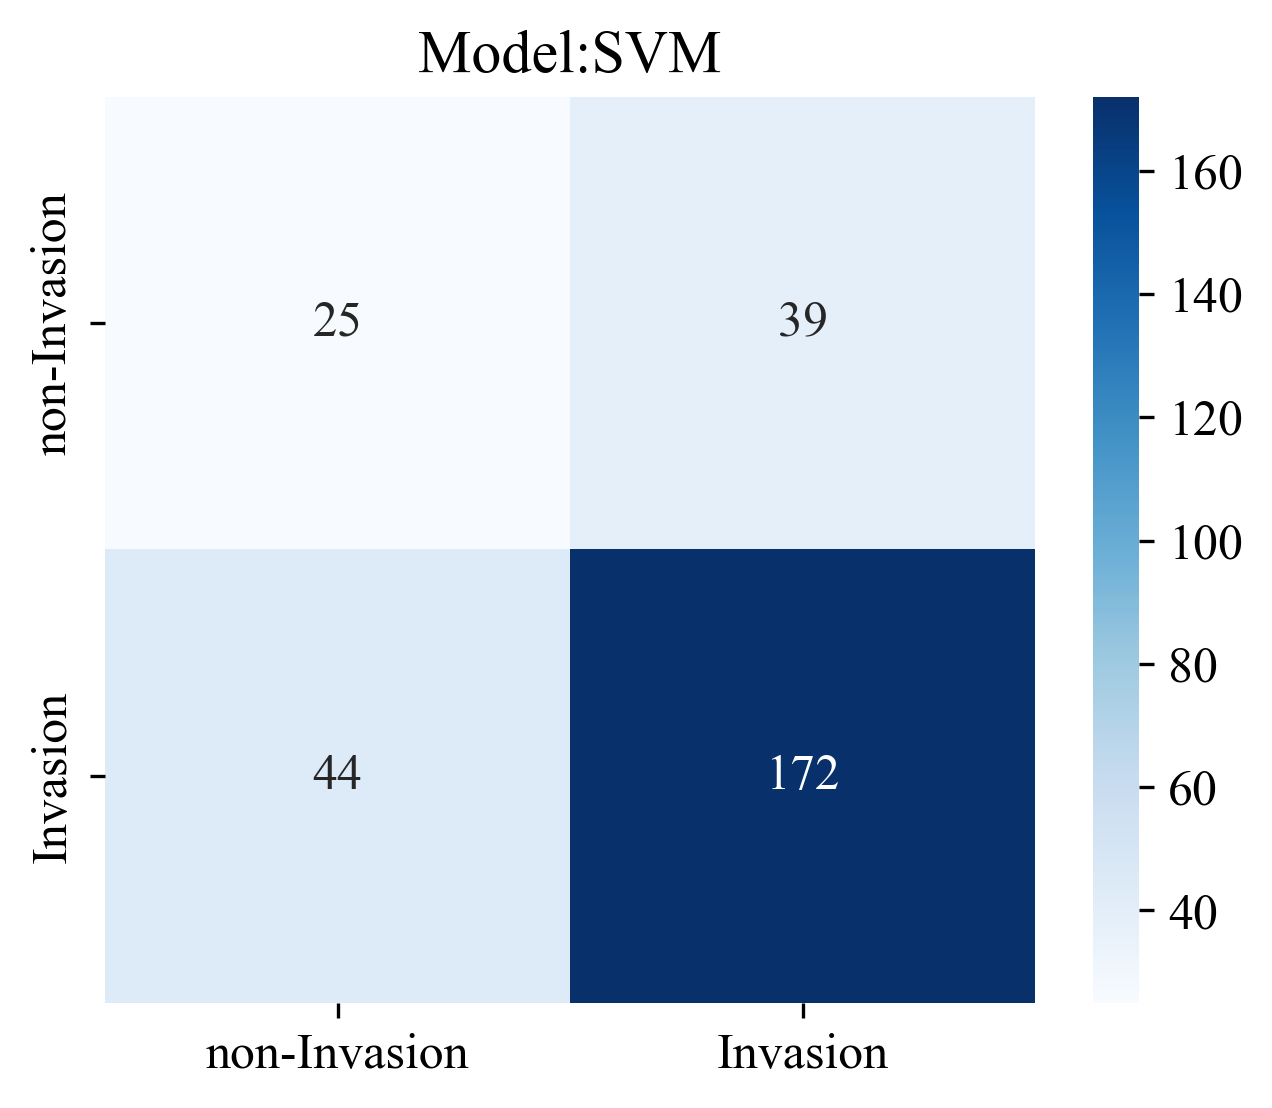

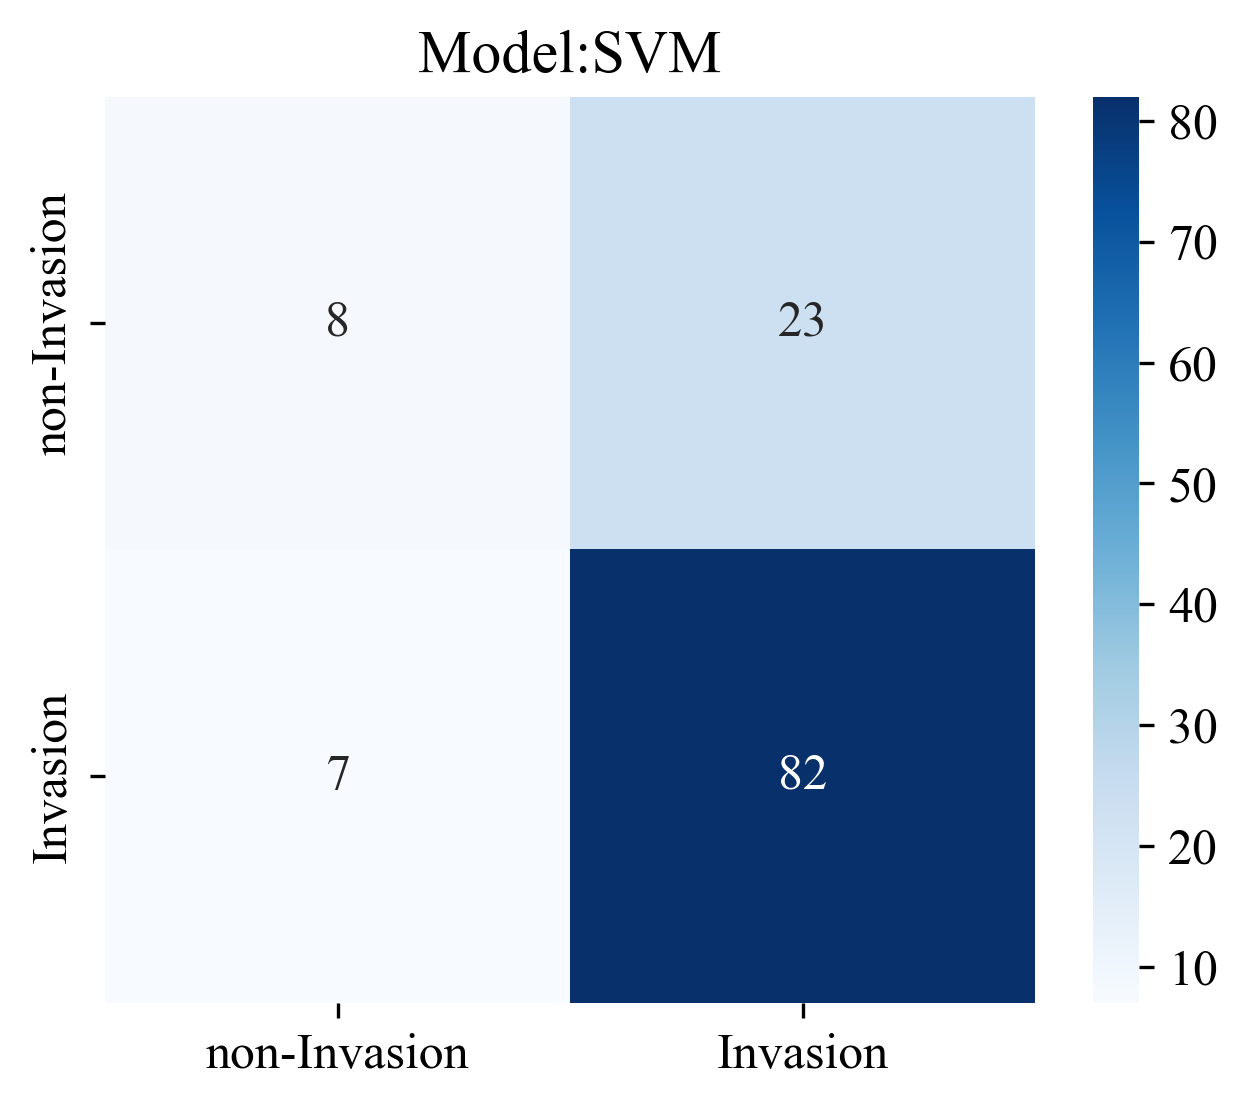

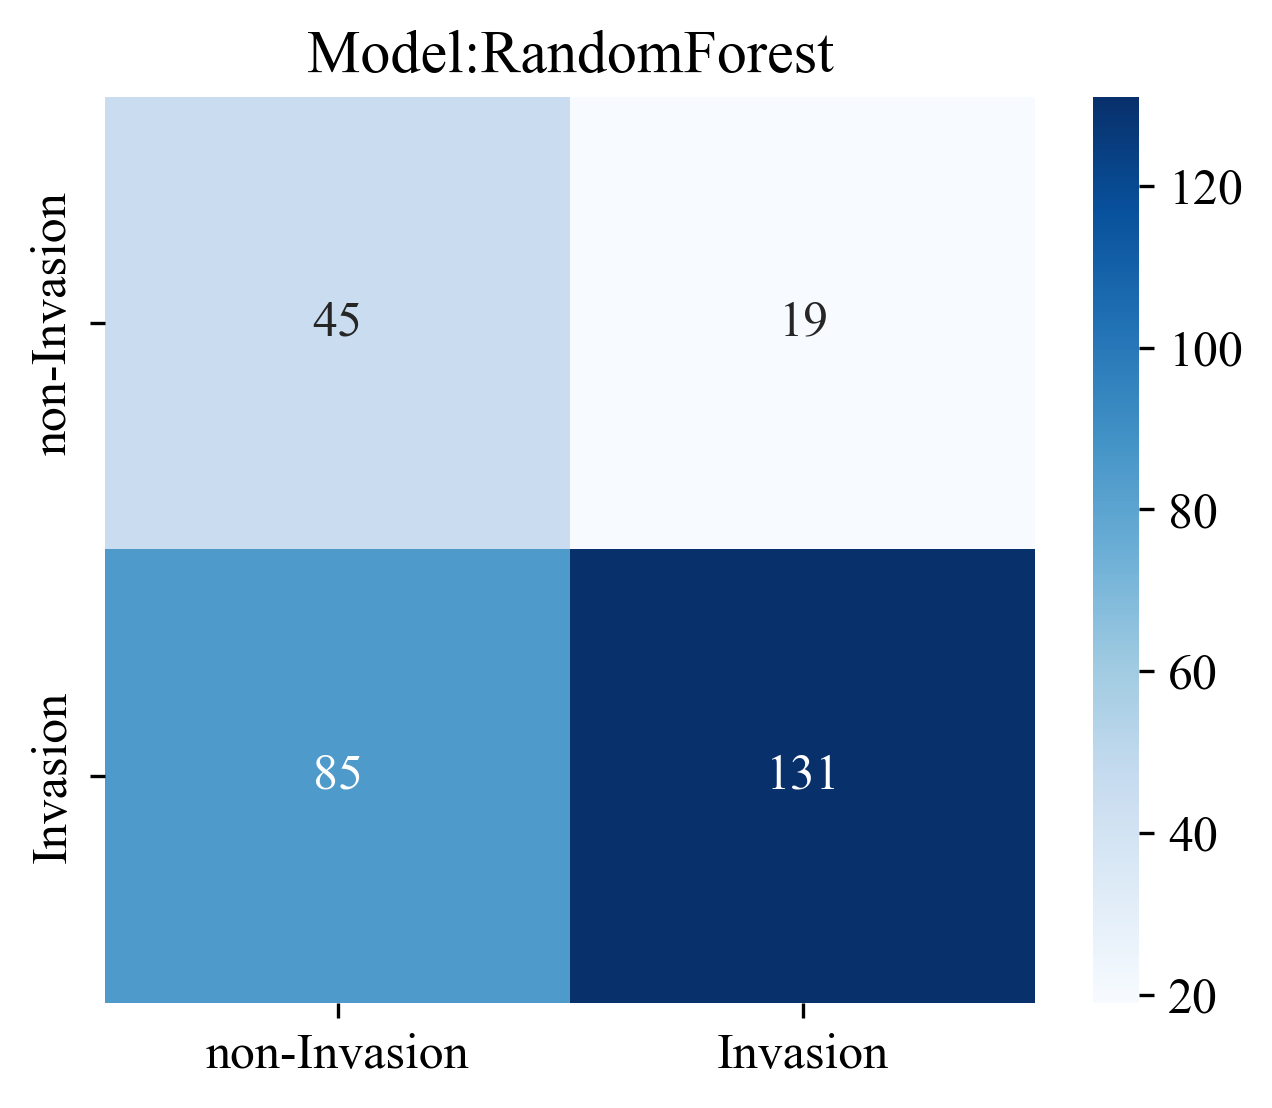

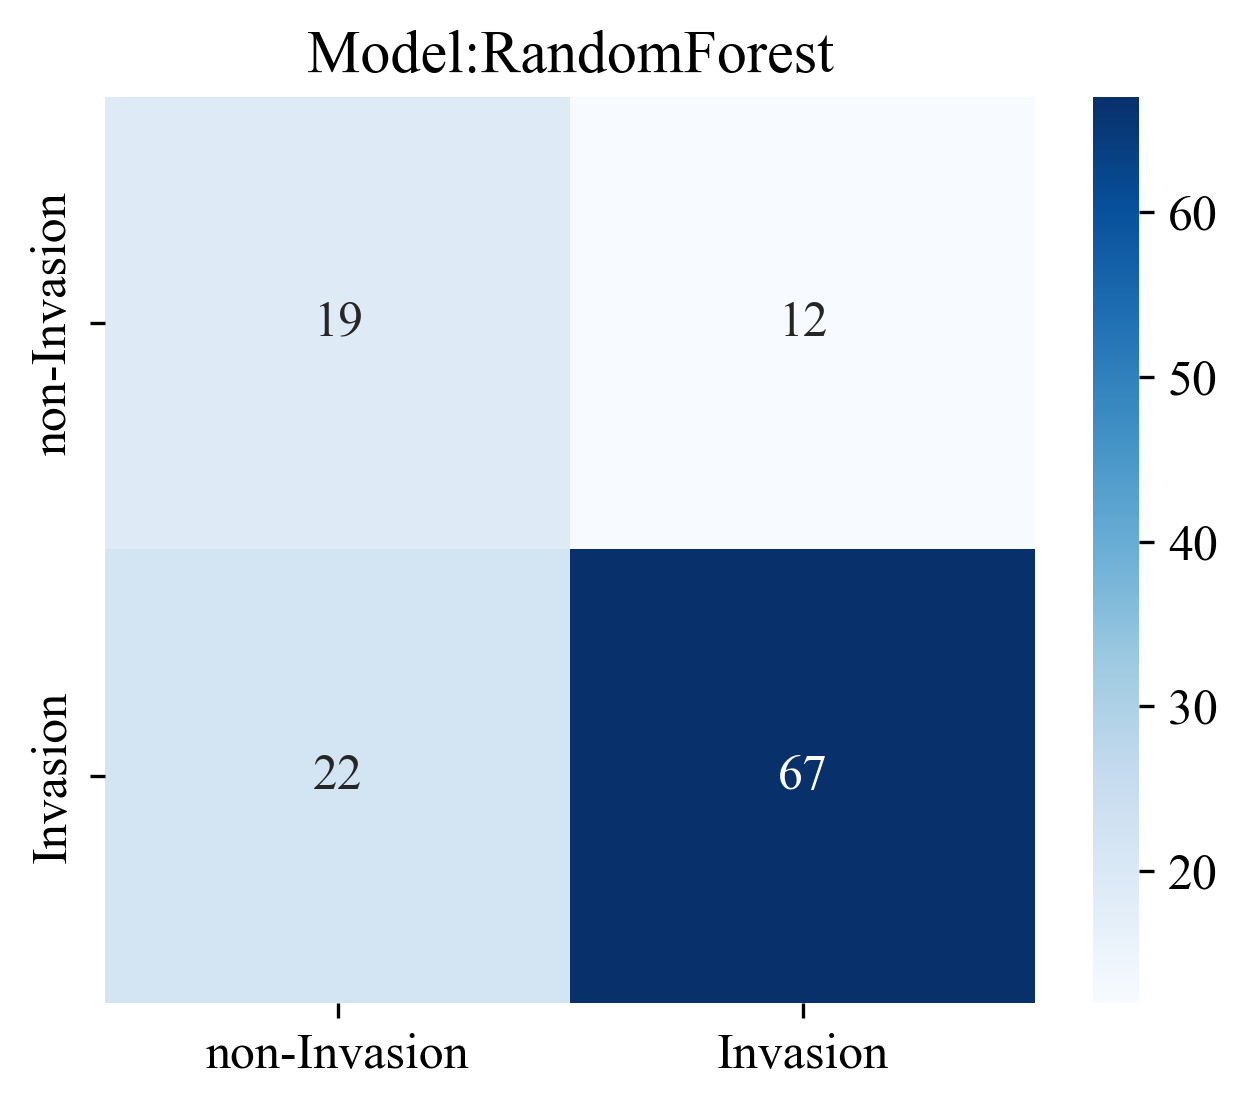

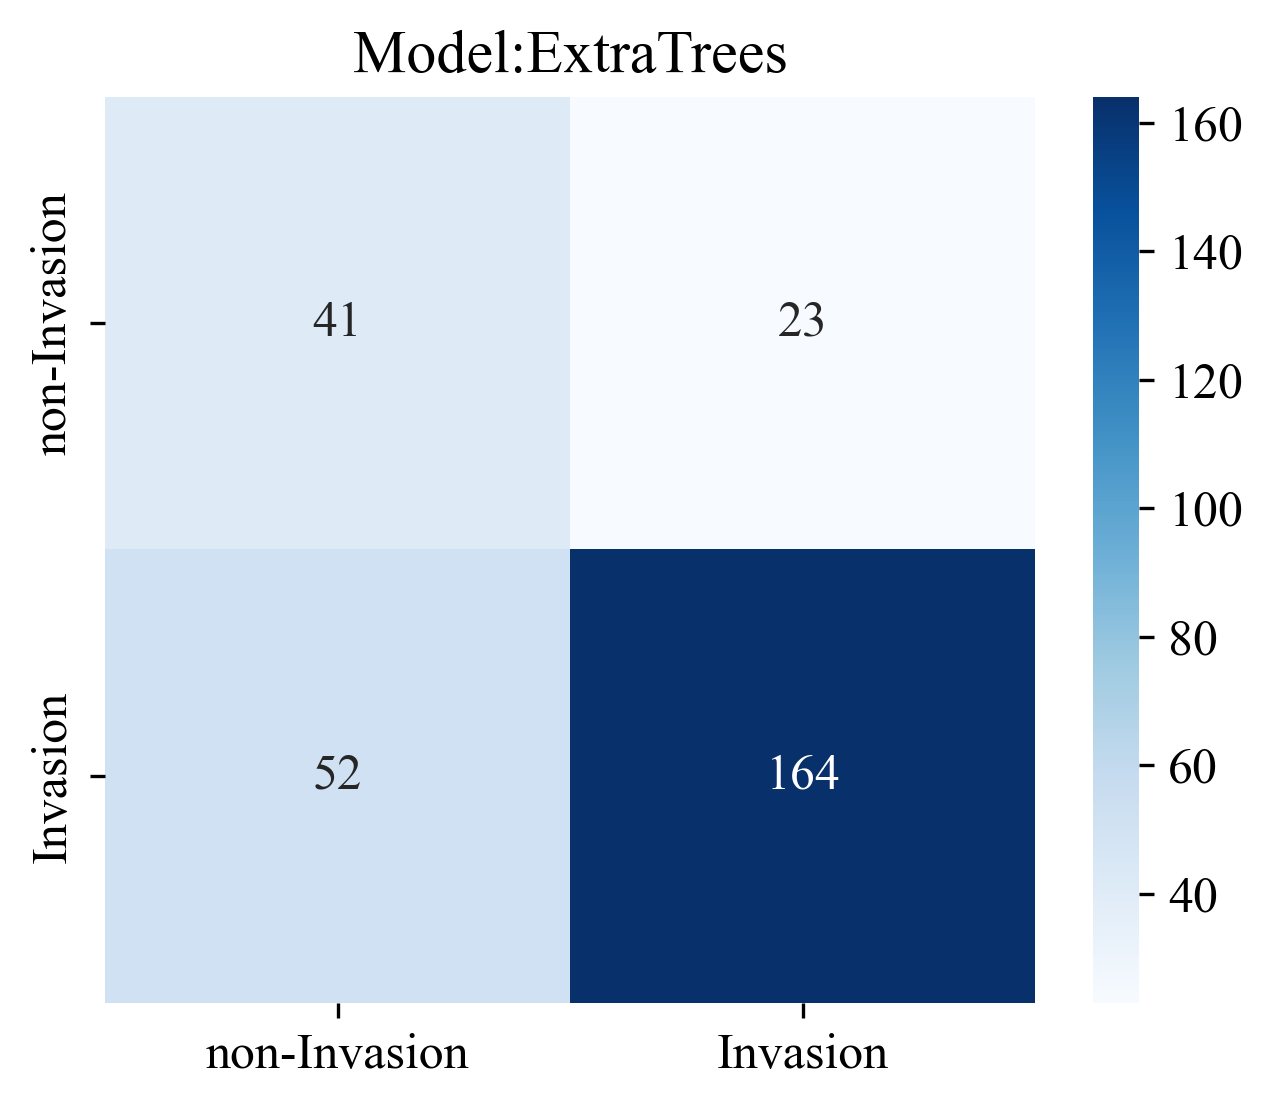

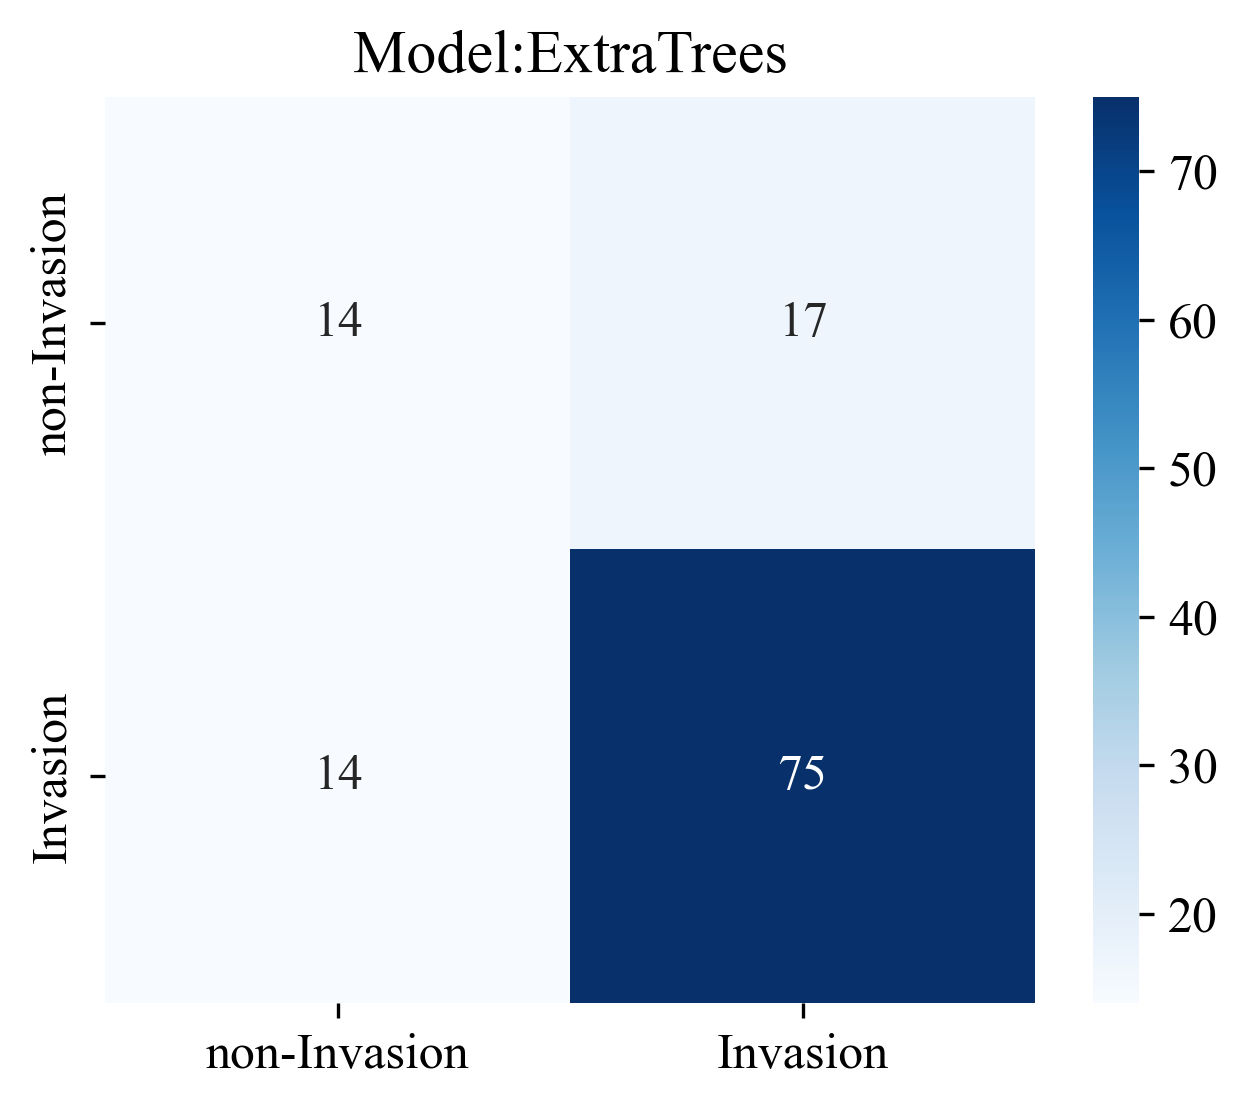

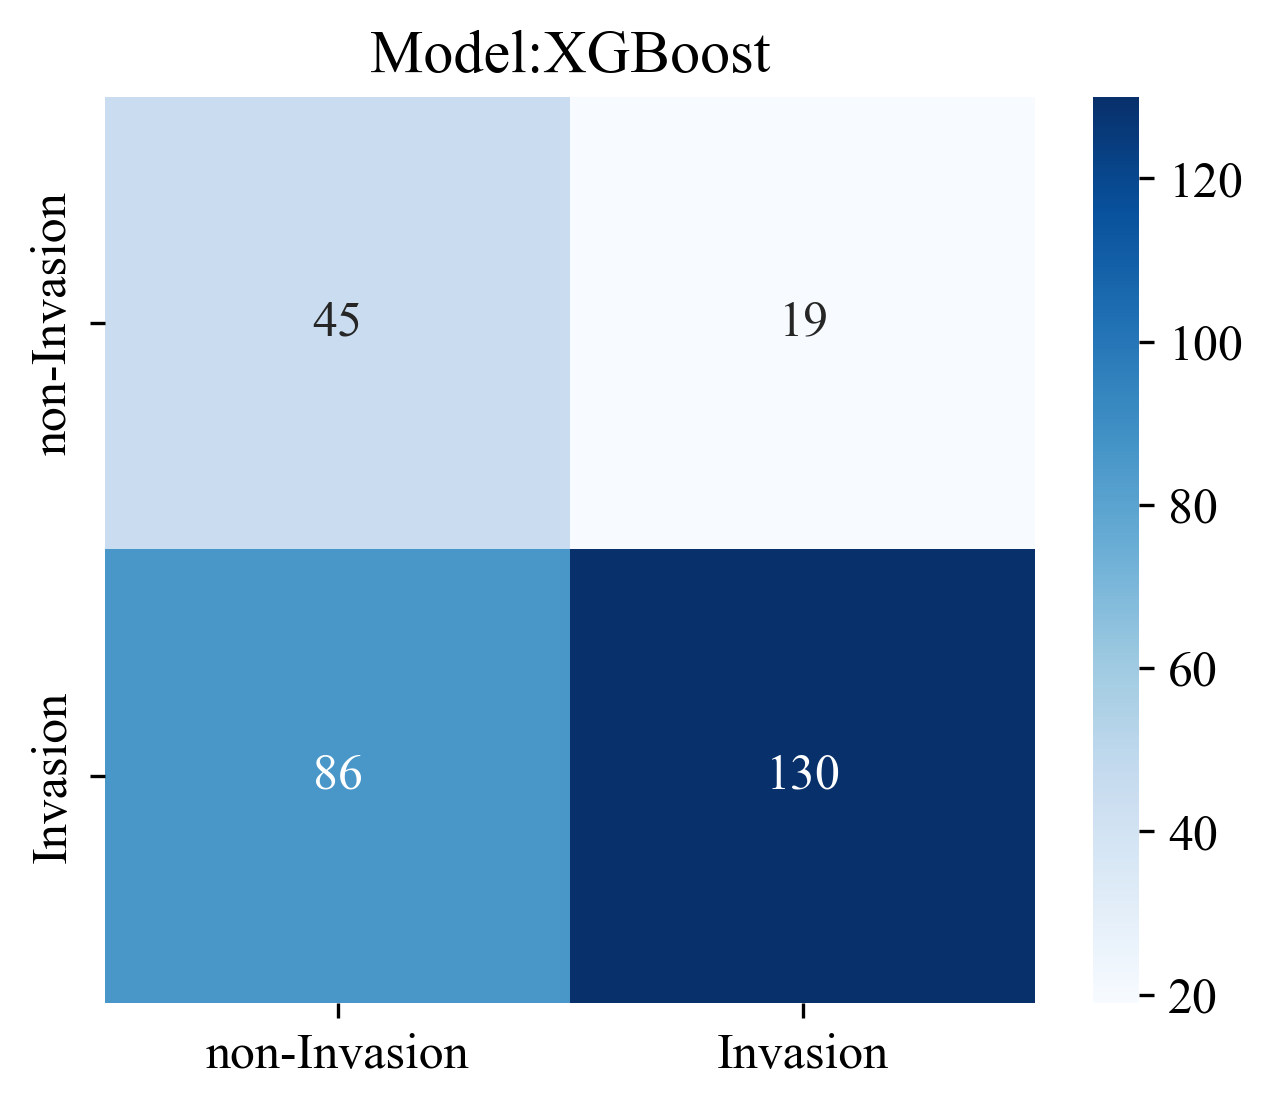

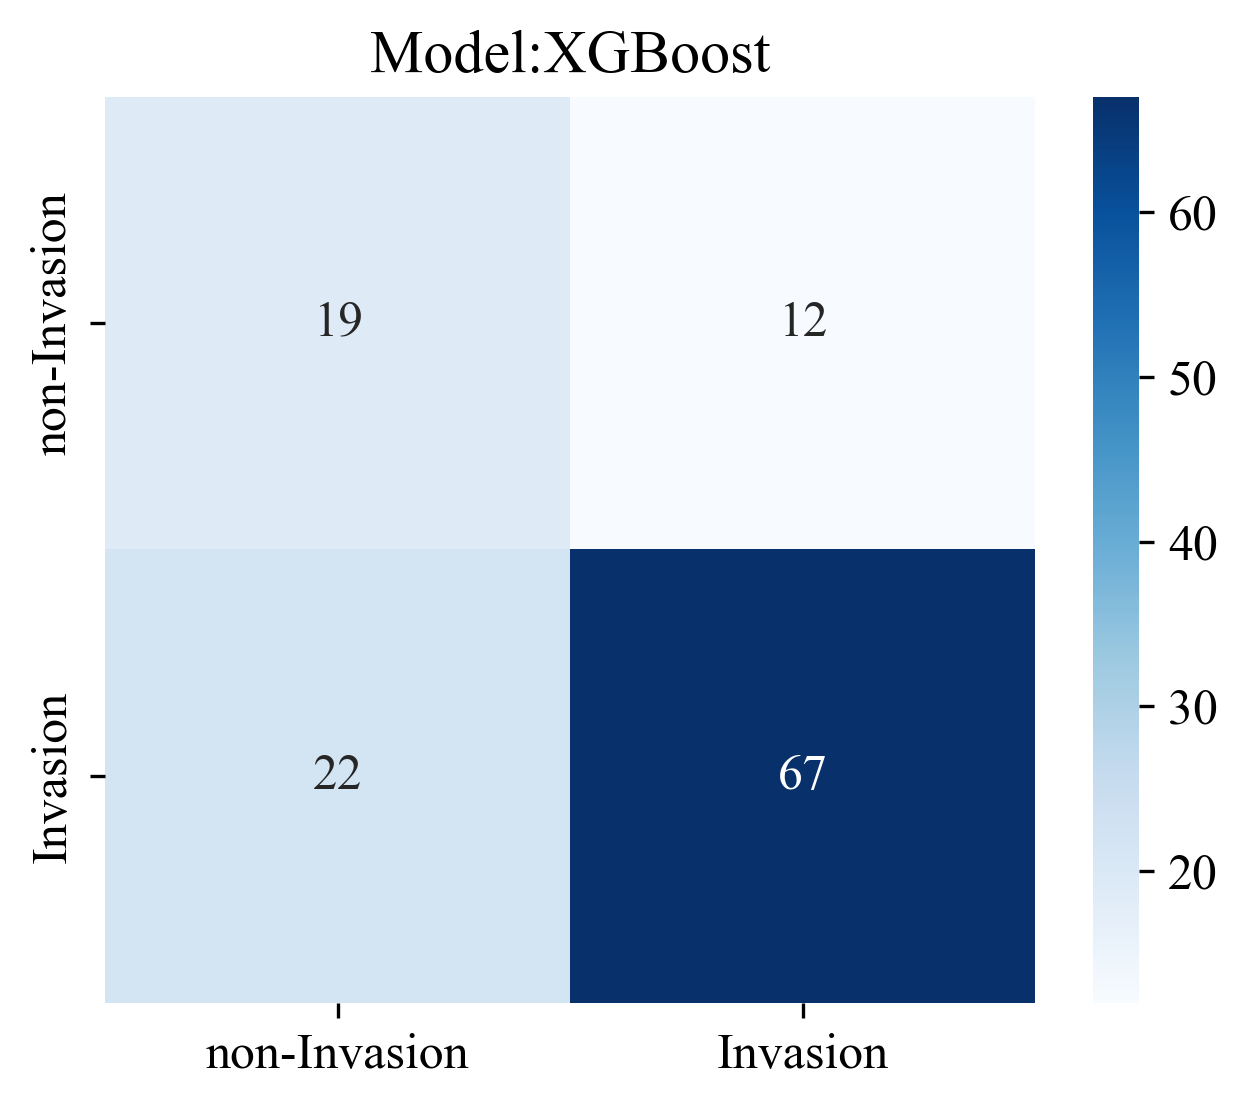

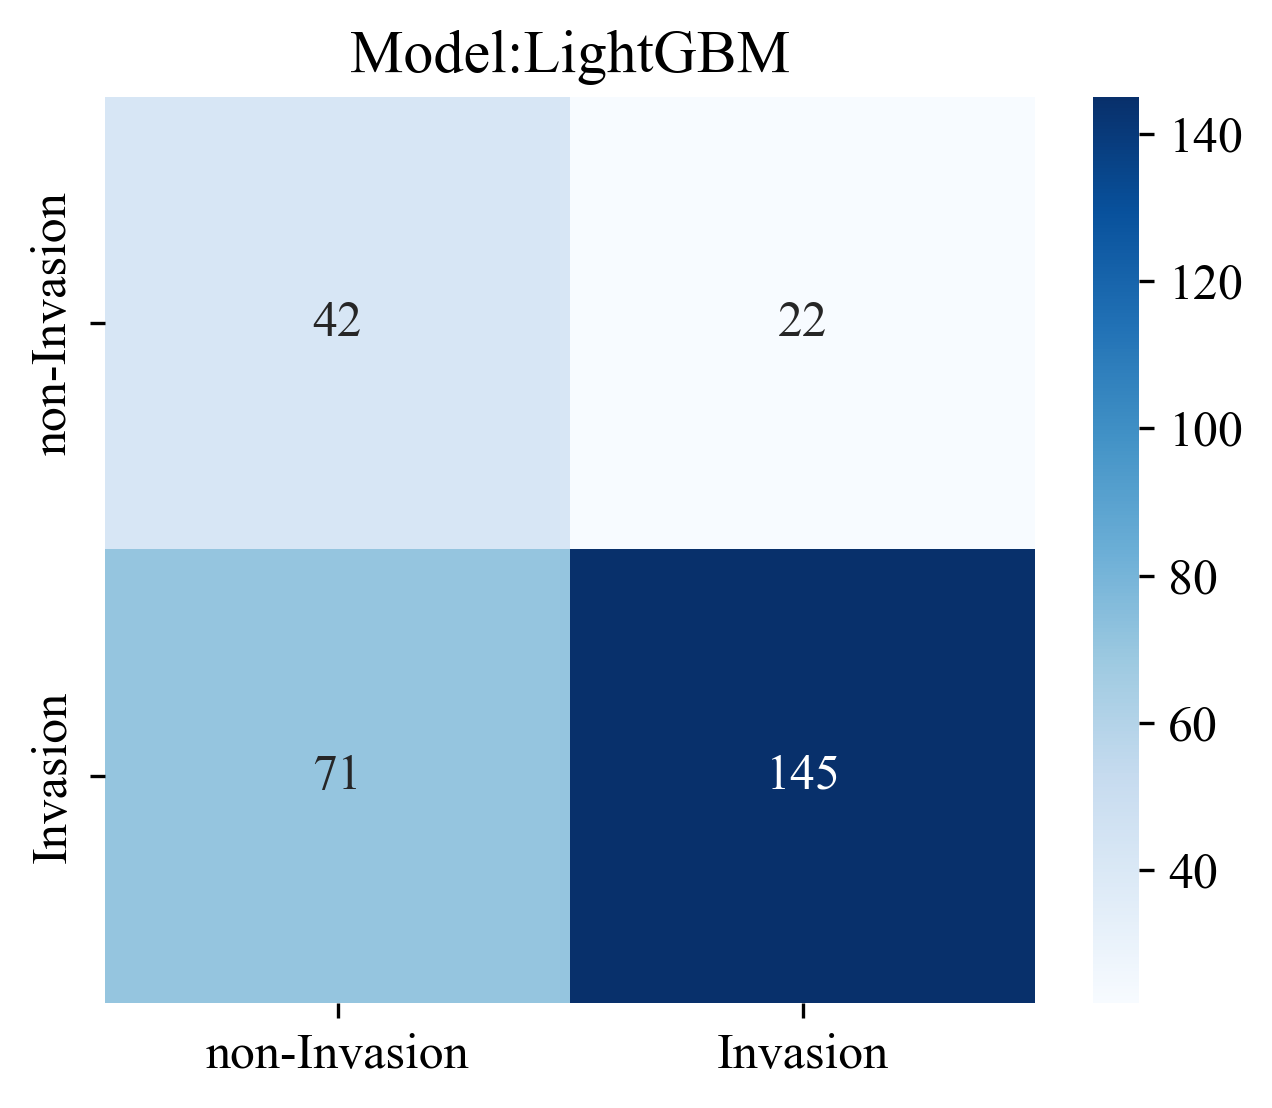

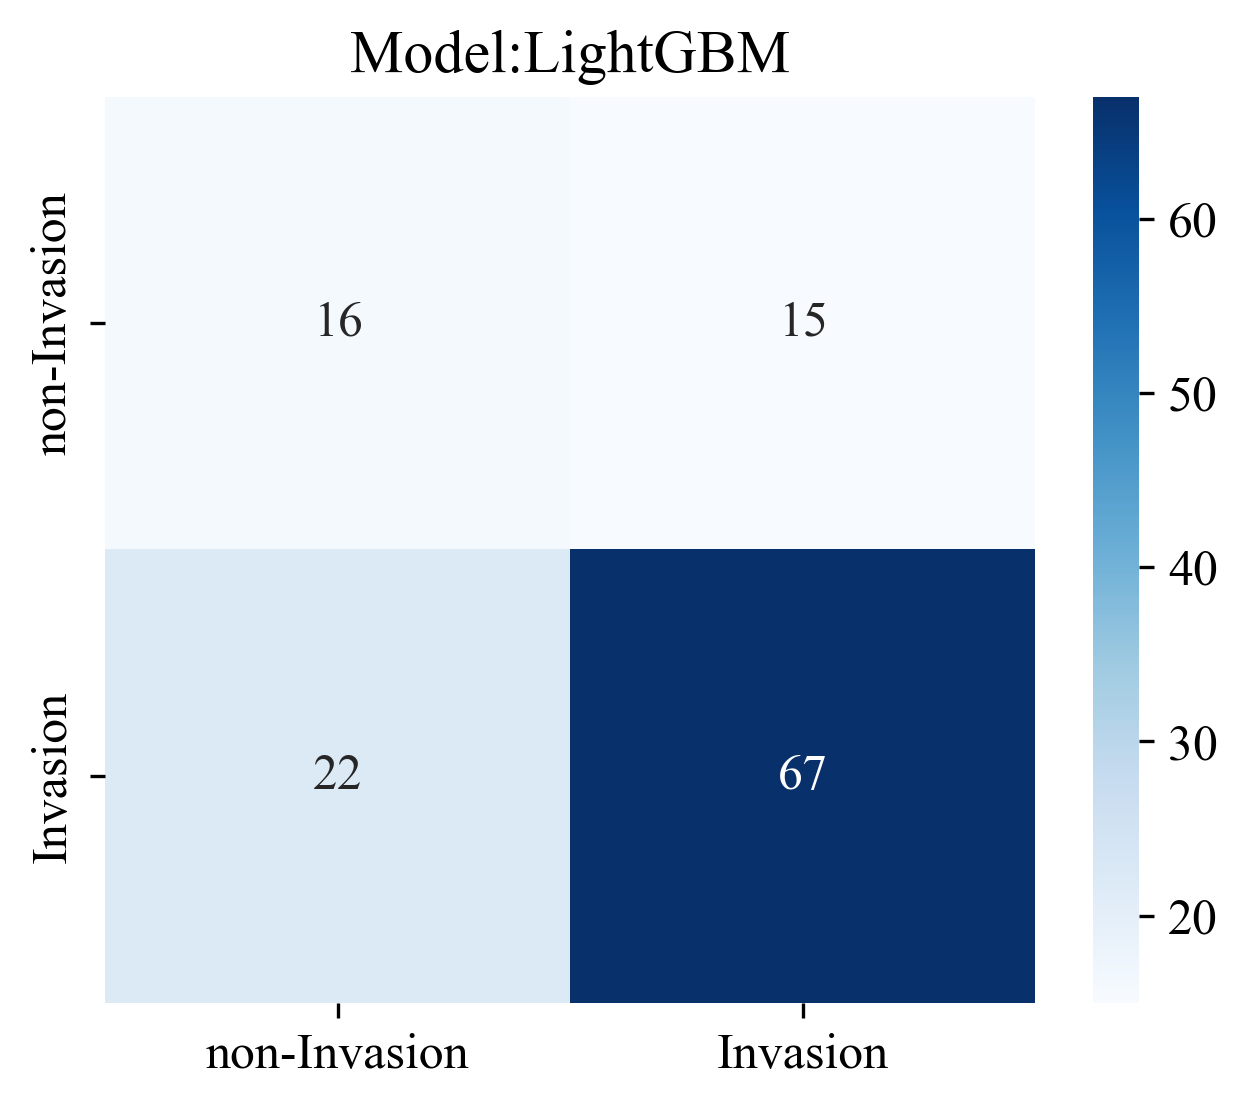

In [38]:
# 设置绘制参数
sel_model = model_names

mapping = get_param_in_cwd('label_mapping')
for sm in sel_model:
    if sm in model_names:
        sel_model_idx = model_names.index(sm)
        for idx, label in enumerate(labels):
            for sel_subset_idx, subset in enumerate(val_datasets.keys()):
                p_ = predictions[idx][sel_model_idx][0]
                cm = okcomp.comp1.calc_confusion_matrix(p_, y_train_sel[label], 
                                                        class_mapping=mapping, num_classes=2)
                plt.figure(figsize=(5, 4))
                plt.title(f'Model:{sm}')
                okcomp.comp1.draw_matrix(cm, norm=False, annot=True, cmap='Blues', fmt='.0f')
                plt.savefig(f'img/{task_type}model_train_{sm}_cm.svg', bbox_inches = 'tight')
            for sel_subset_idx, subset in enumerate(val_datasets.keys()):
                p_, l_ = predictions[idx][sel_model_idx][1][sel_subset_idx]
                cm = okcomp.comp1.calc_confusion_matrix(p_, l_[label], 
                                                        class_mapping=mapping, num_classes=2)
                plt.figure(figsize=(5, 4))
                plt.title(f'Model:{sm}')
                okcomp.comp1.draw_matrix(cm, norm=False, annot=True, cmap='Blues', fmt='.0f')
                plt.savefig(f'img/{task_type}model_{subset}_{sm}_cm.svg', bbox_inches = 'tight')

### 样本预测直方图

绘制每个样本的预测结果以及对应的真实结果, 图例中label=xx可以修改成自己类别的真实标签。

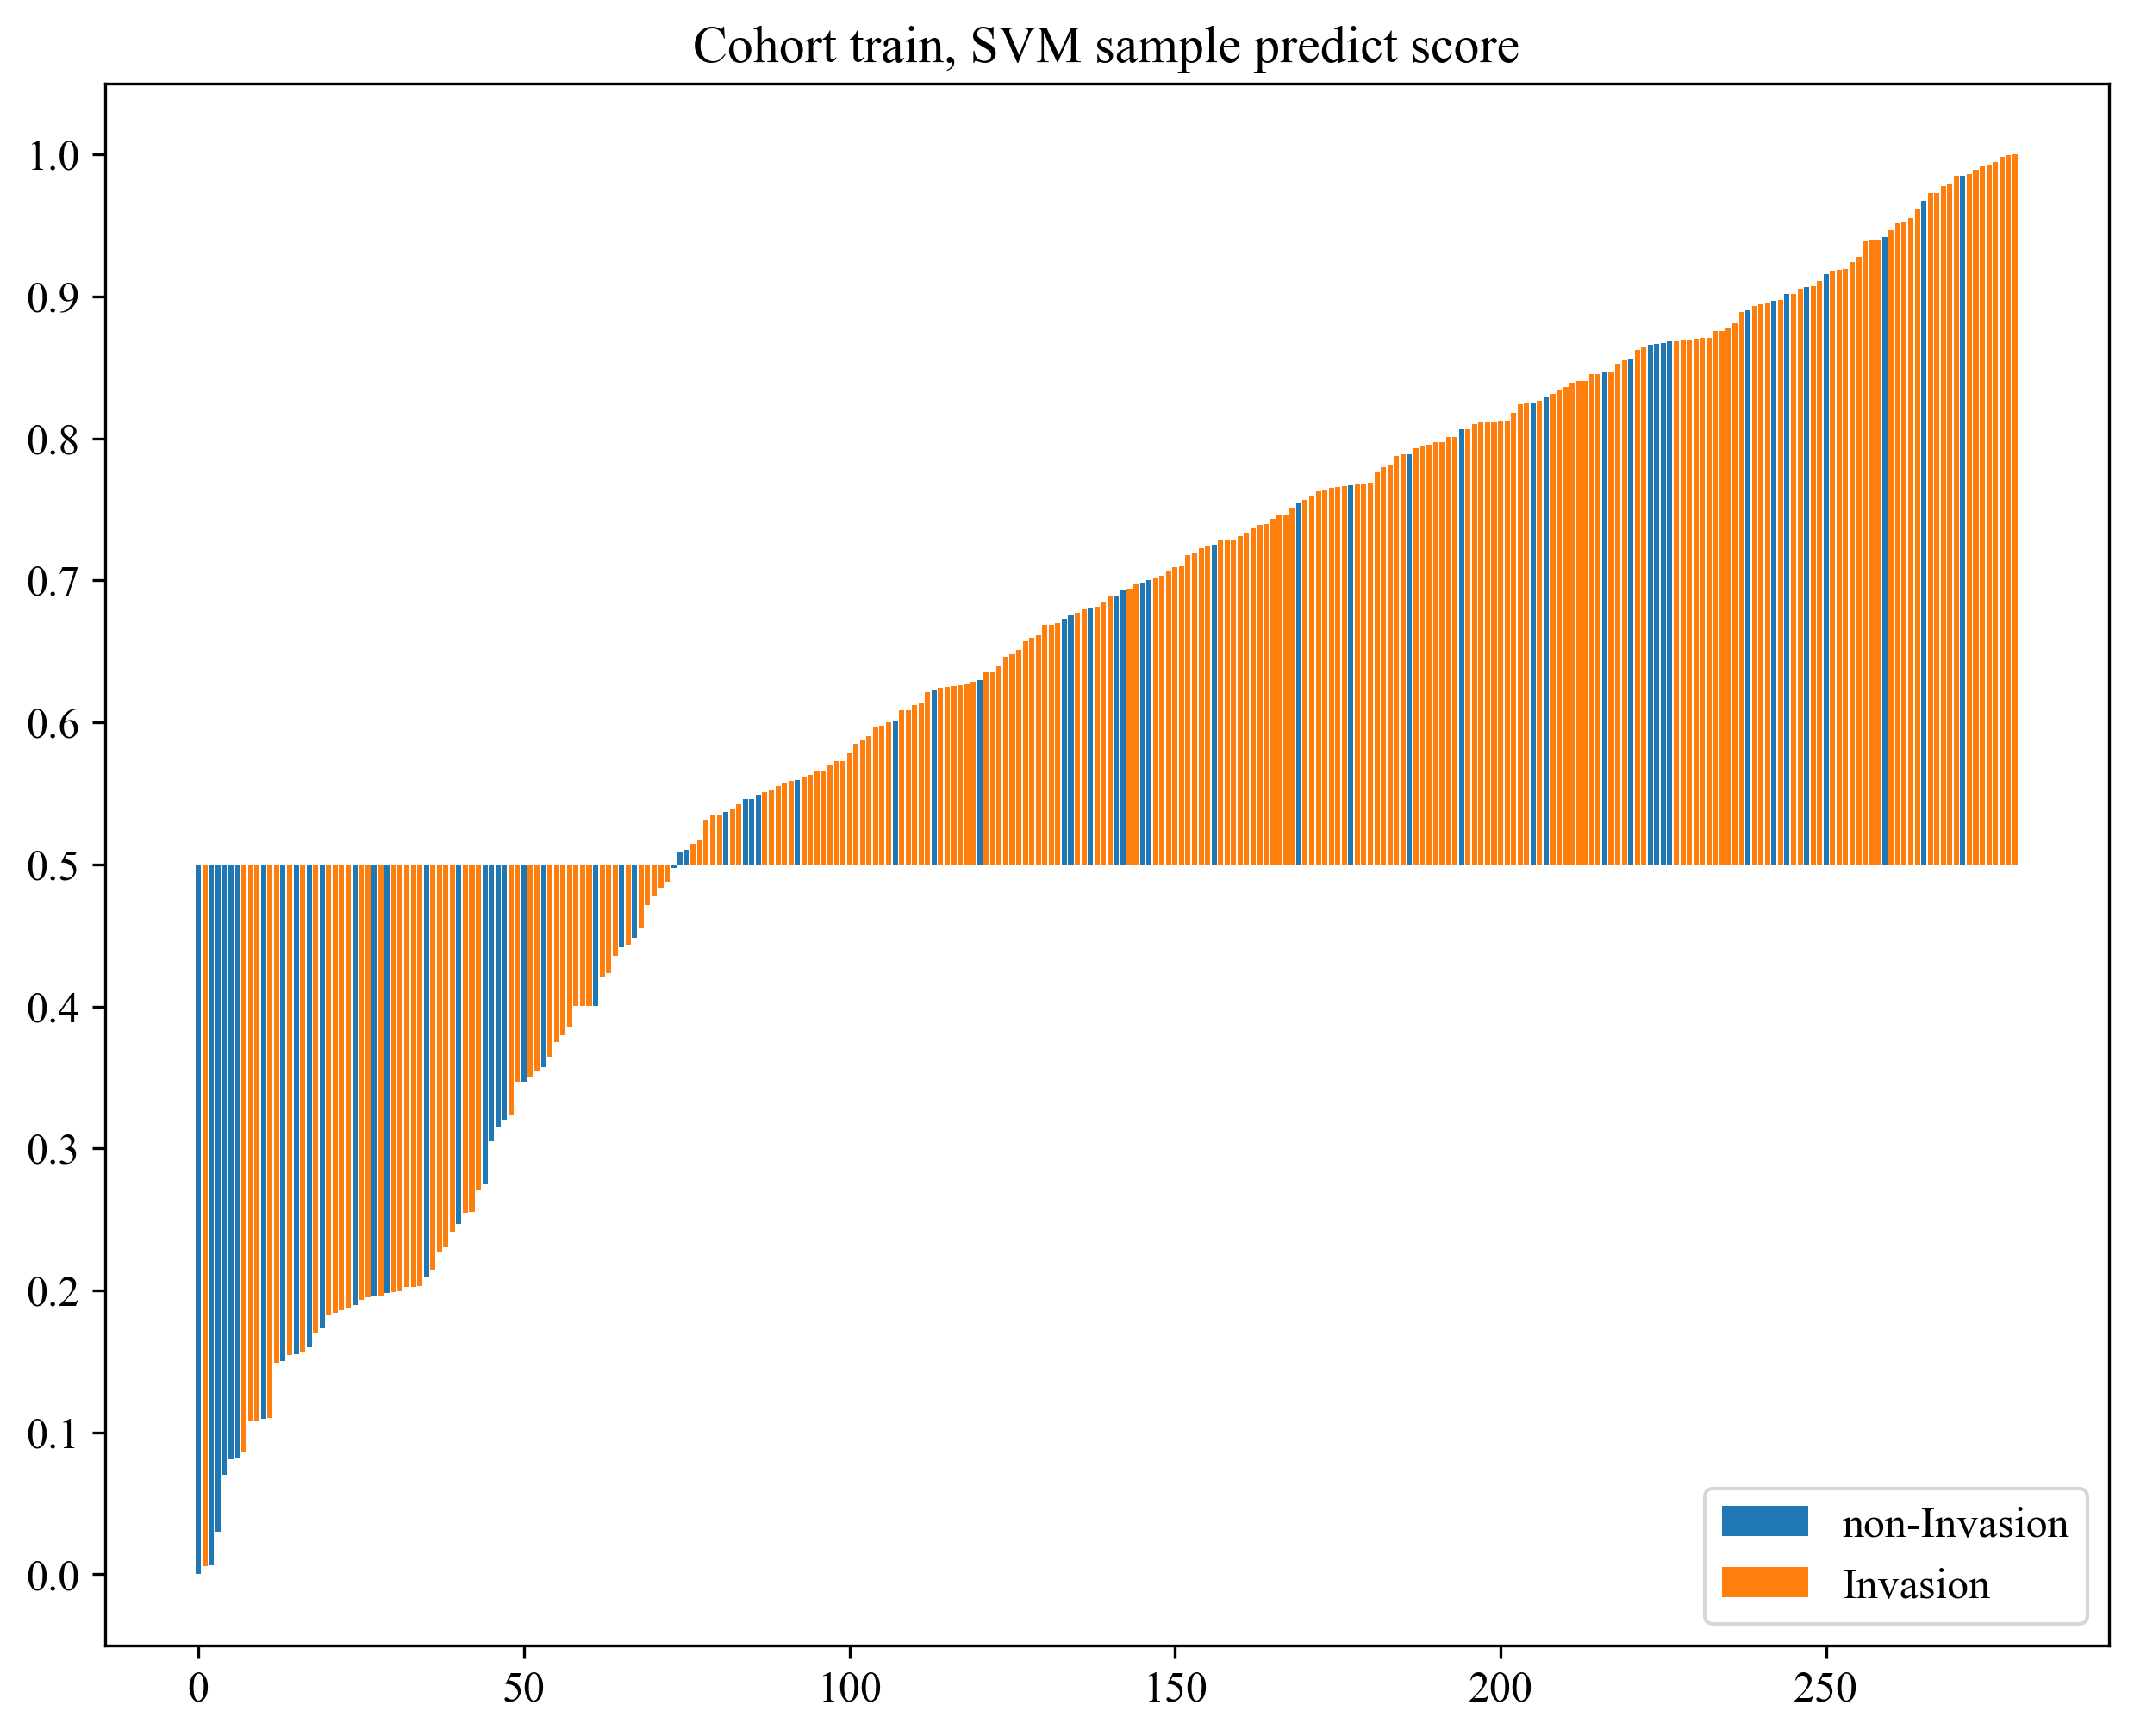

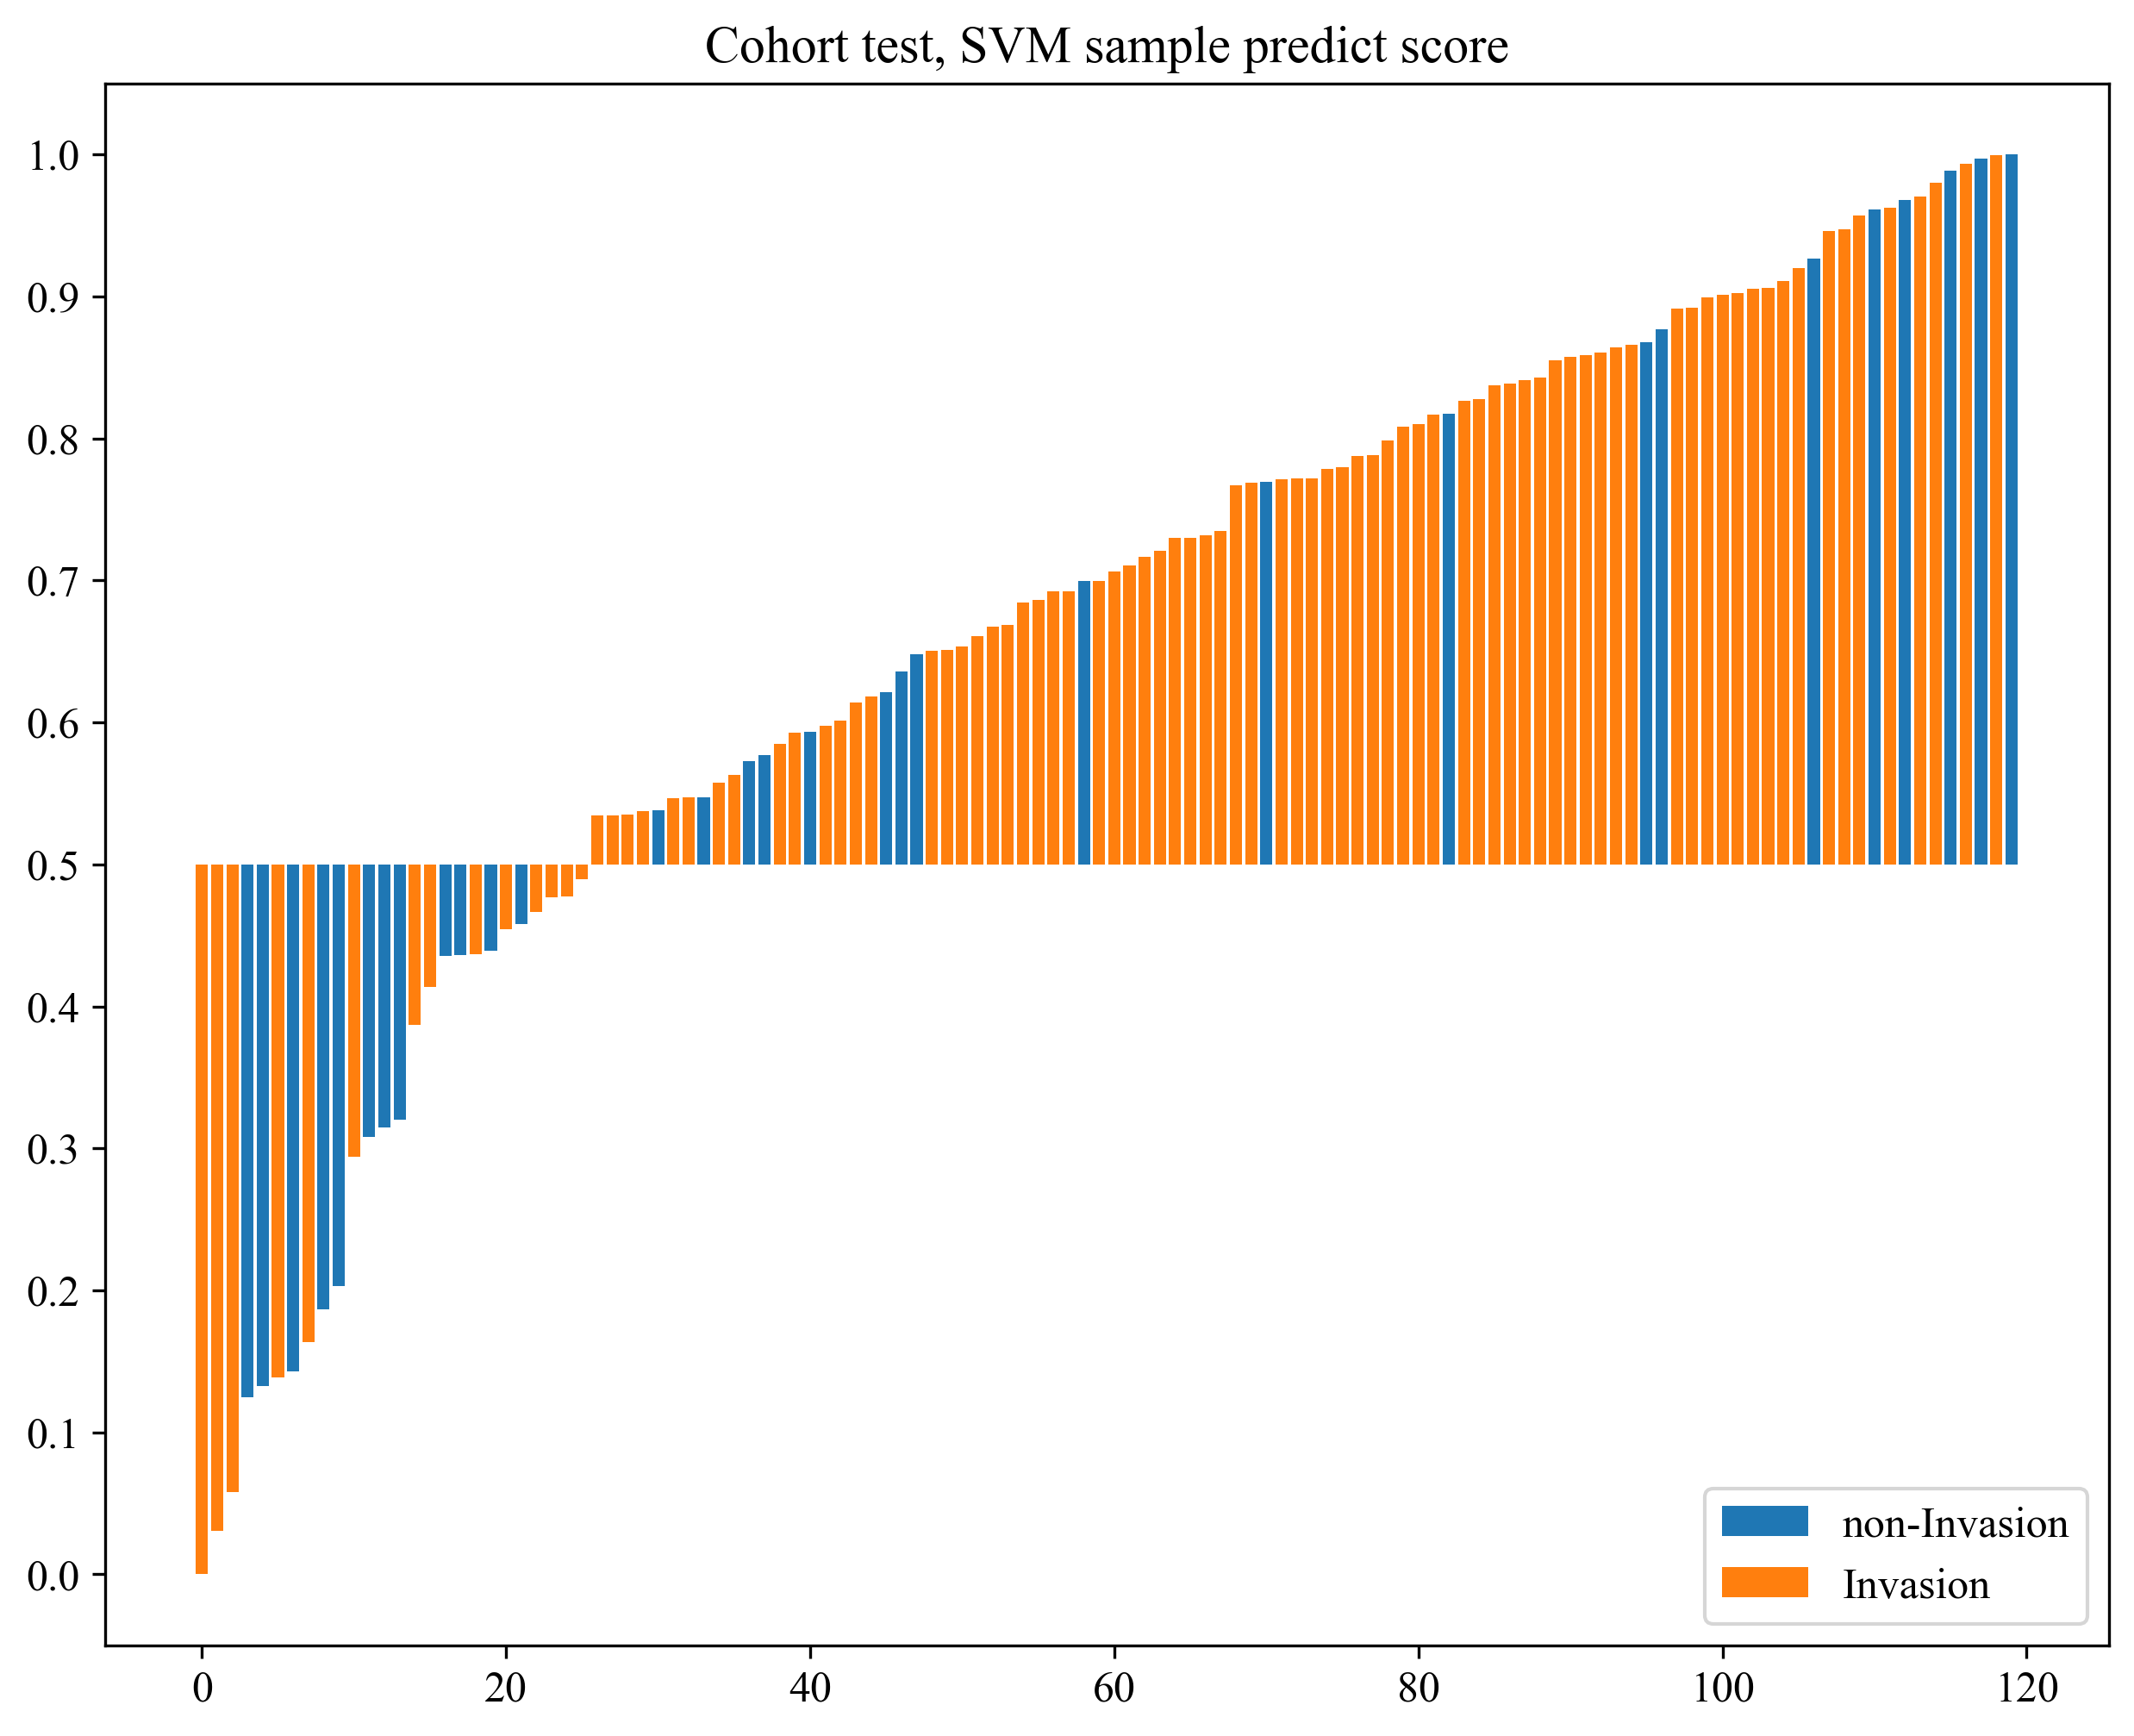

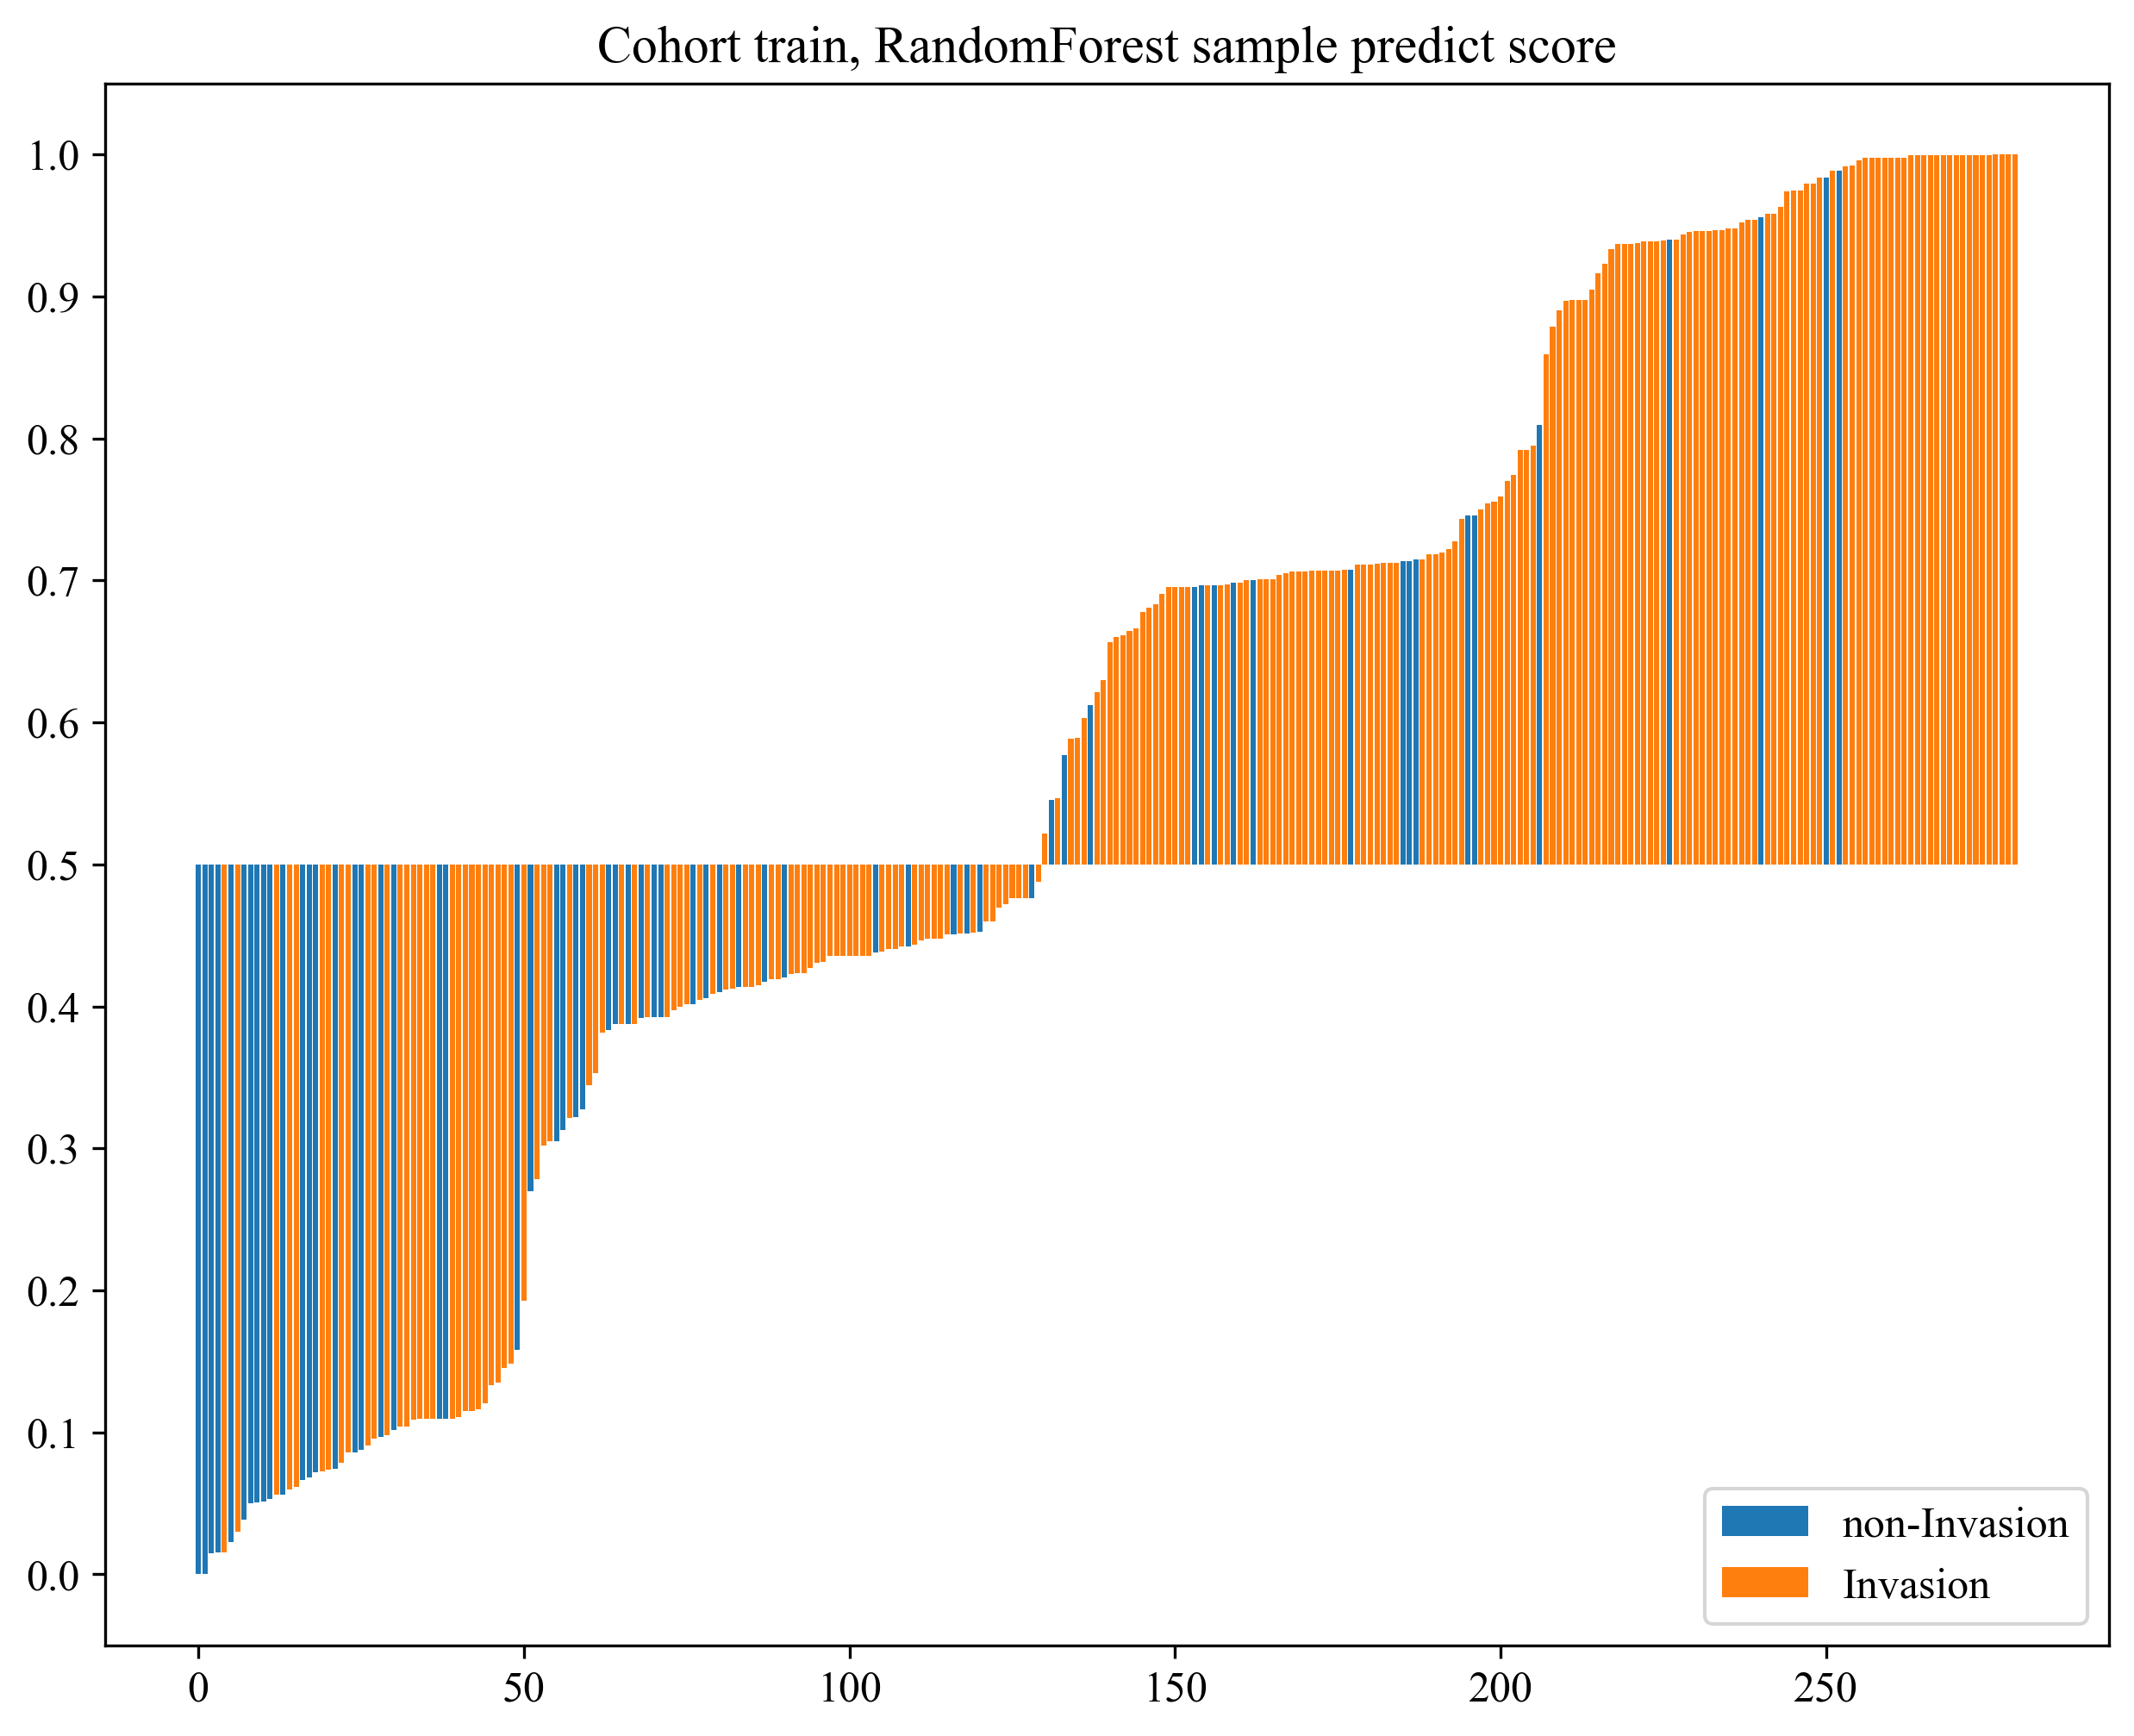

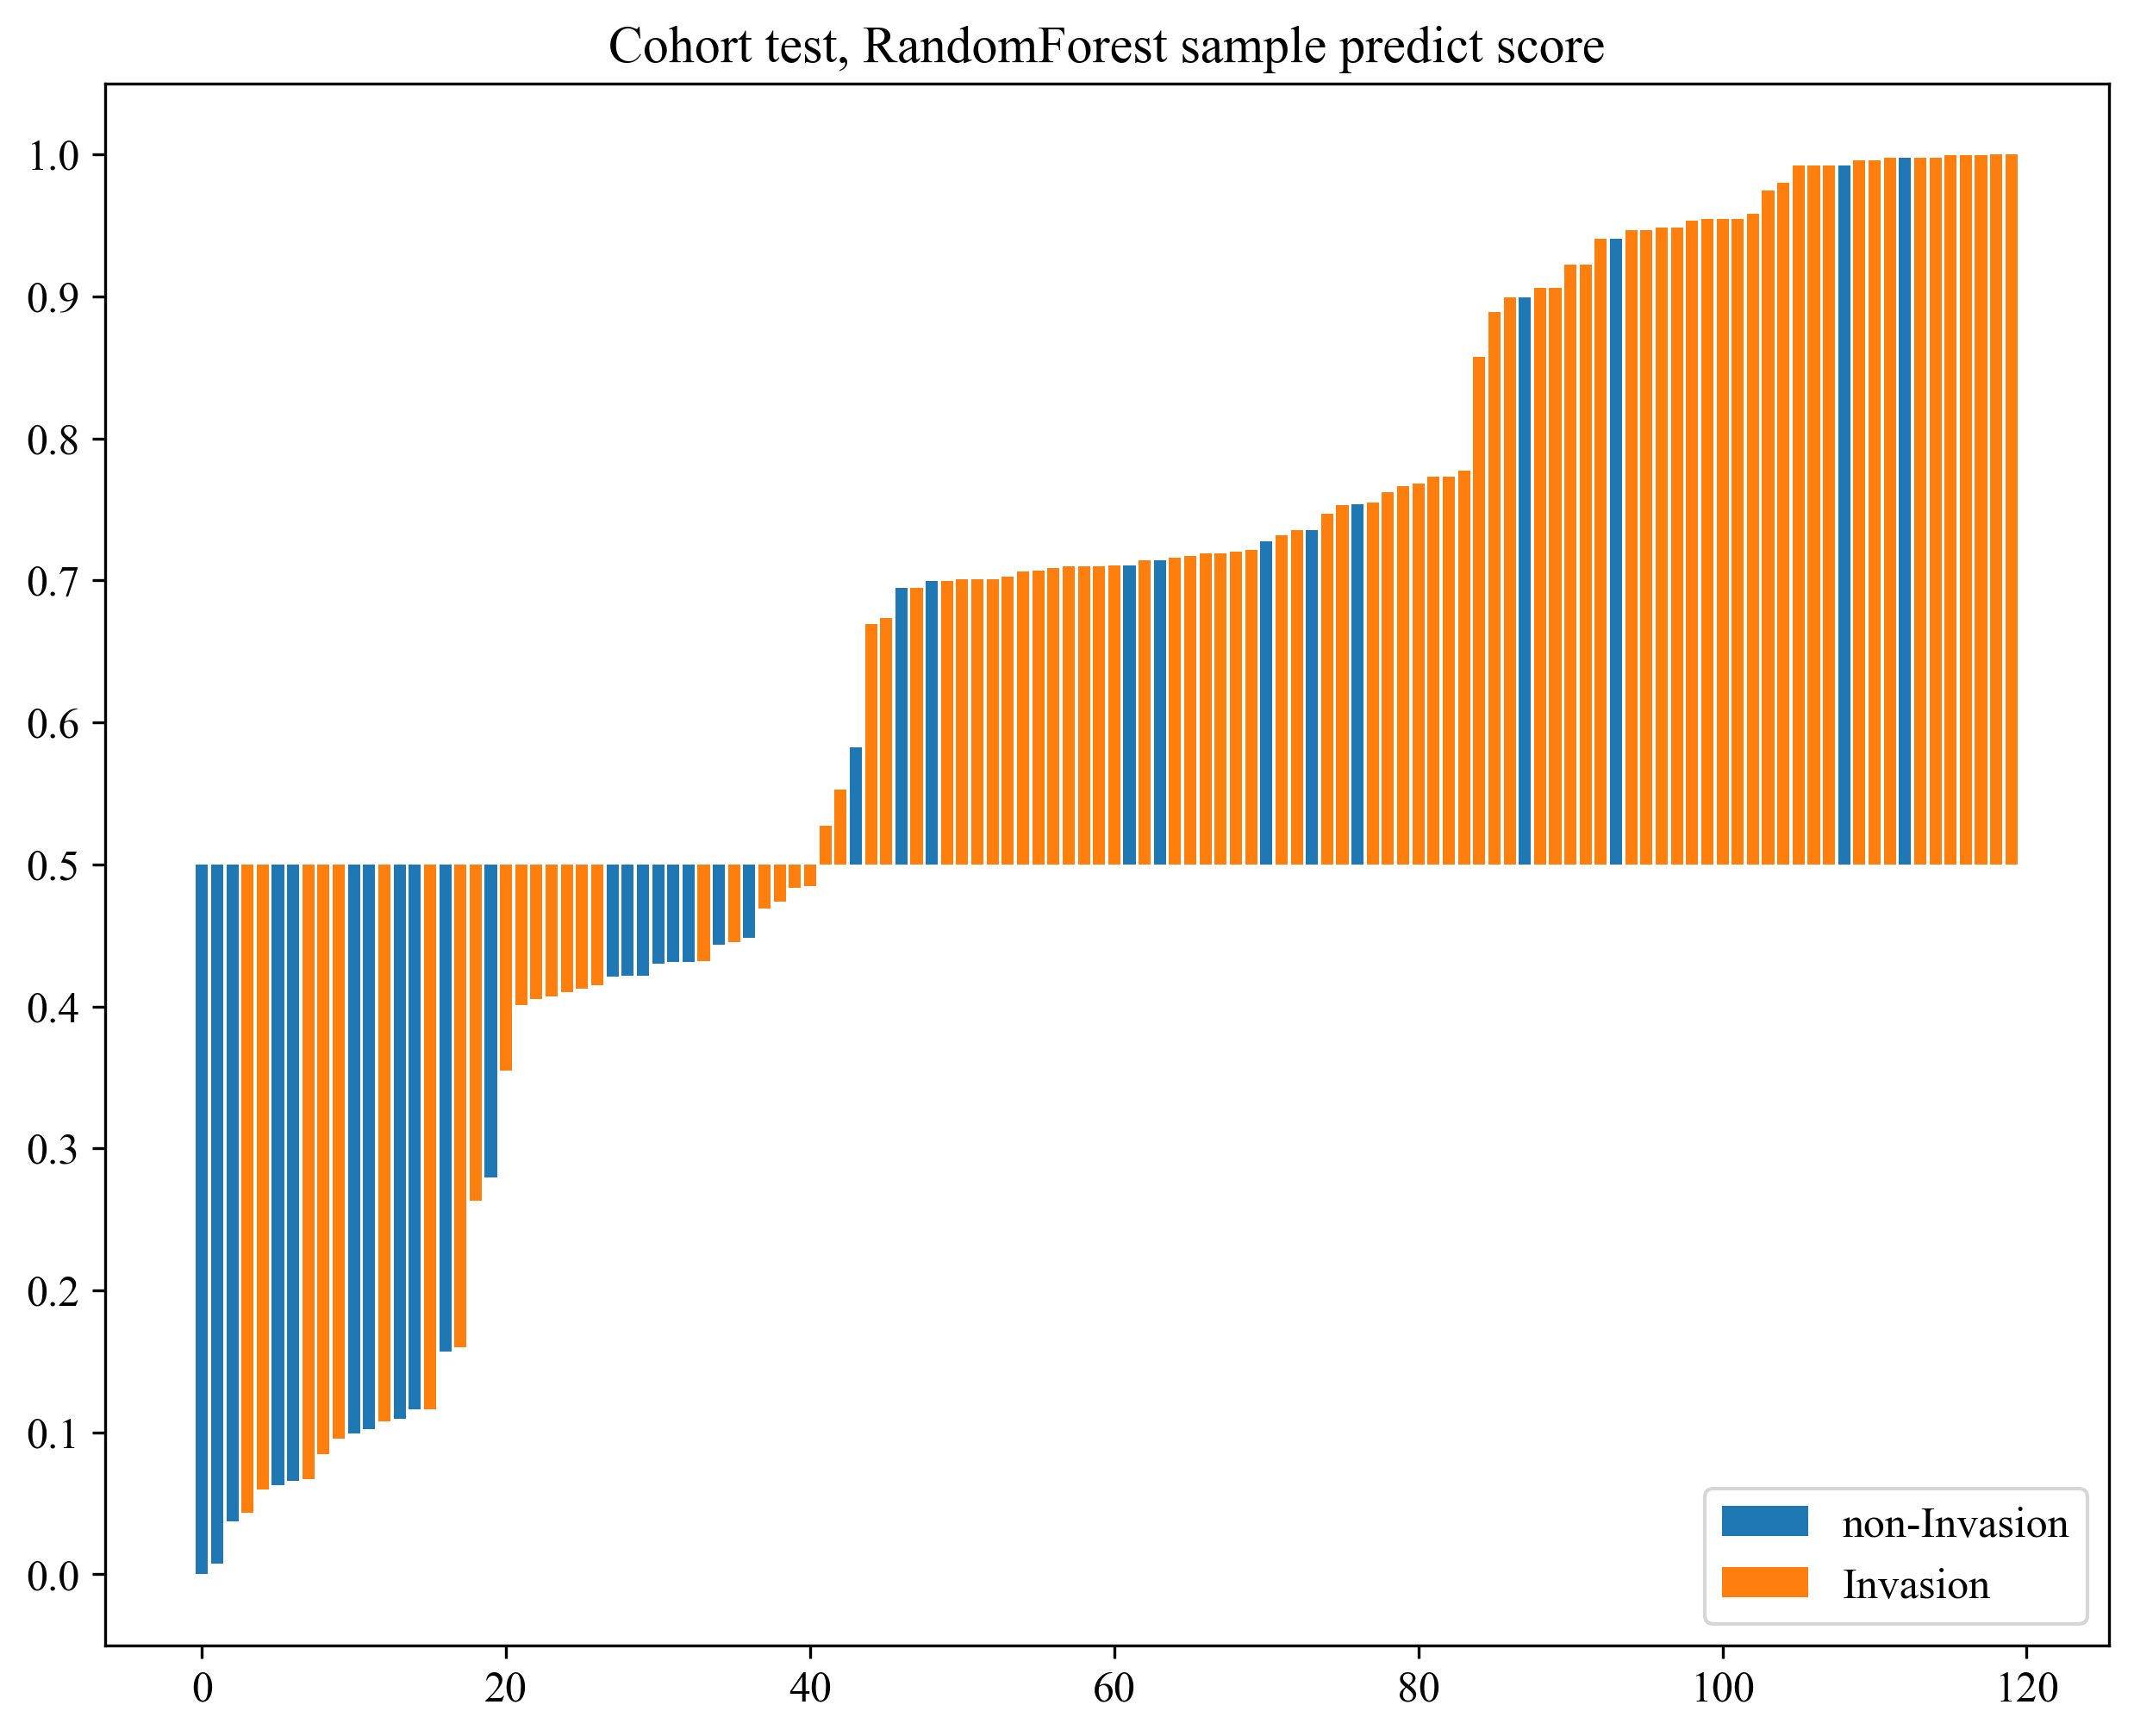

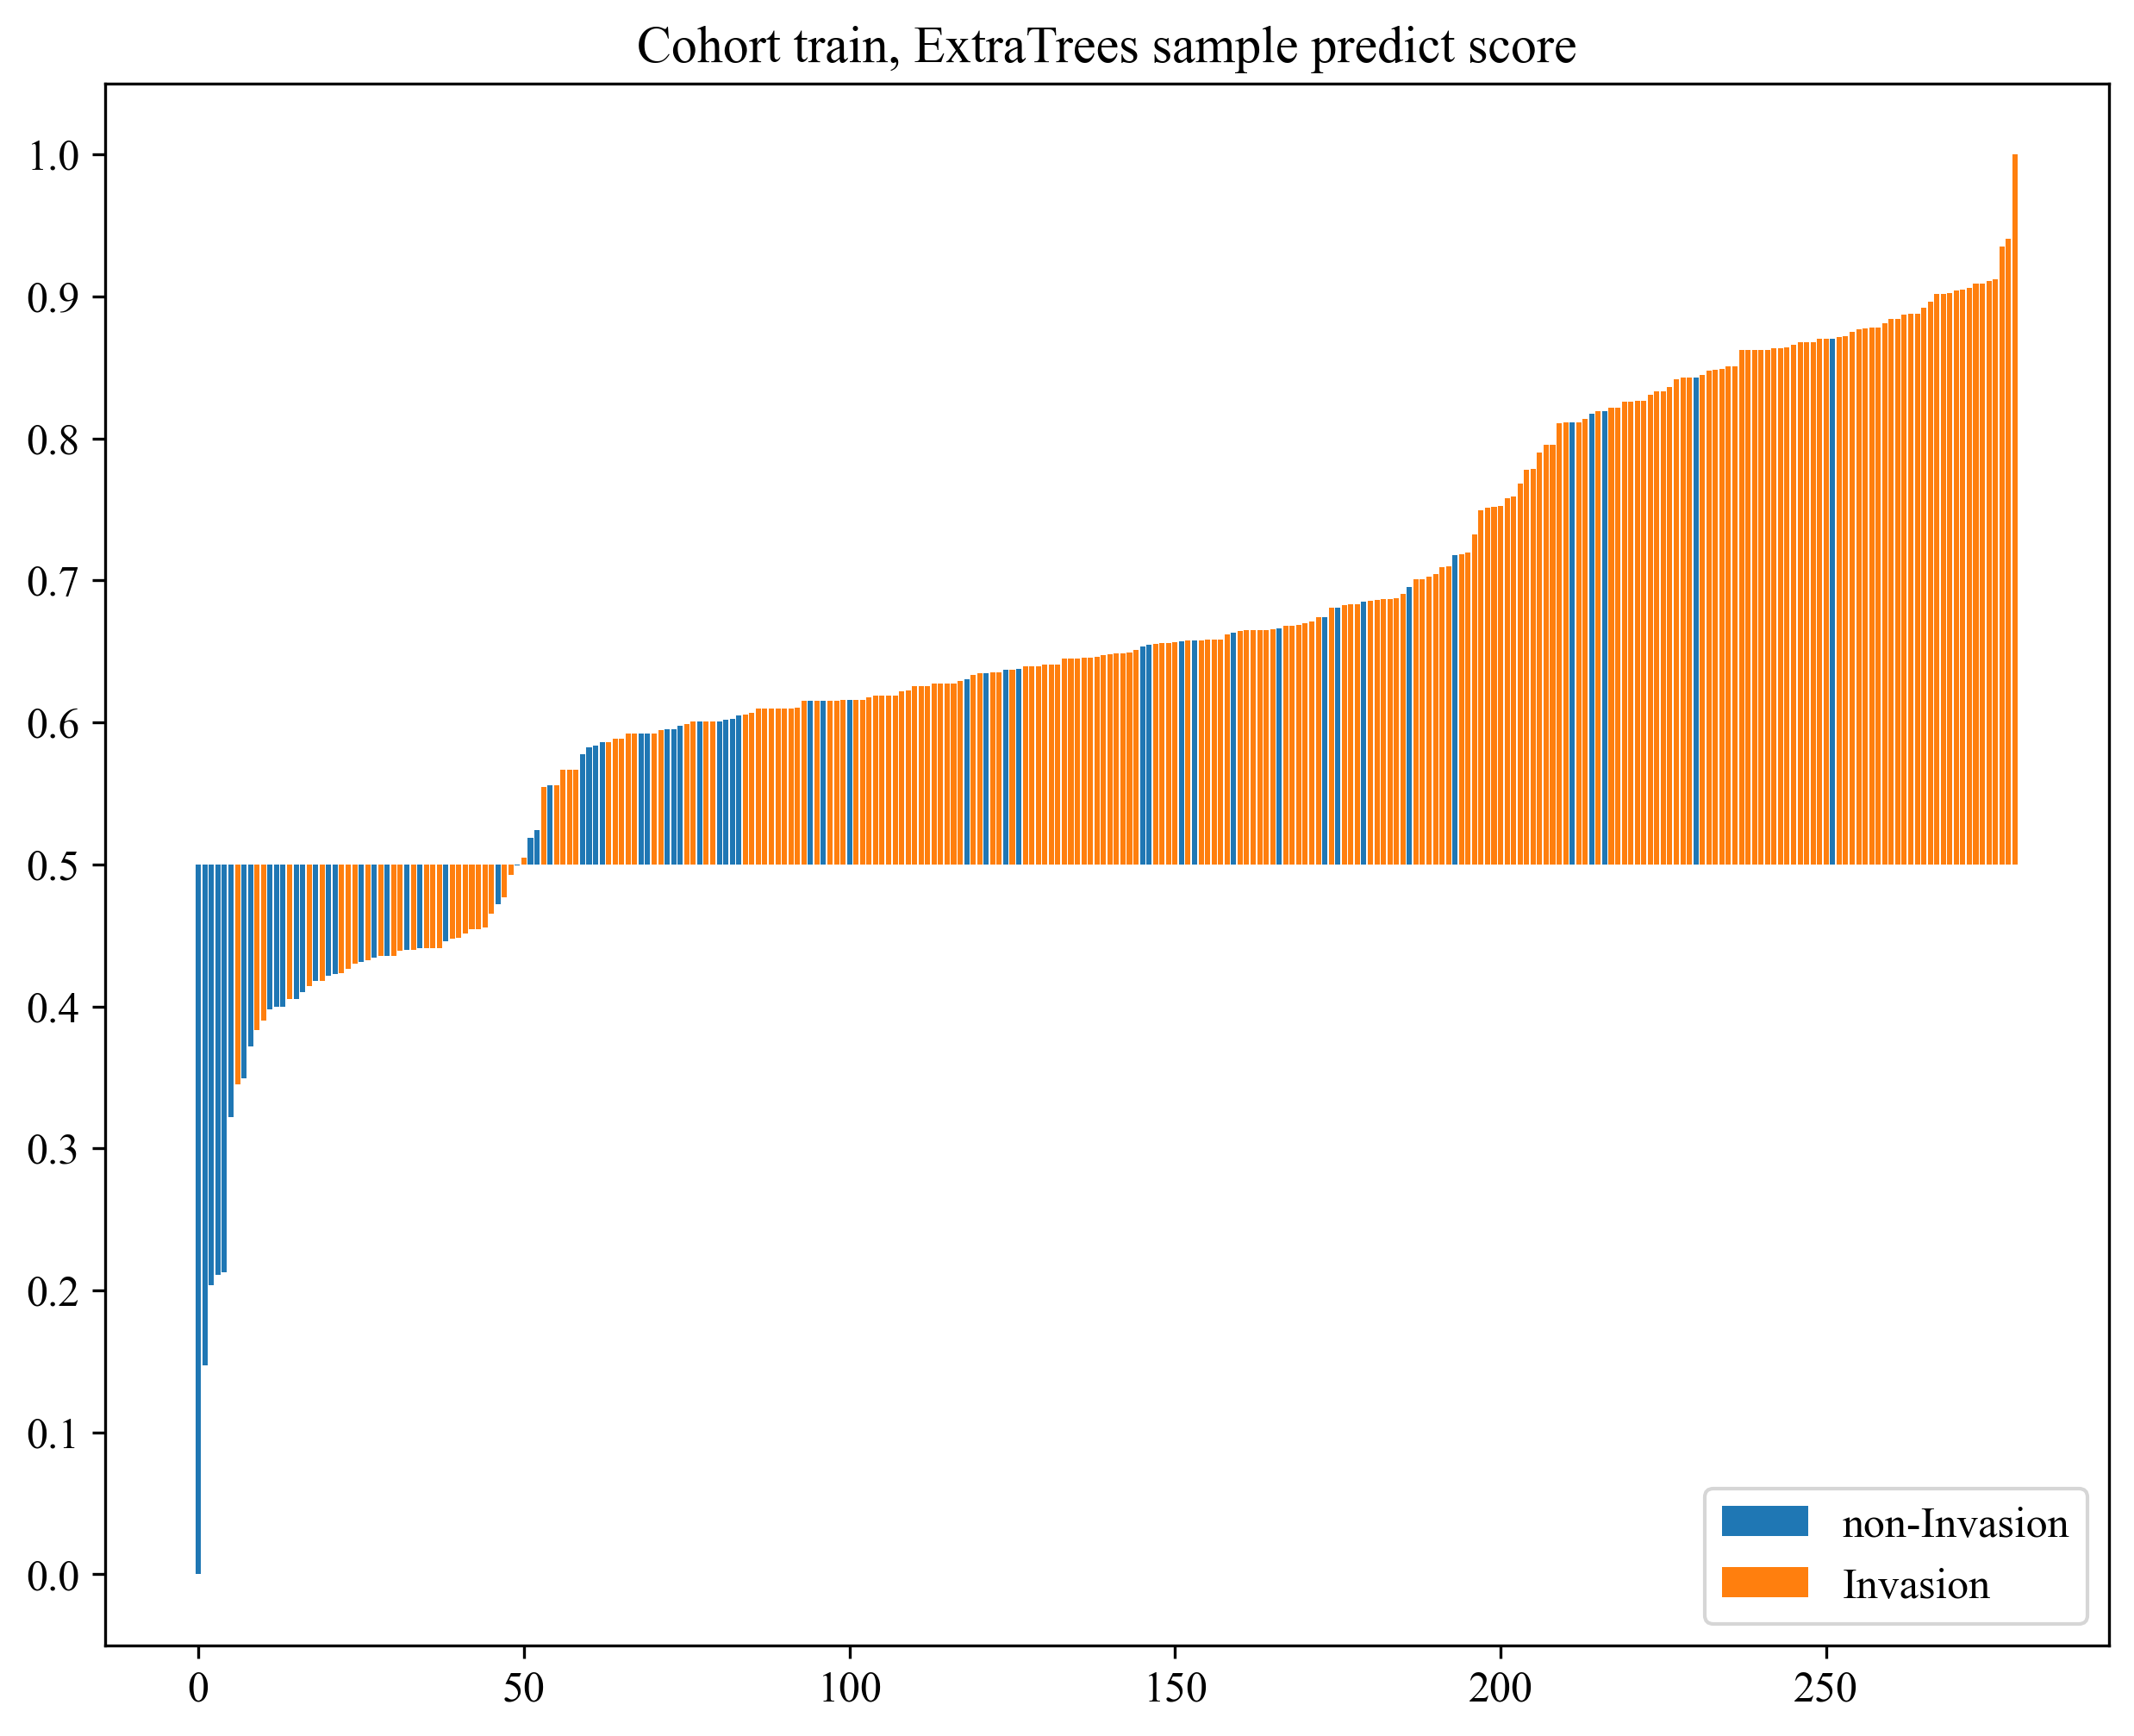

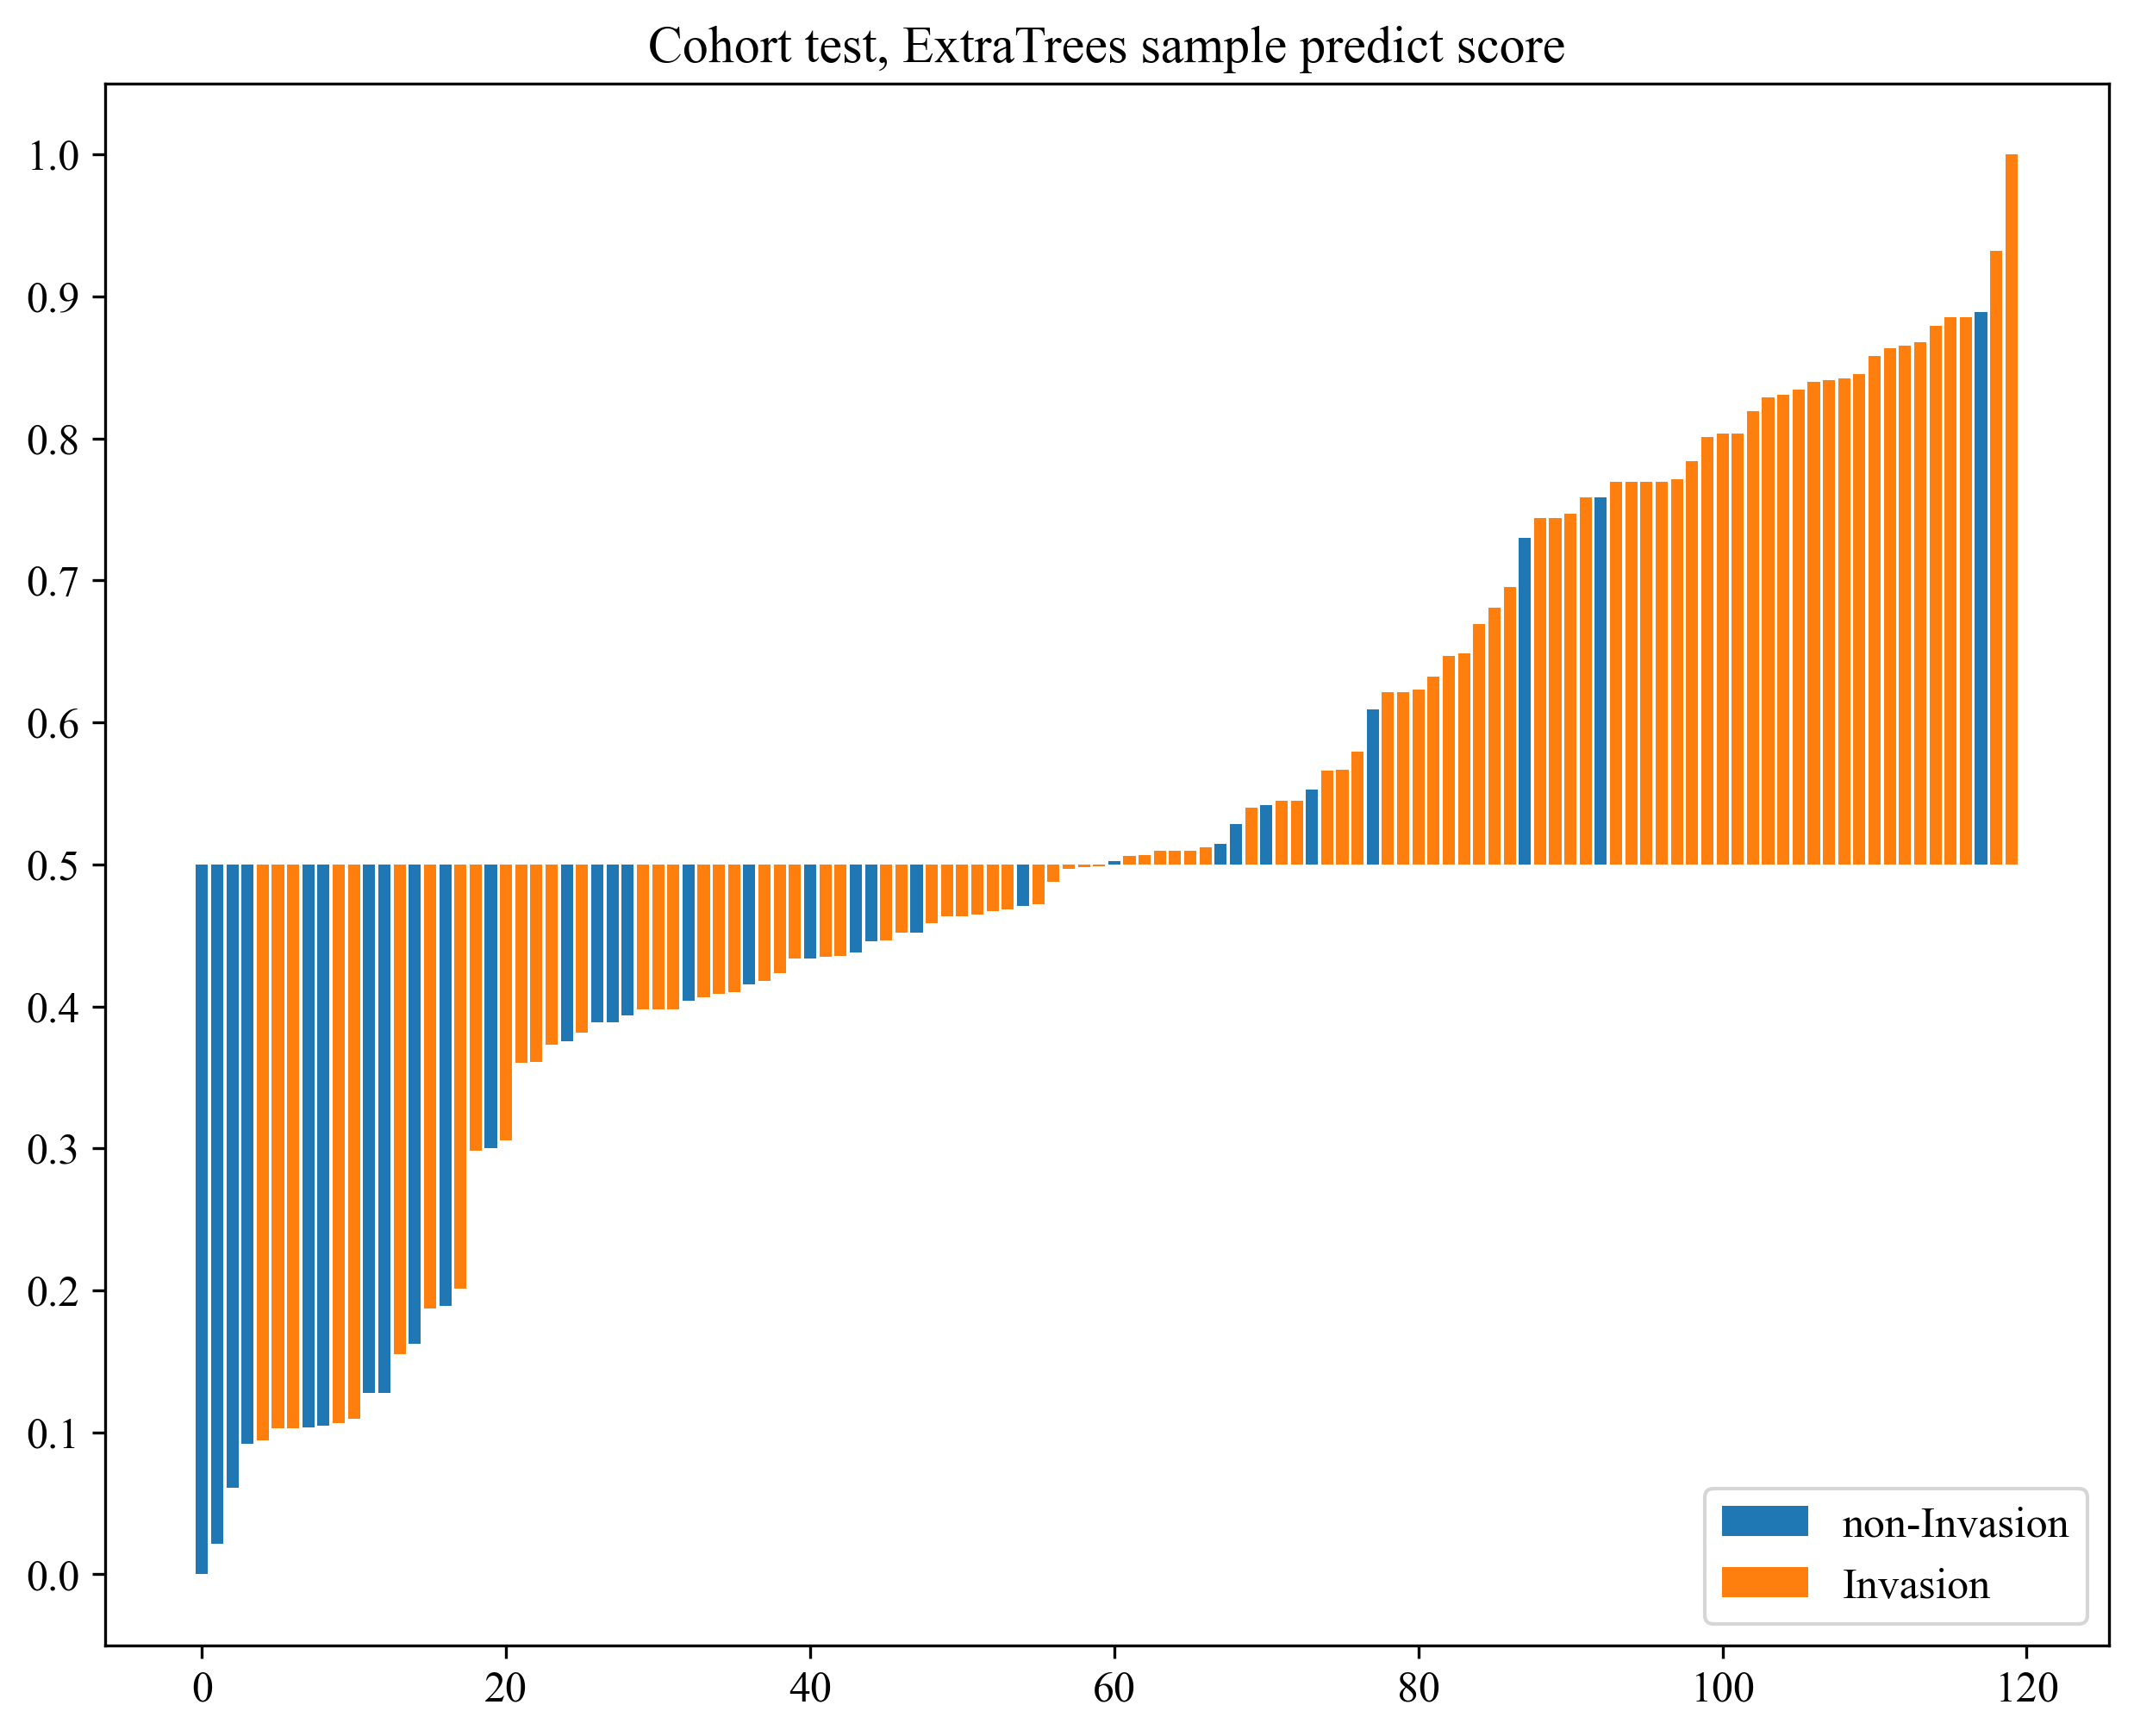

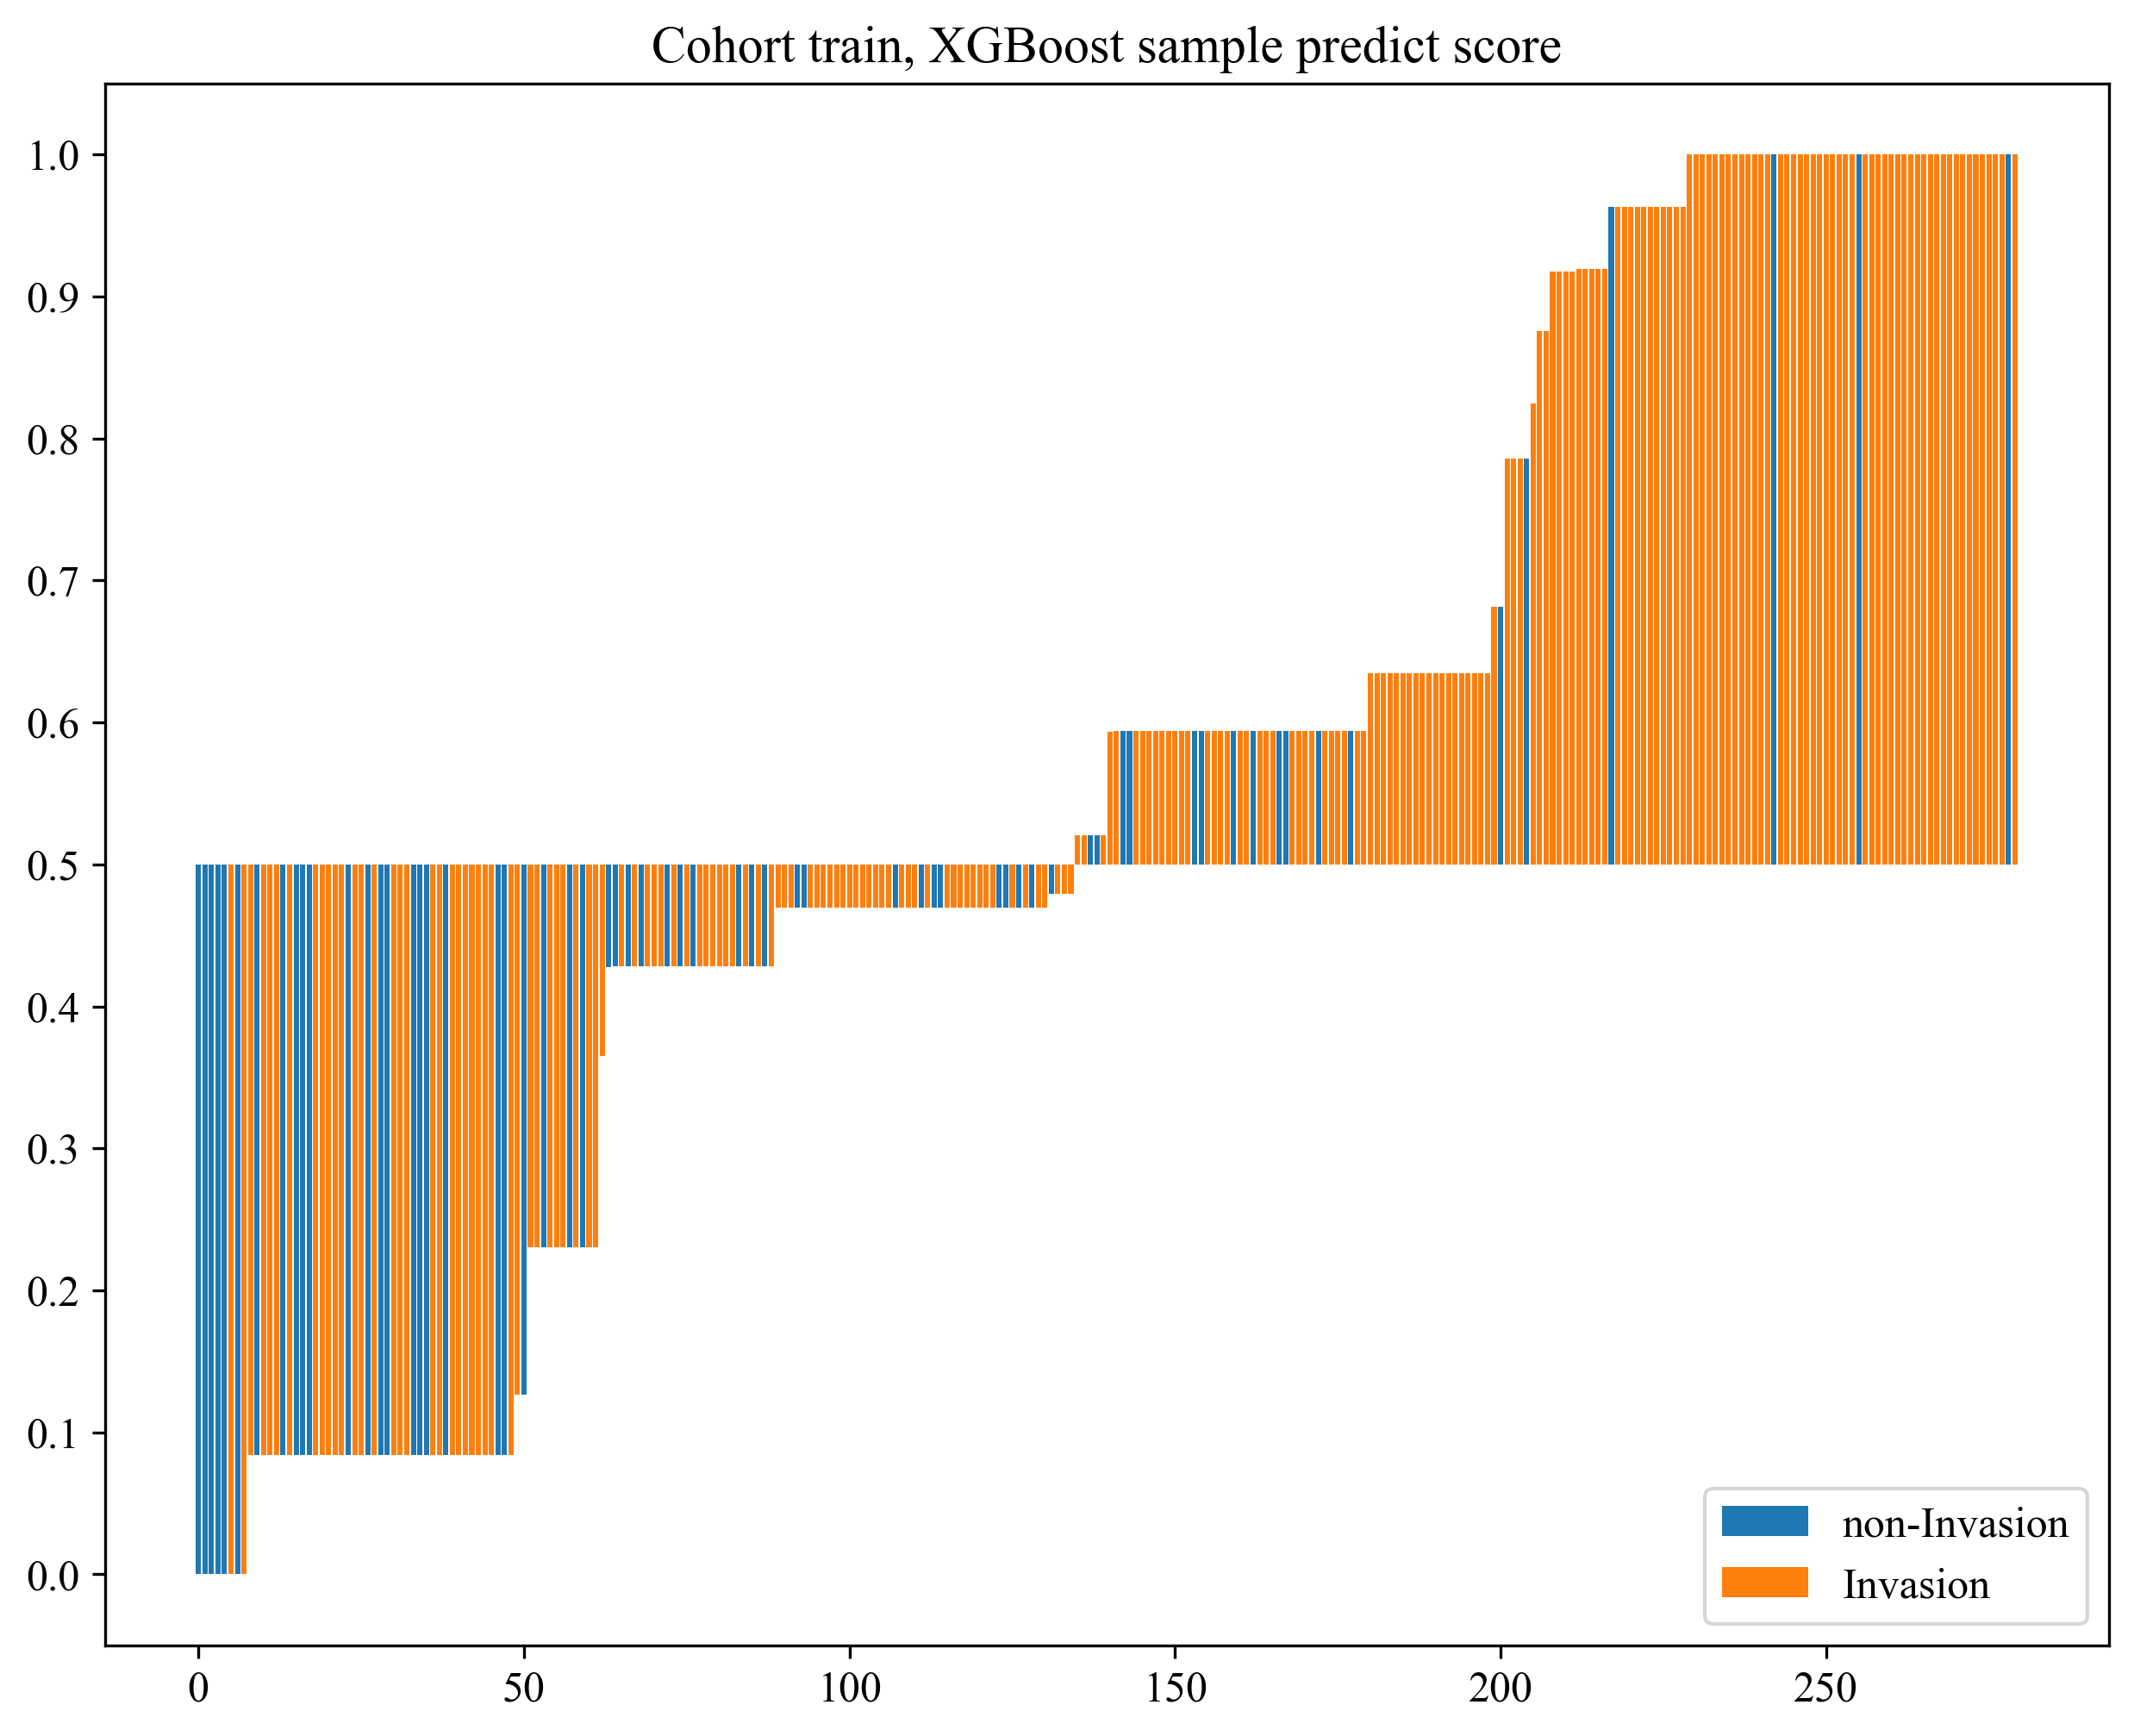

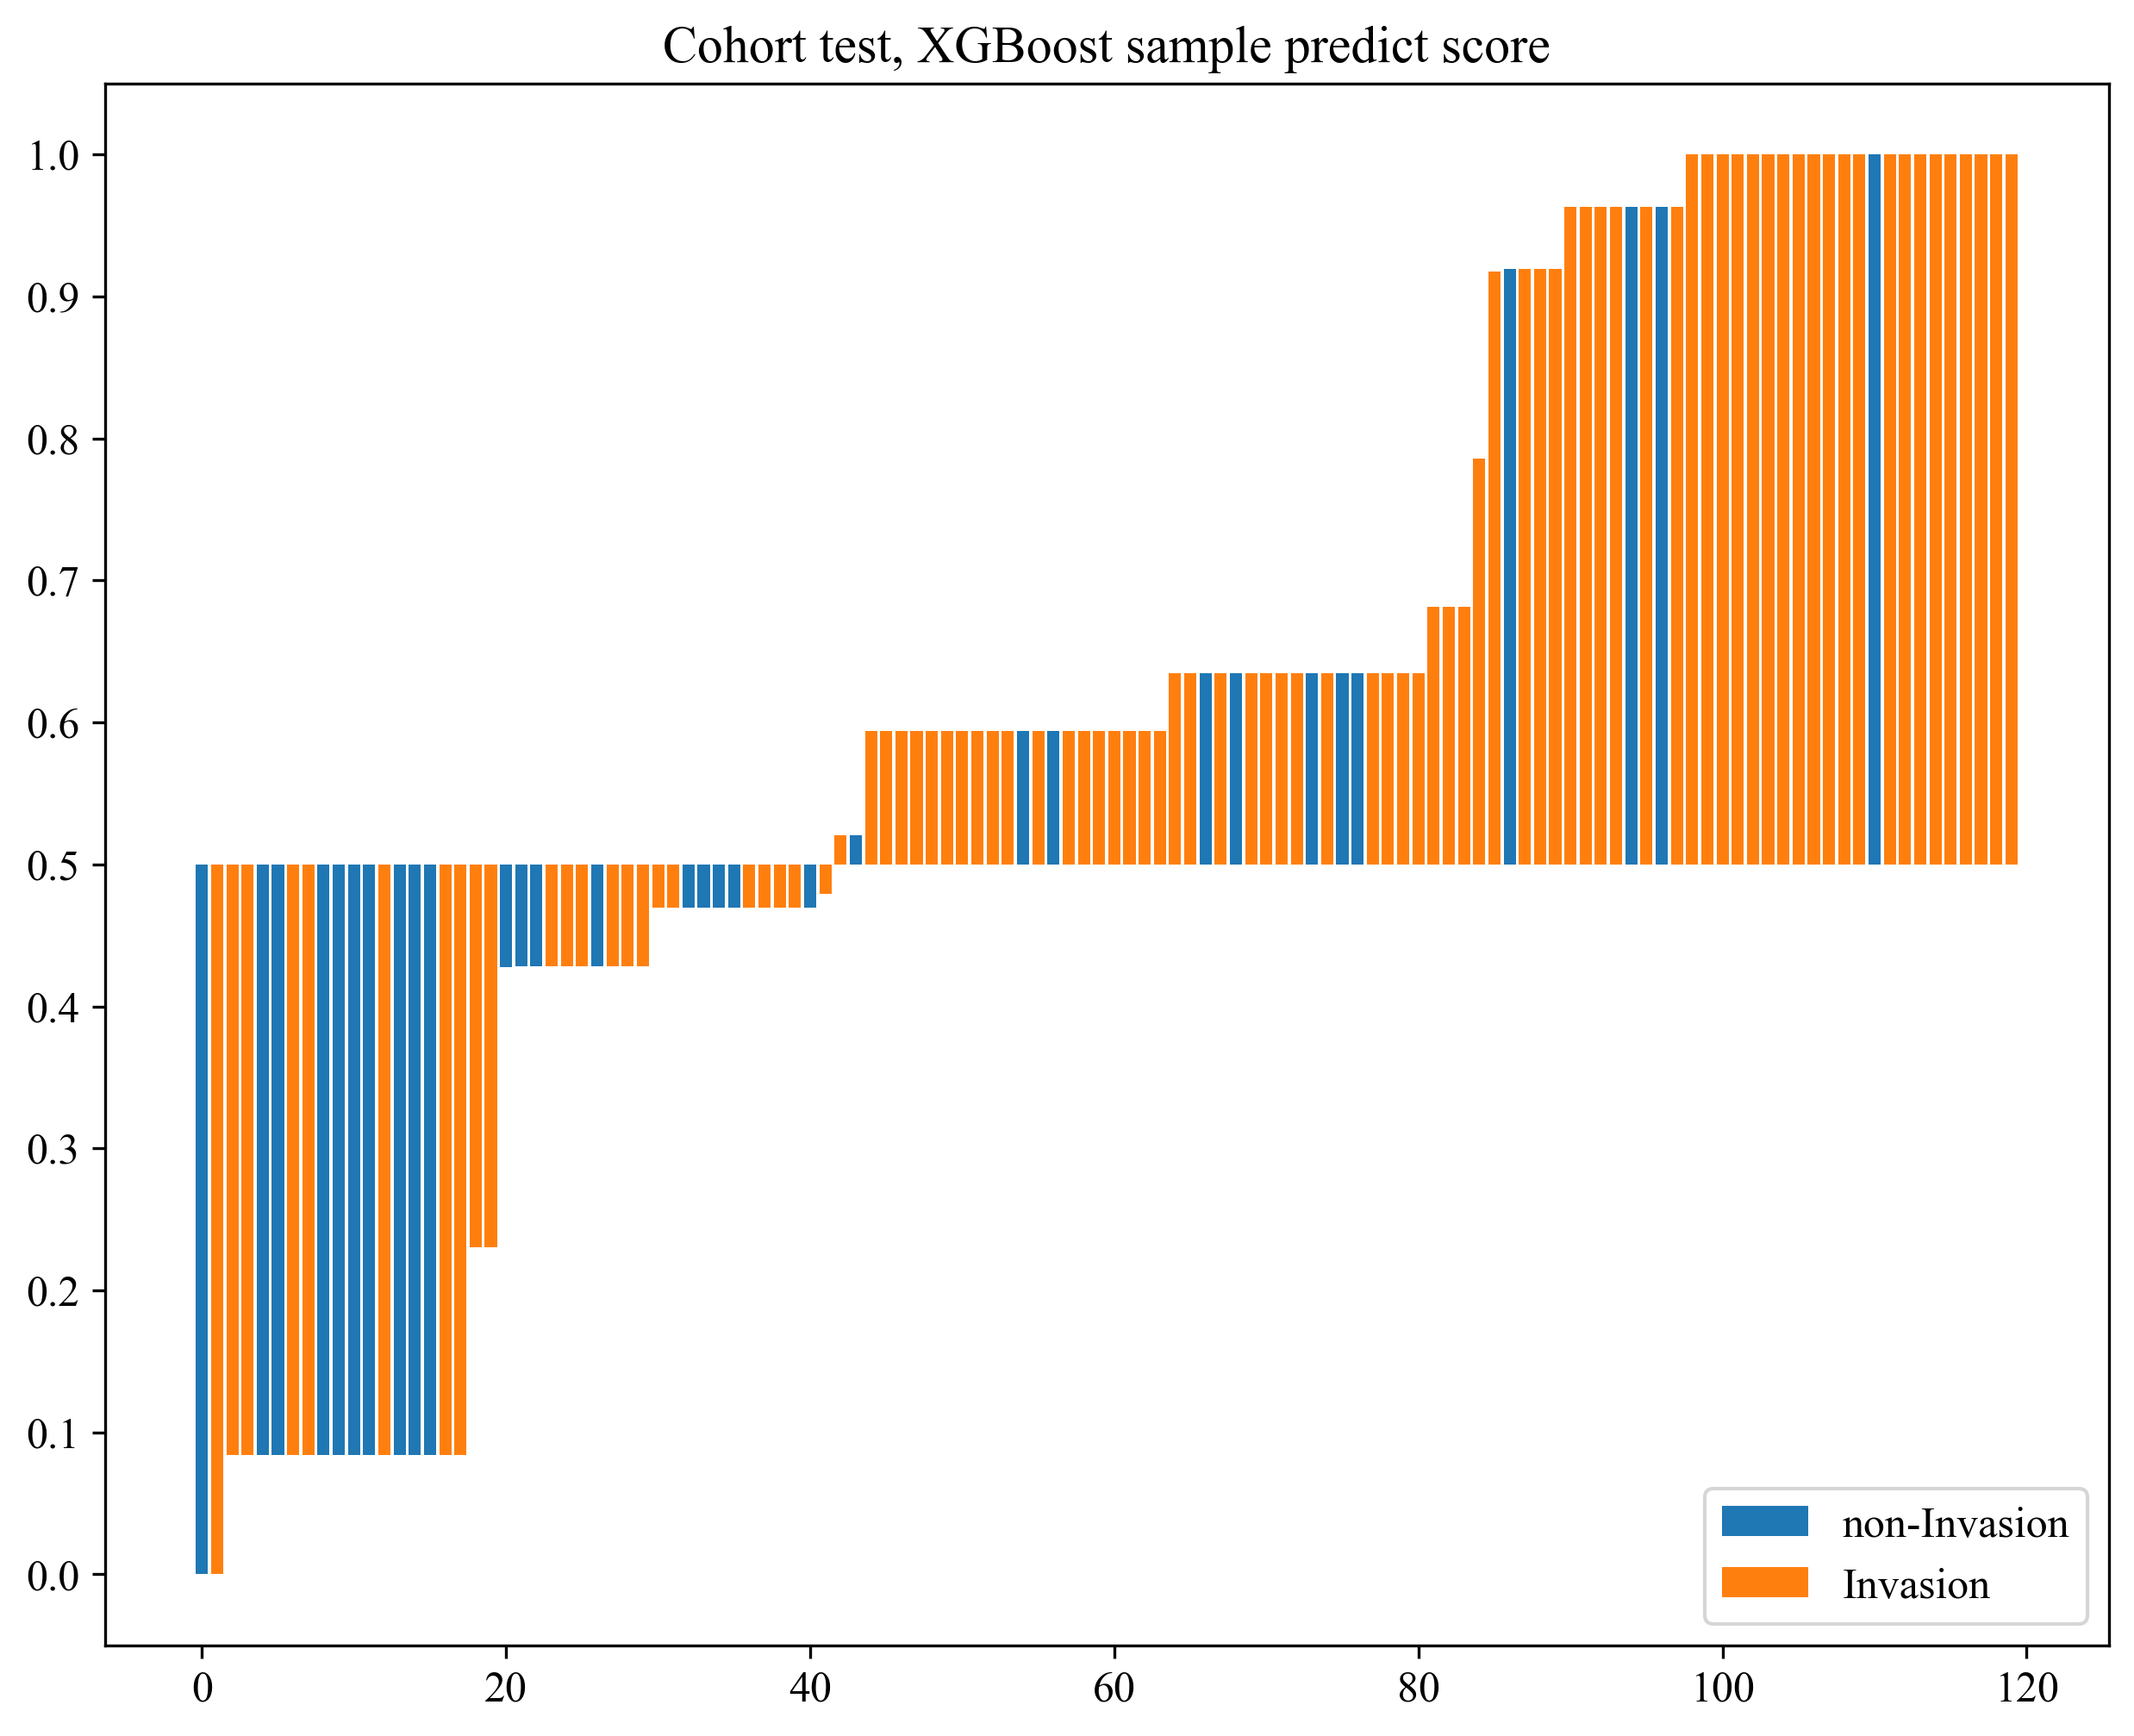

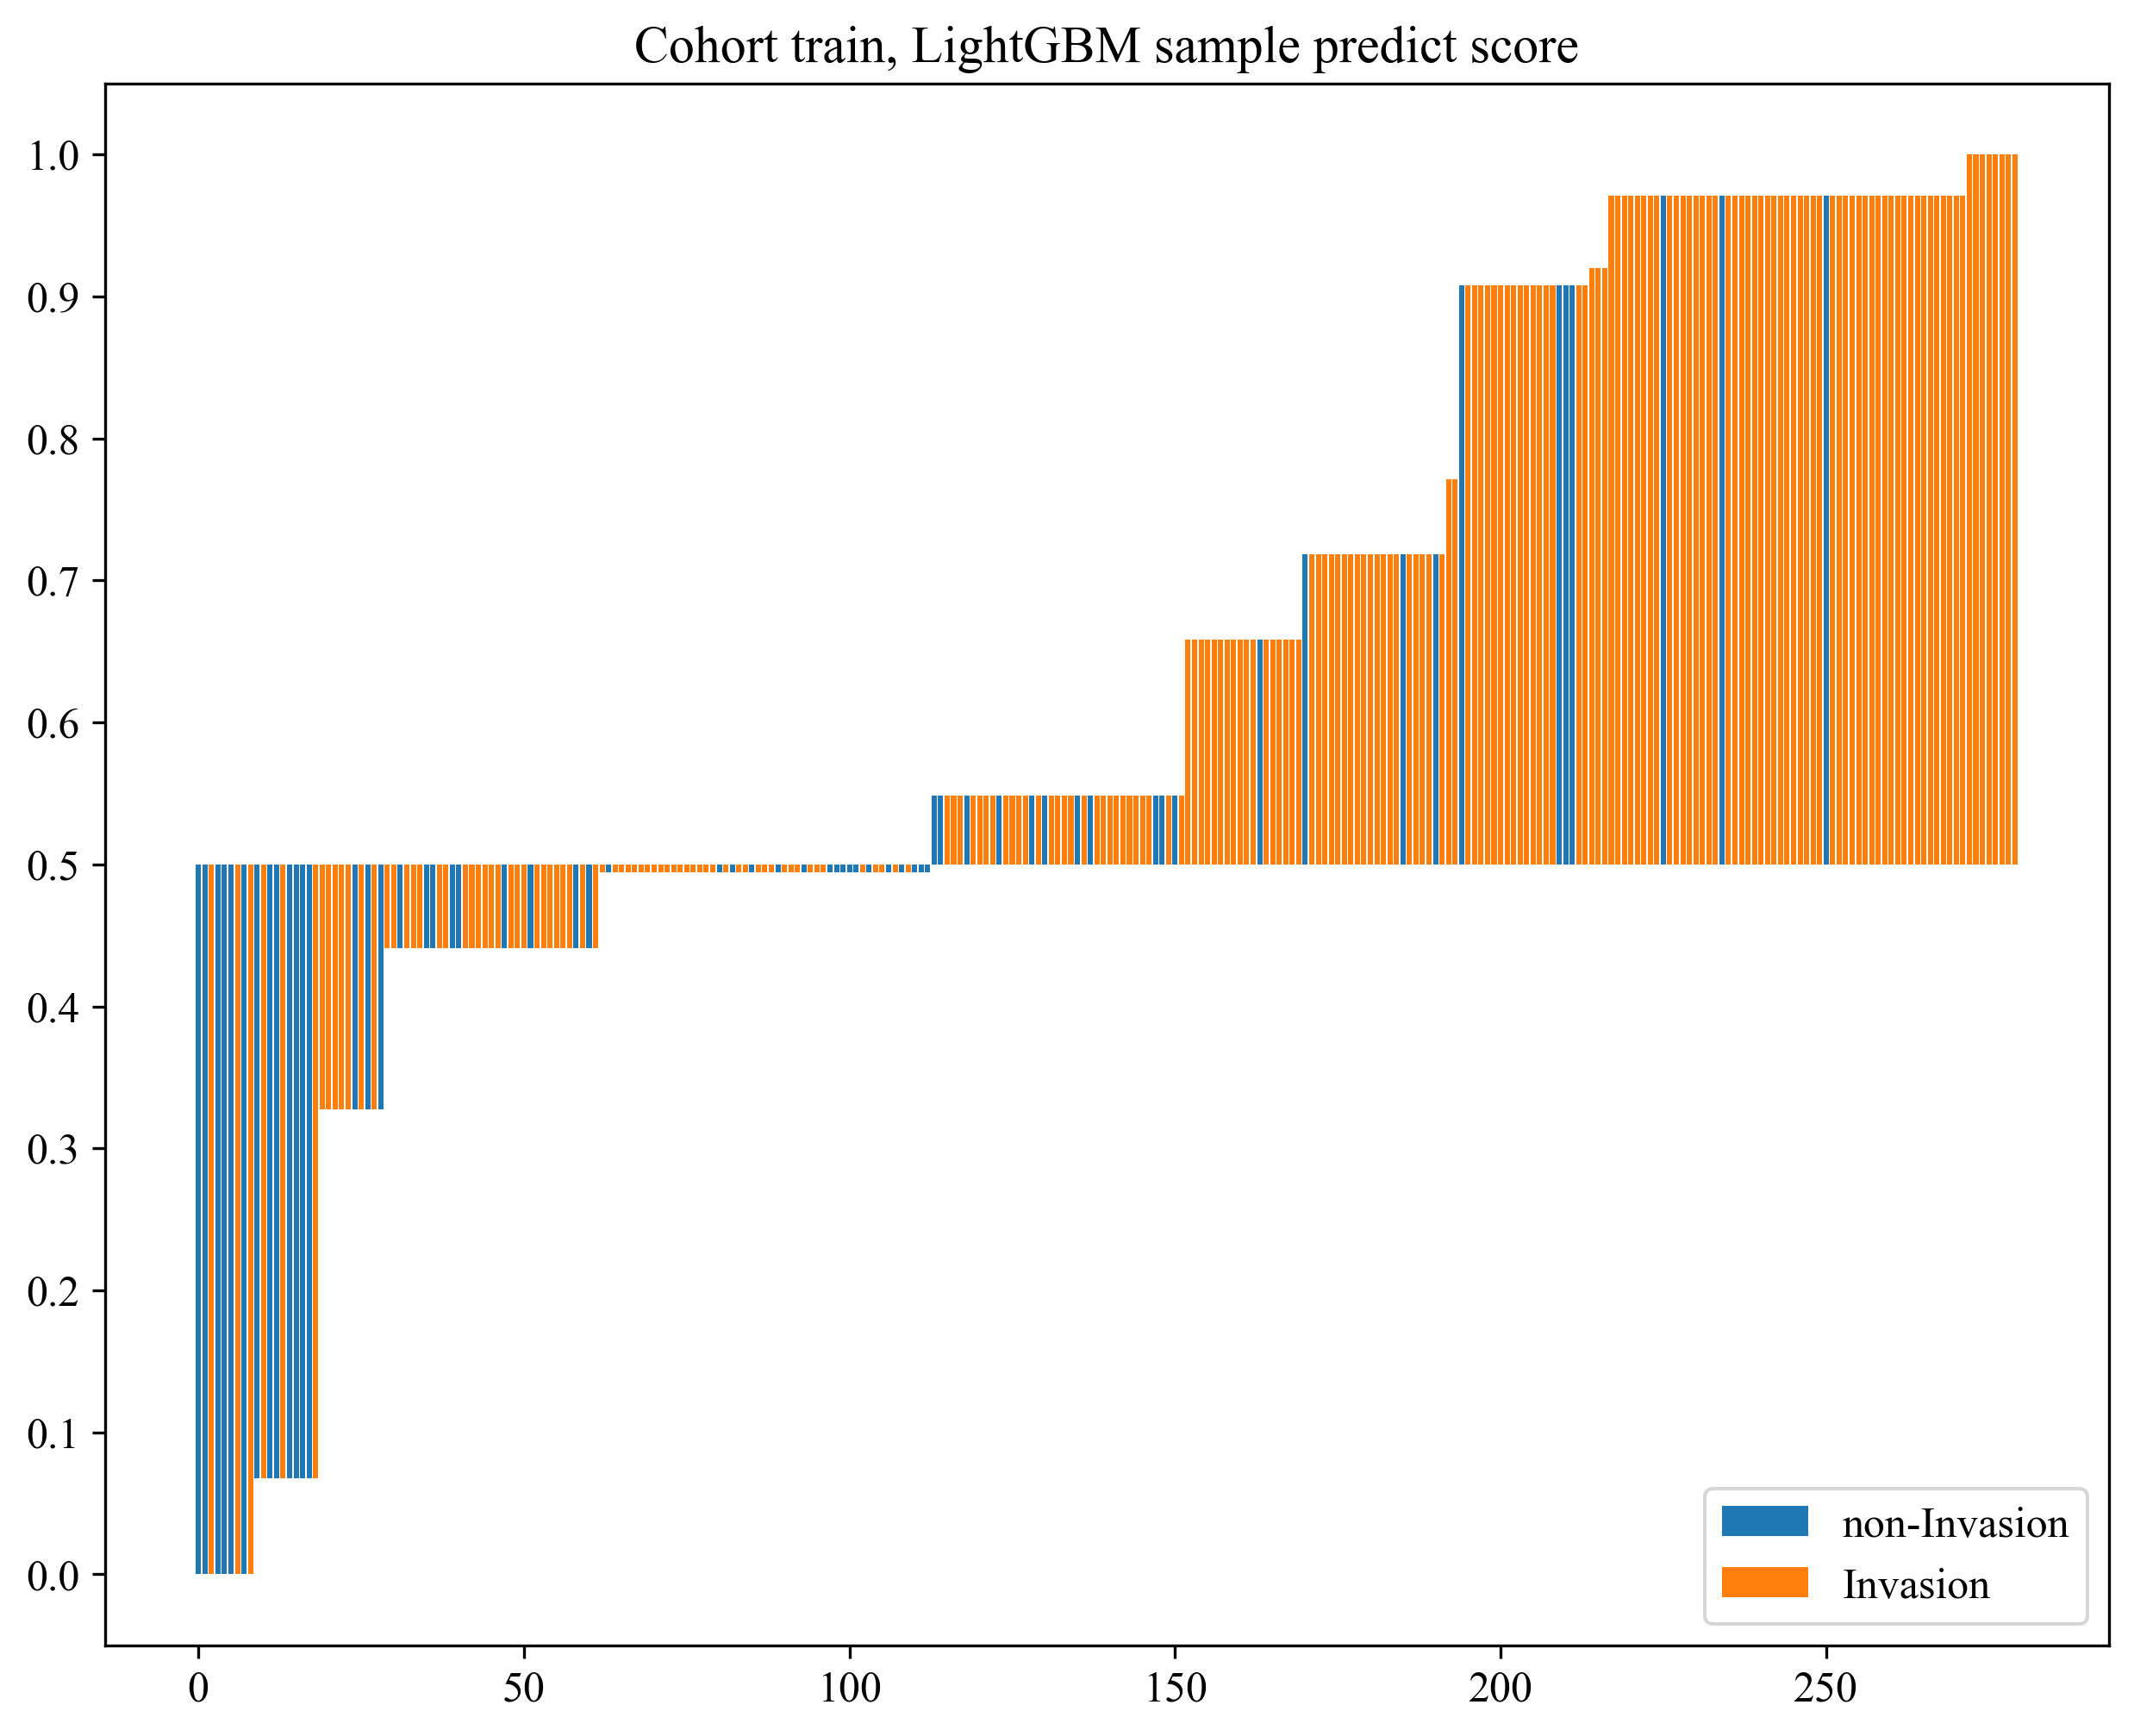

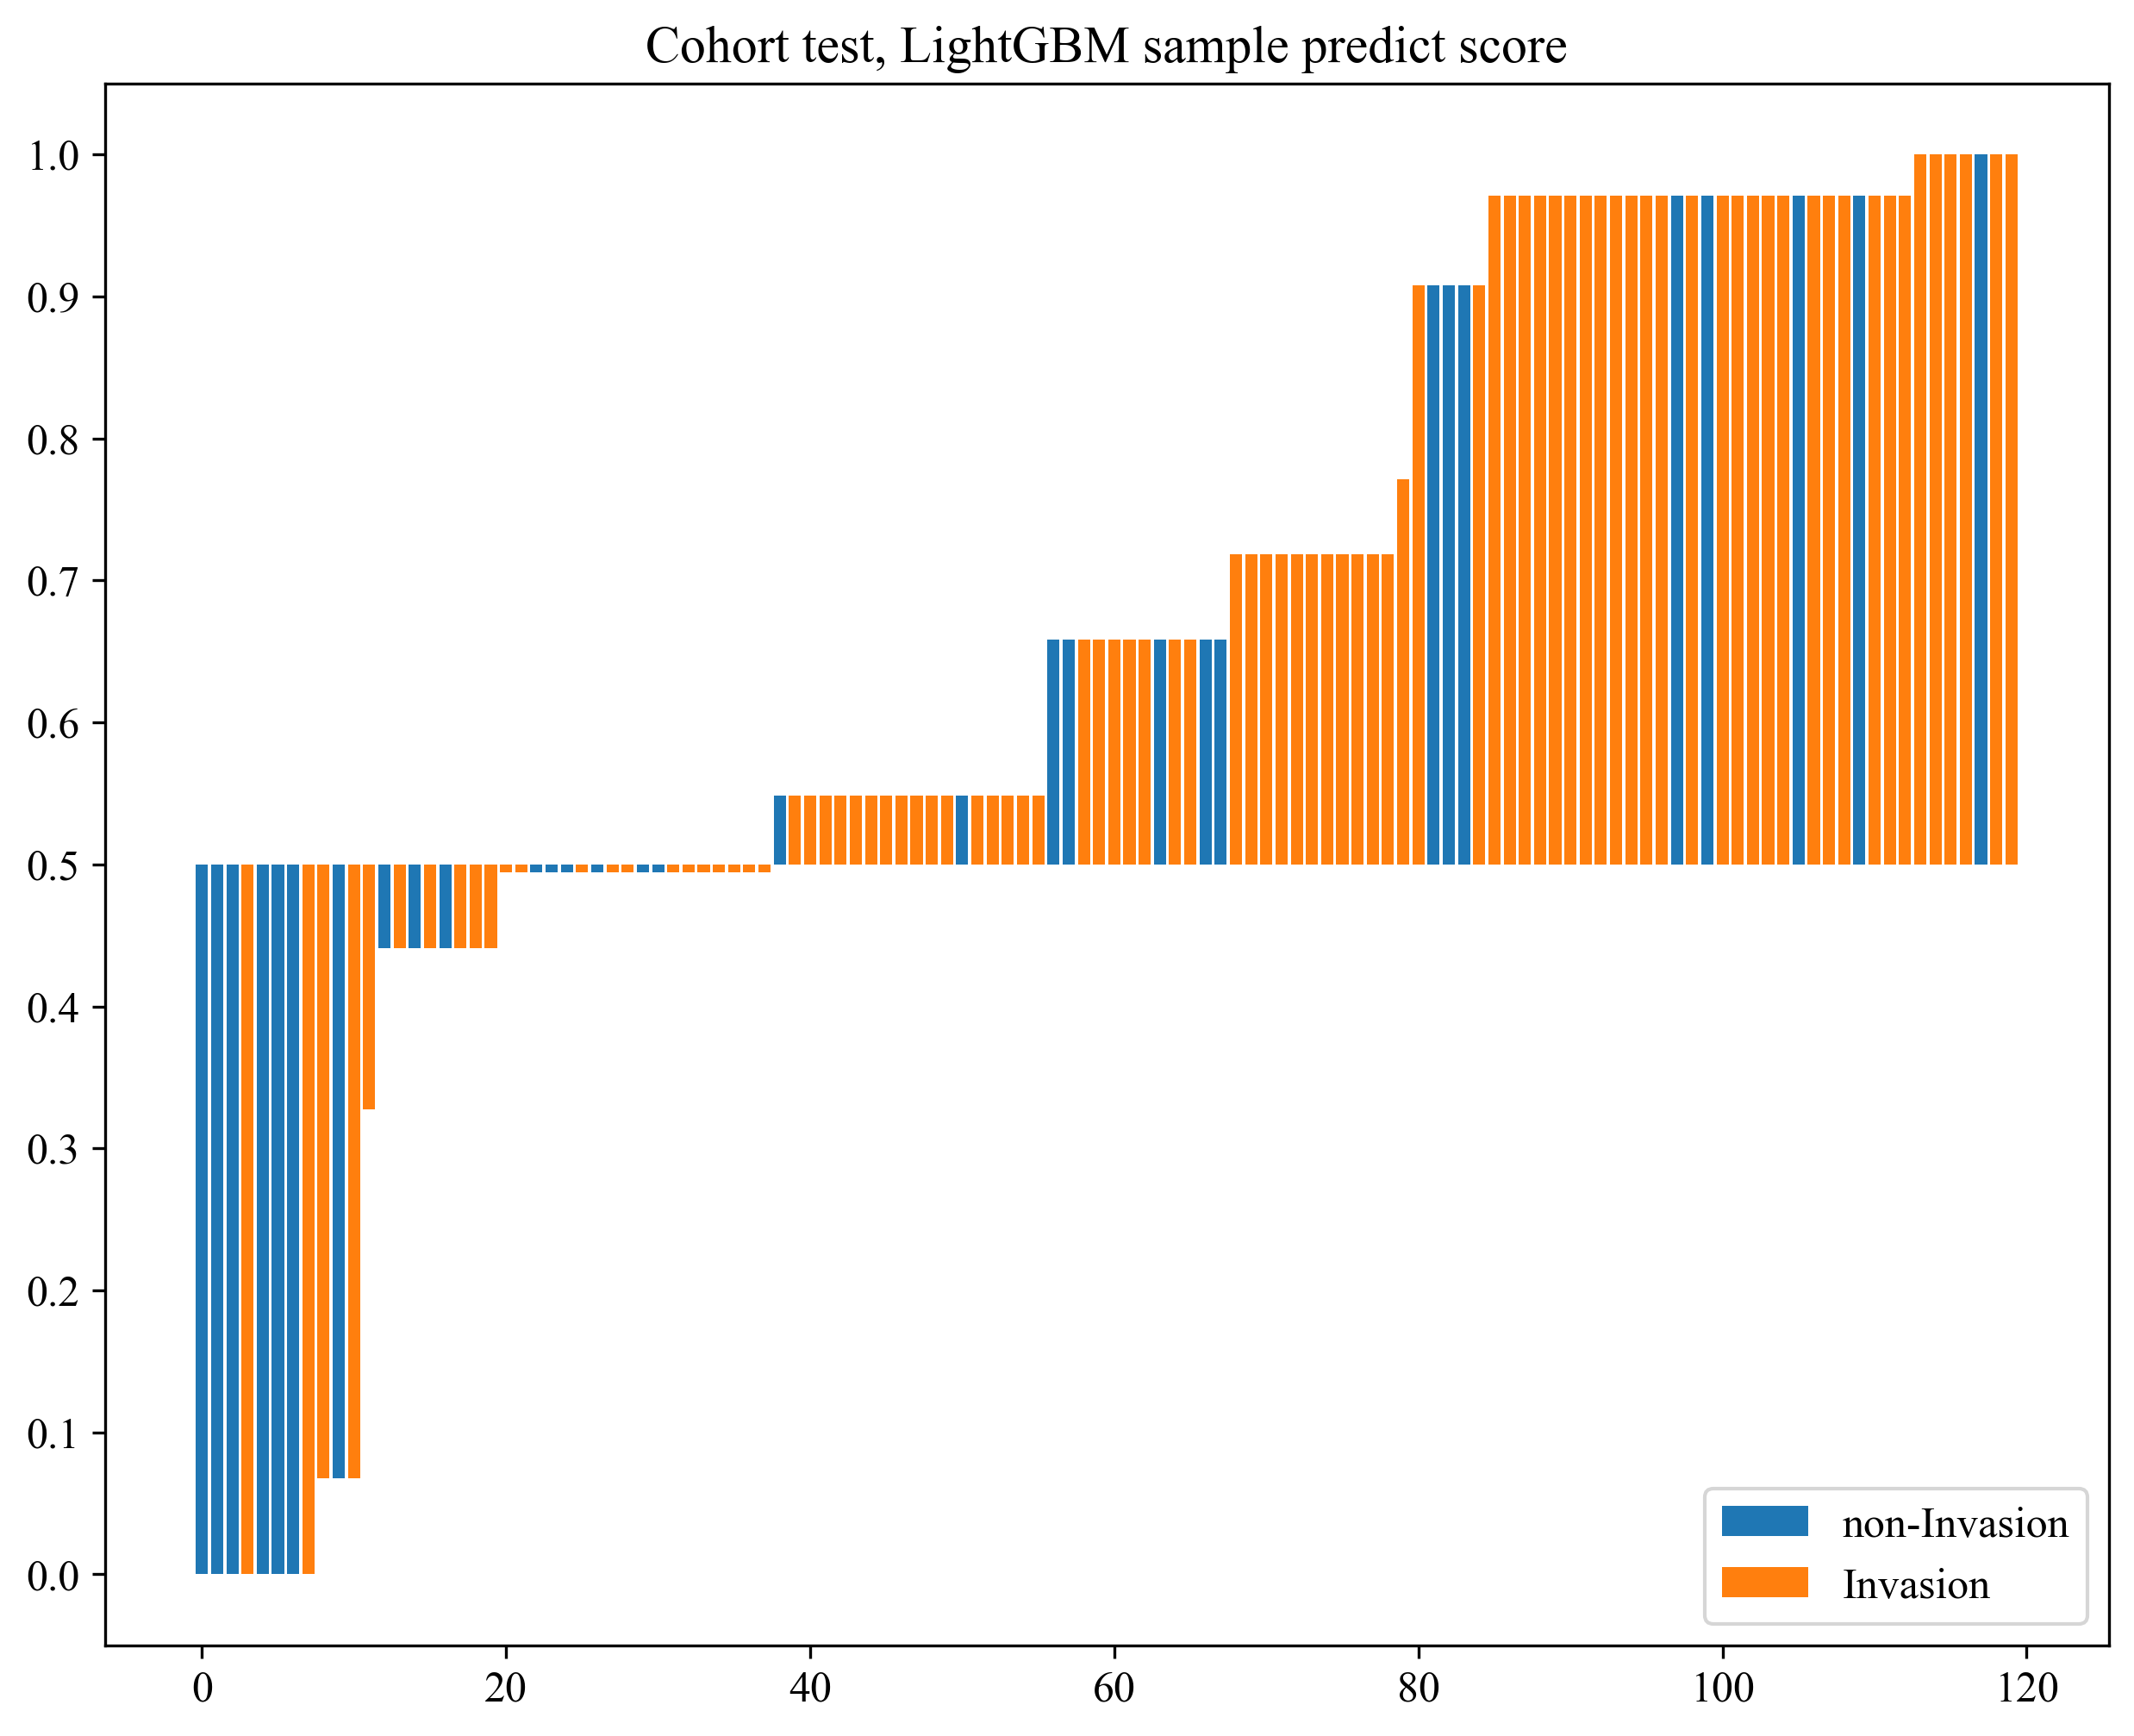

In [39]:
sel_model = model_names
c_matrix = {}

for sm in sel_model:
    if sm in model_names:
        sel_model_idx = model_names.index(sm)
        for idx, label in enumerate(labels):
            for sel_subset_idx, subset in enumerate(val_datasets.keys()):
                p_ = pred_scores[idx][sel_model_idx][0]
                okcomp.comp1.draw_predict_score(p_, y_train_sel,
                                                threshold=metric[(metric['Cohort'] == f'train-{label}') & (metric['model_name'] == sm)]['Threshold'])
                plt.title(f'Cohort train, {sm} sample predict score')
                plt.yticks([(i-5)/5 for i in range(11)], [i/10 for i in range(11)])
                plt.legend(mapping.values(), loc="lower right") 
                plt.savefig(f'img/{task_type}_train_{sm}_sample_dis.svg', bbox_inches = 'tight')
                plt.show()
            for sel_subset_idx, subset in enumerate(val_datasets.keys()):
                p_, l_ = pred_scores[idx][sel_model_idx][1][sel_subset_idx]
                okcomp.comp1.draw_predict_score(p_, l_[label],
                                                threshold=metric[(metric['Cohort'] == f'train-{label}') & (metric['model_name'] == sm)]['Threshold'])
                plt.title(f'Cohort {subset}, {sm} sample predict score')
                plt.yticks([(i-5)/5 for i in range(11)], [i/10 for i in range(11)])
                plt.legend(mapping.values(), loc="lower right") 
                plt.savefig(f'img/{task_type}_{subset}_{sm}_sample_dis.svg', bbox_inches = 'tight')
                plt.show()

## 保存模型结果

可以把模型预测的标签结果以及每个类别的概率都保存下来。

In [40]:
import os
import numpy as np

os.makedirs('results', exist_ok=True)
sel_model = sel_model

all_log = []
for idx, label in enumerate(labels):
    for sm in sel_model:
        if sm in model_names:
            sel_model_idx = model_names.index(sm)
            target = targets[idx][sel_model_idx]
            # 预测训练集和测试集数据。
            train_indexes = np.reshape(np.array(train_ids), (-1, 1)).astype(str)
            # 保存预测的训练集和测试集结果
            y_train_pred_scores = target.predict_proba(X_data)
            columns = ['ID'] + [f"{label}-{i}"for i in range(y_train_pred_scores.shape[1])]
            result_train = pd.DataFrame(np.concatenate([train_indexes, y_train_pred_scores], axis=1), columns=columns)
            result_train.to_csv(f'results/{task_type}{sm}_train.csv', index=False)
            result_train['model'] = sm
            result_train['pred_score'] = list(map(lambda x: max(x), 
                                                  np.array(result_train[['label-0', 'label-1']])))
            result_train['pred_label'] = list(map(lambda x: 0 if x[0] > x[1] else 1, 
                                                  np.array(result_train[['label-0', 'label-1']])))
            all_log.append(result_train)
            for subset, (X_val_sel, y_val_sel, val_ids) in val_datasets.items():
                val_indexes = np.reshape(np.array(val_ids), (-1, 1)).astype(str)
                y_val_pred_scores = target.predict_proba(X_val_sel)
                result_val = pd.DataFrame(np.concatenate([val_indexes, y_val_pred_scores], axis=1), columns=columns)
                result_val.to_csv(f'results/{task_type}{sm}_{subset}.csv', index=False)
                result_val['model'] = sm
                result_val['pred_score'] = list(map(lambda x: max(x), np.array(result_val[['label-0', 'label-1']])))
                result_val['pred_label'] = list(map(lambda x: 0 if x[0] > x[1] else 1,  
                                                    np.array(result_val[['label-0', 'label-1']])))
                all_log.append(result_val)
all_log = pd.concat(all_log, axis=0)